# Report
Bart van Lieshout   S1805967 <br>
Jesper Molenkamp    S1775138 <br>
Pepijn Rakers       S1881884

## Packages
Download and import packages required to run the code in this notebook.

In [2]:
# modules
!pip install oddt | grep -v 'already satisfied'
!pip install vina | grep -v 'already satisfied'
!pip install catboost

import sys, os, shutil
import nglview
from Bio.PDB import PDBParser, PDBIO, Select,  PDBList, MMCIFParser, StructureAlignment
import Bio.Align
from Bio import pairwise2
from Bio.Seq import Seq 
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from pathlib import Path
import rdkit
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import MolsToGridImage
import numpy as np
import pandas as pd
import requests
import math
from math import isnan, isinf

from pathlib import Path
from warnings import filterwarnings
import time

from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt
import py3Dmol
import glob
from vina import Vina
import MDAnalysis as mda
from MDAnalysis.coordinates import PDB
sys.path.insert(1, '/project/jhllei001/JHL_data/Jupyter_Dock/utilities')
import pubchempy as pcp
import time
from urllib.parse import quote

from IPython.display import Markdown, Image
import requests
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

# local scripts
from scripts import viewer
from scripts import bio_align
from utils import seed_everything

/opt/conda/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Functions

In [3]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    try:
        mol = Chem.MolFromSmiles(smiles)
        
    except:
        return('NaN')

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    
    
    
def plot_roc_curves_for_models(models, test_x, test_y, save_png=True):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"results/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig



def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc


def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold




def crossvalidation_reg(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    MAE_per_fold = []
    RMSE_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].pChEMBL_value.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].pChEMBL_value.tolist()
        
        test_results = fold_model.predict(test_x)
        # Prediction probability on test set
        from sklearn import metrics

        MAE_per_fold.append(metrics.mean_absolute_error(test_y, test_results))
        #print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_y, test_results))
        RMSE_per_fold.append(np.sqrt(metrics.mean_squared_error(test_y, test_results)))
        #mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
        #print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
        #print('Accuracy:', round(100*(1 - mape), 2))
    return(MAE_per_fold,RMSE_per_fold,fold_model)

#pubchem query functions

def query_pubchem_for_similar_compounds(smiles, threshold=80, n_records=10, logp=5, MW=1000):
    """
    Query PubChem for similar compounds and return the job key.

    Parameters
    ----------
    smiles : str
        The canonical SMILES string for the given compound.
    threshold : int
        The threshold of similarity, default 75%. In PubChem, the default threshold is 90%.
    n_records : int
        The maximum number of feedback records.

    Returns
    -------
    str
        The job key from the PubChem web service.
    """
    escaped_smiles = quote(smiles).replace("/", ".")
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/similarity/smiles/{escaped_smiles}/JSON?Threshold={threshold}&MaxRecords={n_records}&fullsearch=true&mw_lte={MW}&xlogp_lte={logp}"
    r = requests.get(url)
    r.raise_for_status()
    key = r.json()["Waiting"]["ListKey"]
    return key


def check_and_download(key, attempts=30):
    """
    Check job status and download PubChem CIDs when the job finished

    Parameters
    ----------
    key : str
        The job key of the PubChem service.
    attempts : int
        The time waiting for the feedback from the PubChem service.

    Returns
    -------
    list
        The PubChem CIDs of similar compounds.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/{key}/cids/JSON"
    print(f"Querying for job {key} at URL {url}...", end="")
    while attempts:
        r = requests.get(url)
        r.raise_for_status()
        response = r.json()
        if "IdentifierList" in response:
            cids = response["IdentifierList"]["CID"]
            break
        attempts -= 1
        print(".", end="")
        time.sleep(10)
    else:
        raise ValueError(f"Could not find matches for job key: {key}")
    return cids

def smiles_from_pubchem_cids(cids):
    """
    Get the canonical SMILES string from the PubChem CIDs.

    Parameters
    ----------
    cids : list
        A list of PubChem CIDs.

    Returns
    -------
    list
        The canonical SMILES strings of the PubChem CIDs.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(map(str, cids))}/property/CanonicalSMILES/JSON"
    r = requests.get(url)
    r.raise_for_status()
    return [item["CanonicalSMILES"] for item in r.json()["PropertyTable"]["Properties"]]


def PDBQTAtomLines(mol, donors, acceptors):
    """Create a list with PDBQT atom lines for each atom in molecule. Donors
    and acceptors are given as a list of atom indices.
    """

    atom_lines = [line.replace('HETATM', 'ATOM  ')
                  for line in Chem.MolToPDBBlock(mol).split('\n')
                  if line.startswith('HETATM') or line.startswith('ATOM')]

    pdbqt_lines = []
    for idx, atom in enumerate(mol.GetAtoms()):
        pdbqt_line = atom_lines[idx][:56]

        pdbqt_line += '0.00  0.00    '  # append empty vdW and ele
        # Get charge
        charge = 0.
        fields = ['_MMFF94Charge', '_GasteigerCharge', '_TriposPartialCharge']
        for f in fields:
            if atom.HasProp(f):
                charge = atom.GetDoubleProp(f)
                break
        # FIXME: this should not happen, blame RDKit
        if isnan(charge) or isinf(charge):
            charge = 0.
        pdbqt_line += ('%.3f' % charge).rjust(6)

        # Get atom type
        pdbqt_line += ' '
        atomicnum = atom.GetAtomicNum()
        if atomicnum == 6 and atom.GetIsAromatic():
            pdbqt_line += 'A'
        elif atomicnum == 7 and idx in acceptors:
            pdbqt_line += 'NA'
        elif atomicnum == 8 and idx in acceptors:
            pdbqt_line += 'OA'
        elif atomicnum == 1 and atom.GetNeighbors()[0].GetIdx() in donors:
            pdbqt_line += 'HD'
        else:
            pdbqt_line += atom.GetSymbol()
        pdbqt_lines.append(pdbqt_line)
    return pdbqt_lines

def MolToPDBQTBlock(mol, flexible=True, addHs=False, computeCharges=False):
    """Write RDKit Molecule to a PDBQT block

    Parameters
    ----------
        mol: rdkit.Chem.rdchem.Mol
            Molecule with a protein ligand complex
        flexible: bool (default=True)
            Should the molecule encode torsions. Ligands should be flexible,
            proteins in turn can be rigid.
        addHs: bool (default=False)
            The PDBQT format requires at least polar Hs on donors. By default Hs
            are added.
        computeCharges: bool (default=False)
            Should the partial charges be automatically computed. If the Hs are
            added the charges must and will be recomputed. If there are no
            partial charge information, they are set to 0.0.

    Returns
    -------
        block: str
            String wit PDBQT encoded molecule
    """
    # make a copy of molecule
    mol = Chem.Mol(mol)

    # if flexible molecule contains multiple fragments write them separately
    if flexible and len(Chem.GetMolFrags(mol)) > 1:
        return ''.join(MolToPDBQTBlock(frag, flexible=flexible, addHs=addHs,
                                       computeCharges=computeCharges)
                       for frag in Chem.GetMolFrags(mol, asMols=True))

    # Identify donors and acceptors for atom typing
    # Acceptors
    patt = Chem.MolFromSmarts('[$([O;H1;v2]),'
                              '$([O;H0;v2;!$(O=N-*),'
                              '$([O;-;!$(*-N=O)]),'
                              '$([o;+0])]),'
                              '$([n;+0;!X3;!$([n;H1](cc)cc),'
                              '$([$([N;H0]#[C&v4])]),'
                              '$([N&v3;H0;$(Nc)])]),'
                              '$([F;$(F-[#6]);!$(FC[F,Cl,Br,I])])]')
    acceptors = list(map(lambda x: x[0],
                         mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    # Donors
    patt = Chem.MolFromSmarts('[$([N&!H0&v3,N&!H0&+1&v4,n&H1&+0,$([$([Nv3](-C)(-C)-C)]),'
                              '$([$(n[n;H1]),'
                              '$(nc[n;H1])])]),'
                              # Guanidine can be tautormeic - e.g. Arginine
                              '$([NX3,NX2]([!O,!S])!@C(!@[NX3,NX2]([!O,!S]))!@[NX3,NX2]([!O,!S])),'
                              '$([O,S;H1;+0])]')
    donors = list(map(lambda x: x[0],
                      mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    if addHs:
        mol = Chem.AddHs(mol, addCoords=True, onlyOnAtoms=donors, )
    if addHs or computeCharges:
        AllChem.ComputeGasteigerCharges(mol)

    atom_lines = PDBQTAtomLines(mol, donors, acceptors)
    assert len(atom_lines) == mol.GetNumAtoms()

    pdbqt_lines = []

    # vina scores
    if (mol.HasProp('vina_affinity') and mol.HasProp('vina_rmsd_lb') and
            mol.HasProp('vina_rmsd_lb')):
        pdbqt_lines.append('REMARK VINA RESULT:  ' +
                           ('%.1f' % float(mol.GetProp('vina_affinity'))).rjust(8) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_lb'))).rjust(11) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_ub'))).rjust(11))

    pdbqt_lines.append('REMARK  Name = ' +
                       (mol.GetProp('_Name') if mol.HasProp('_Name') else ''))
    if flexible:
        # Find rotatable bonds
        rot_bond = Chem.MolFromSmarts('[!$(*#*)&!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])&'
                                      '!$([CD3](=[N,O,S])-!@[#7,O,S!D1])&'
                                      '!$([#7,O,S!D1]-!@[CD3]=[N,O,S])&'
                                      '!$([CD3](=[N+])-!@[#7!D1])&'
                                      '!$([#7!D1]-!@[CD3]=[N+])]-!@[!$(*#*)&'
                                      '!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])]')
        bond_atoms = list(mol.GetSubstructMatches(rot_bond))
        num_torsions = len(bond_atoms)

        # Active torsions header
        pdbqt_lines.append('REMARK  %i active torsions:' % num_torsions)
        pdbqt_lines.append('REMARK  status: (\'A\' for Active; \'I\' for Inactive)')
        for i, (a1, a2) in enumerate(bond_atoms):
            pdbqt_lines.append('REMARK%5.0i  A    between atoms: _%i  and  _%i'
                               % (i + 1, a1 + 1, a2 + 1))

        # Fragment molecule on bonds to ge rigid fragments
        bond_ids = [mol.GetBondBetweenAtoms(a1, a2).GetIdx()
                    for a1, a2 in bond_atoms]
        if bond_ids:
            mol_rigid_frags = Chem.FragmentOnBonds(mol, bond_ids, addDummies=False)
        else:
            mol_rigid_frags = mol
        frags = list(Chem.GetMolFrags(mol_rigid_frags))

        def weigh_frags(frag):
            """sort by the fragment size and the number of bonds (secondary)"""
            num_bonds = 0
            # bond_weight = 0
            for a1, a2 in bond_atoms:
                if a1 in frag or a2 in frag:
                    num_bonds += 1
                    # for frag2 in frags:
                    #     if a1 in frag2 or a2 in frag2:
                    #         bond_weight += len(frag2)

            # changed signs are fixing mixed sorting type (ascending/descending)
            return -len(frag), -num_bonds,  # bond_weight
        frags = sorted(frags, key=weigh_frags)

        # Start writting the lines with ROOT
        pdbqt_lines.append('ROOT')
        frag = frags.pop(0)
        for idx in frag:
            pdbqt_lines.append(atom_lines[idx])
        pdbqt_lines.append('ENDROOT')

        # Now build the tree of torsions usign DFS algorithm. Keep track of last
        # route with following variables to move down the tree and close branches
        branch_queue = []
        current_root = frag
        old_roots = [frag]

        visited_frags = []
        visited_bonds = []
        while len(frags) > len(visited_frags):
            end_branch = True
            for frag_num, frag in enumerate(frags):
                for bond_num, (a1, a2) in enumerate(bond_atoms):
                    if (frag_num not in visited_frags and
                        bond_num not in visited_bonds and
                        (a1 in current_root and a2 in frag or
                         a2 in current_root and a1 in frag)):
                        # direction of bonds is important
                        if a1 in current_root:
                            bond_dir = '%i %i' % (a1 + 1, a2 + 1)
                        else:
                            bond_dir = '%i %i' % (a2 + 1, a1 + 1)
                        pdbqt_lines.append('BRANCH %s' % bond_dir)
                        for idx in frag:
                            pdbqt_lines.append(atom_lines[idx])
                        branch_queue.append('ENDBRANCH %s' % bond_dir)

                        # Overwrite current root and stash previous one in queue
                        old_roots.append(current_root)
                        current_root = frag

                        # remove used elements from stack
                        visited_frags.append(frag_num)
                        visited_bonds.append(bond_num)

                        # mark that we dont want to end branch yet
                        end_branch = False
                        break
                    else:
                        continue
                    break  # break the outer loop as well

            if end_branch:
                pdbqt_lines.append(branch_queue.pop())
                if old_roots:
                    current_root = old_roots.pop()
        # close opened branches if any is open
        while len(branch_queue):
            pdbqt_lines.append(branch_queue.pop())
        pdbqt_lines.append('TORSDOF %i' % num_torsions)
    else:
        pdbqt_lines.extend(atom_lines)

    return '\n'.join(pdbqt_lines)

def MolFromPDBQTBlock(filename, sanitize=True, removeHs=True):
    """Read PDBQT block to a RDKit Molecule
    Parameters
    ----------
        block: string
            Residue name which explicitly pint to a ligand(s).
        sanitize: bool (default=True)
            Should the sanitization be performed
        removeHs: bool (default=True)
            Should hydrogens be removed when reading molecule.
    Returns
    -------
        mol: rdkit.Chem.rdchem.Mol
            Molecule read from PDBQT
    """
    pdb_lines = []
    name = ''
    data = {}
    with open(filename) as file:
        lines = file.readlines()
        block = [line.rstrip() for line in lines]
        
    for line in block: #.split('\n'):
        # Get all know data from REMARK section
        if line[:12] == 'REMARK  Name':
            name = line[15:].strip()
        elif line[:18] == 'REMARK VINA RESULT':
            tmp = line[19:].split()
            data['vina_affinity'] = tmp[0]
            data['vina_rmsd_lb'] = tmp[1]
            data['vina_rmsd_ub'] = tmp[2]

        # no more data to collect
        if line[:4] != 'ATOM':
            continue

        pdb_line = line[:56]
        pdb_line += '1.00  0.00           '

        # Do proper atom type lookup
        atom_type = line[71:].split()[1]
        if atom_type == 'A':
            atom_type = 'C'
        elif atom_type[:1] == 'O':
            atom_type = 'O'
        elif atom_type[:1] == 'H':
            atom_type = 'H'
            if removeHs:
                continue
        elif atom_type == 'NA':
            atom_type = 'N'

        pdb_lines.append(pdb_line + atom_type)
    mol = Chem.MolFromPDBBlock('\n'.join(pdb_lines), sanitize=False)
    if sanitize:
        Chem.SanitizeMol(mol)
    else:
        Chem.GetSSSR(mol)
    # reorder atoms using serial
    new_order = sorted(range(mol.GetNumAtoms()),
                       key=lambda i: (mol.GetAtomWithIdx(i)
                                      .GetPDBResidueInfo()
                                      .GetSerialNumber()))
    mol = Chem.RenumberAtoms(mol, new_order)

    # properties must be set on final copy of Mol, RenumberAtoms purges data
    mol.SetProp('_Name', name)
    for k, v in data.items():
        mol.SetProp(str(k), str(v))

    return mol



def Rg(filename):
    '''
    Calculates the Radius of Gyration (Rg) of a protein given its .pdb 
    structure file. Returns the Rg integer value in Angstrom.
    '''
    coord = list()
    mass = list()
    Structure = open(filename, 'r')
    for line in Structure:
        try:
            line = line.split()
            x = float(line[6])
            y = float(line[7])
            z = float(line[8])
            coord.append([x, y, z])
            if line[-1] == 'C':
                mass.append(12.0107)
            elif line[-1] == 'O':
                mass.append(15.9994)
            elif line[-1] == 'N':
                mass.append(14.0067)
            elif line[-1] == 'S':
                mass.append(32.065)
        except:
            pass
    xm = [(m*i, m*j, m*k) for (i, j, k), m in zip(coord, mass)]
    tmass = sum(mass)
    rr = sum(mi*i + mj*j + mk*k for (i, j, k), (mi, mj, mk) in zip(coord, xm))
    mm = sum((sum(i) / tmass)**2 for i in zip(*xm))
    rg = math.sqrt(rr / tmass-mm)
    return(round(rg, 3))

def COG(pdbfile, include='ATOM,HETATM'):
    """
    Calculates center of geometry of a protein and/or ligand structure.
    Returns:
        center (list): List of float coordinates [x,y,z] that represent the
        center of geometry (precision 3).
    """

    center = [None, None, None]
    include = tuple(include.split(','))

    with open(pdbfile) as pdb:

        # extract coordinates [ [x1,y1,z1], [x2,y2,z2], ... ]
        coordinates = []
        for line in pdb:
            if line.startswith(include):
                coordinates.append([float(line[30:38]),    # x_coord
                                    float(line[38:46]),    # y_coord
                                    float(line[46:54])     # z_coord
                                   ])

        # calculate center of geometry
        center = [sum([coordinates[i][j]/(len(coordinates))
              for i in range(len(coordinates))]) for j in range(3)]
        center = [round(center[i], 3) for i in range(3)]
    return center


### Checks and inputs

In [4]:
HOMEDIR = str(Path.home())+"/ACMDD_Tyk2_2022" #Here we set the directory that we are working in
HOMEDIR
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('Report_data')
except:
    print("Directory already exists")
os.chdir('Report_data')

SEED = 1
seed_everything(SEED)
os.getcwd()

#Load saved data?
Load_data = True

!chmod 755 ../bin/lepro # needed to get permission to use the LePro too

if os.access('../bin/lepro', os.R_OK) == True:        # making sure we have access to the LePro tool
    print("You have permission to the LePro tool")
elif os.access('../bin/lepro', os.R_OK) == False:
    print("You have no permission to the LePro tool")

Directory already exists
You have permission to the LePro tool



# Bioinformatics

Below, a dataframe is made that consists of information about the target, the same target in a different species, and the most closely related protein in the same species that is not an isoform

## Analyzing your target

Interleukins are a type of cytokine that are capable of modulating the immune response when foreign substances are found in the body. However the immune response can sometimes be triggered by the body itself resulting in autoimmune diseases such as psoriasis. Targeting the Tyk2 receptor can reduce the effect some of the interleukins, reducing the immune response and alleviating symptoms of these diseases. It was only recently (september 2022) that a Tyk2 specific inhibitor was approved for treatment of medium to severe psoriasis, however drugs targeting the overarching JAK family proteins like Peficitinib have been around for a few years. The Tyk2 protein forms dimers with other JAK family proteins and can be found embedded in the cell membrane. 


In [5]:
#Dataframe of the target, the target in a different species, and the protein closest to the target that is not an isoform.

proteins = pd.DataFrame({"Protein name":["Non-receptor tyrosine-protein kinase","Tyrosine-protein kinase","Tyrosine-protein kinase"],
              "Protein family":["JAK","JAK","JAK"],
              "Gene":["TYK2","TYK2","JAK1"],
              "Species":["Homo sapiens (Human)","Pan troglodytes (Chimpanzee)","Homo sapiens (Human)"],
              "Accession number":["P29597","K7AU67","P23458"],
              "Amino acid length":[1187,1187,1154],
              "Identity (%)":[100, 99.2, 46.9],
              "Mass (Da)":[133650,133769,133277],
              "Protein existence":["Evidence at protein level","Evidence at transcript level","Evidence at protein level"],
              "Status":["UniProtKB reviewed (Swiss-Prot)","UniProtKB unreviewed (TrEMBL)","UniProtKB reviewed (Swiss-Prot)"]})

display(proteins)

Protein name Protein family  Gene  \
0  Non-receptor tyrosine-protein kinase            JAK  TYK2   
1               Tyrosine-protein kinase            JAK  TYK2   
2               Tyrosine-protein kinase            JAK  JAK1   

                        Species Accession number  Amino acid length  \
0          Homo sapiens (Human)           P29597               1187   
1  Pan troglodytes (Chimpanzee)           K7AU67               1187   
2          Homo sapiens (Human)           P23458               1154   

   Identity (%)  Mass (Da)             Protein existence  \
0         100.0     133650     Evidence at protein level   
1          99.2     133769  Evidence at transcript level   
2          46.9     133277     Evidence at protein level   

                            Status  
0  UniProtKB reviewed (Swiss-Prot)  
1    UniProtKB unreviewed (TrEMBL)  
2  UniProtKB reviewed (Swiss-Prot)

Which target is more similar compared to the original target? <br>
The Chimpanzee TYK2 is more similar to the human TYK2 than human JAK1 is to human TYK2 <br> <br>
Did you expect this? <br>
Yes this is expected as humans and chimpanzees are closely related and TYK2 is highly like to have a similar function

# Retrieving a 3D structure


This part of the code shows the target protein TYK2 with the ligand 0X5 in a 3D viewer together with the residues within 5 Angstrom of the ligand.

In [6]:
TARGET_PDB_ID = "4gih" #TYK2 P29597
LIGAND_CODE = "0X5" #Residue name of ligand in TYK2 P29597

view_target = nglview.show_pdbid(TARGET_PDB_ID)
view_target


viewer.show_residues_around(view_target)
view_target.center()
view_target

NGLWidget()

At the moment we can not see the hydrogen atoms since they are below the resolution of the x-ray method. 

In the next stage, we will add the hydrogens and have another look at the structure. We will split the protein and ligand and save them seperately.

In [7]:

#########################################################
#Adding hydrogens to docking site residues of the target#
#########################################################

#Retrieve coordinates of target and turn it into a BioPython object
pdbl = PDBList()
pdbl.retrieve_pdb_file(TARGET_PDB_ID, pdir=TARGET_PDB_ID)
parser = MMCIFParser()
structure = parser.get_structure("TARGETPROT",'{}/{}.cif'.format(TARGET_PDB_ID,TARGET_PDB_ID))


#Save the ligand
class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == LIGAND_CODE:
            return 1
        else:
            return 0

class NonHetSelect(Select):
    def accept_residue(self, residue):
        return 1 if residue.id[0] == " " else 0

io = PDBIO()
io.set_structure(structure)
io.save("ligand-{}.pdb".format(LIGAND_CODE), ResSelect())
io.save("protein-{}.pdb".format(TARGET_PDB_ID), NonHetSelect())


#Load ligand
command = '../bin/lepro protein-{}.pdb'.format(TARGET_PDB_ID)
os.system(command)
#shutil.move('pro.pdb','{}_prepped.pdb'.format(TARGET_PDB_ID))

#Combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(TARGET_PDB_ID),
"ligand-{}.pdb".format(LIGAND_CODE)
]
with open('{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)
                    

#view the target and ligand in 3D with nglviewer
with open('{}-complex.pdb'.format(TARGET_PDB_ID)) as f:
    view_target_residues_hydrogens = nglview.show_file(f, ext="pdb")
    
view_target_residues_hydrogens.center()
viewer.show_residues_around(view_target_residues_hydrogens)
view_target_residues_hydrogens


#Have a look at the residues near the ligand, can you observe any important interactions? Describe in your report which interactions you observe, and what type of interactions they are.

#Note that we do not see any hydrogen atoms, do you know why?

#-Hydrogens are below the resolution of the x-ray method

Structure exists: '4gih/4gih.cif' 


NGLWidget()

Let's have a look again at the protein

Now, we will repeat the procedure for the most similar target that we identified (the highest scoring hit from the PDB): <br>
In our case, human JAK1 (code 7q7l) is the most similar target.

In [8]:
#############################################################
#Adding hydrogens to docking site residues of the off_target#
#############################################################

OFF_TARGET_PDB_ID = "7q7l" # Enter your off target PDB code here, example = '5uen'
OFF_TARGET_LIGAND = "9I2"  # Enter the ligand code here, example = 'DU1'

pdbl = PDBList()
pdbl.retrieve_pdb_file(OFF_TARGET_PDB_ID, pdir=OFF_TARGET_PDB_ID)

parser = MMCIFParser()
structure = parser.get_structure("TARGETPROT",'{}/{}.cif'.format(OFF_TARGET_PDB_ID,OFF_TARGET_PDB_ID))


#Save ligand
class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == OFF_TARGET_LIGAND:
            return 1
        else:
            return 0

io = PDBIO()
io.set_structure(structure)
io.save("ligand-{}.pdb".format(OFF_TARGET_LIGAND), ResSelect())
io.save("protein-{}.pdb".format(OFF_TARGET_PDB_ID), NonHetSelect())



#Load ligand
command = '../bin/lepro protein-{}.pdb'.format(OFF_TARGET_PDB_ID)
os.system(command)
#shutil.move('pro.pdb','{}_prepped.pdb'.format(OFF_TARGET_PDB_ID))



#Combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(OFF_TARGET_PDB_ID),
"ligand-{}.pdb".format(OFF_TARGET_LIGAND)
]
with open('{}-complex.pdb'.format(OFF_TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)
                    
                    
#View the off_target and ligand in 3D with nglviewer
with open('{}-complex.pdb'.format(OFF_TARGET_PDB_ID)) as f:
    view_offtarget = nglview.show_file(f, ext="pdb")
    
view_offtarget.center()
viewer.show_residues_around(view_offtarget)
view_offtarget

Structure exists: '7q7l/7q7l.cif' 


NGLWidget()

Now the two structures will be aligned

In [9]:
###########################################
#Aligning target 4GIH and off-target in 3D#
###########################################

# Get the structures
PDBCODE_1 = '4gih' # Name of the first structure
PDBCODE_2 = '7q7l' # Name of the second structure


data = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/{PDBCODE_1}').json()[PDBCODE_1.lower()]
SEQ1 = (data[0]['sequence'])
SEQ1 = Seq(SEQ1)

data = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/{PDBCODE_2}').json()[PDBCODE_2.lower()]
SEQ2 = (data[0]['sequence'])
SEQ2 = Seq(SEQ2)

alignments = pairwise2.align.globalxx(SEQ1, SEQ2)

for align1, align2, score, begin, end in alignments:
    filename = "alignment.fasta"
    with open(filename, "w") as handle:
        handle.write(">SEQ1\n%s\n>SEQ2\n%s\n" % (align1, align2))

print(alignments[0])

bio_align.run('{}-complex.pdb'.format(TARGET_PDB_ID),'{}-complex.pdb'.format(OFF_TARGET_PDB_ID))


# combine protein and ligand files
filenames = [
'{}-complex.pdb'.format(TARGET_PDB_ID,TARGET_PDB_ID),
"{}-complex_transformed.pdb".format(OFF_TARGET_PDB_ID)
]
with open('{}-{}-merged.pdb'.format(TARGET_PDB_ID,OFF_TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)
                    
with open('{}-{}-merged.pdb'.format(TARGET_PDB_ID,OFF_TARGET_PDB_ID)) as f:
    view_alignment = nglview.show_file(f, ext="pdb")
    
view_alignment

Alignment(seqA='M--------------------GSPAS-DPTV-FHK--RY-LKKIRD-L---GE-GH-FGKVSLY---C-YDPTN--DG-TGEMV-AVKALKADAGP-QHRSGWKQ-EI----D----I--LRT--LYHE-HI--I-KYKGC-CED--AGAAS---LQ-LV-MEYVPL--GSLRDYLP-----R--HSIGLAQL-LLFAQ---QICE-GMA-YLHAQH----YIHRN-LAA-RNVL-LD--ND--RLVKIGDFGLA-KAV-PEGH---EYYR-VR-ED-GD-SPV-FWYAPEC-LK-EY-KFYY--ASDVWSFGVT-LYELL-THCDS----SQ-SPPTKFL-EL----IGIA---QGQMT--VLRLT---ELLER---GERLPRPDK-CPA-EV-YHLMKNCWE--TEASF--------RPT-FEN--LIPI-LKT-VHEKY---RHHHHHH-----', seqB='MHHHHHHDYKDDDDKENLYFQG----RDPT-QF--EER-HL-K---FLQQLG-KG-NFG--S--VEMCRYDP--LQD-NTGE-VVAVK--K-----LQH-S----TE-EHLRDFEREIEIL--KSL---QH-DNIVKYKG-VC--YSAG---RRNL-KL-IMEY--LPYGSLRDYL-QKHKERIDH-I-----KLL--QYTSQIC-KGM-EYL----GTKRYIHR-DL-ATRN--IL-VEN-ENR-VKIGDFGL-TK-VLP---QDKEYY-KV-KE-PG-ESP-IFWYAPE-SL-TE-SKF--SVASDVWSFGV-VLYE-LFT----YIEKS-KSPP----AE-FMRMIG--NDKQGQ--SIV---THLIELL--KNNG-RLPRPD-GCP-DE-IY--M-----IMTE---CWNNNVNQRP-SF--RDL---AL--RV----DQIR------DNMAG', score=161.0, start=0, end=457)


NGLWidget()

In [10]:
print("This is the alignment of TYK2 and JAK1")
display(view_alignment)

This is the alignment of TYK2 and JAK1


NGLWidget()

The structures seem to have a rather good alignment with each other. 

Protein sequence aligment of the proteins shown above: <br>
![image info](Report_data/Images/Sequence_alignment.jpeg)

Below you can see the the reactions between the Tyk2 protein and the co-crystalized ligand 0X5. <br>
Here we see that Hydrophobic interactions are predominant, with a select few hydrogen bonds with the nitrogen atoms in the molecular structure of the ligand. <br>
The specific interactions can be seen in the table below.


![image info](Report_data/Images/4GIH_0X5_A_1201.png)
![image info](Report_data/Images/4GIH_0X5_A_1201_3D.png)
![image_info](Report_data/Images/PLIP_table.png)

In [11]:
display(proteins)
print("Here is an overview of the three protein's characteristics")

Protein name Protein family  Gene  \
0  Non-receptor tyrosine-protein kinase            JAK  TYK2   
1               Tyrosine-protein kinase            JAK  TYK2   
2               Tyrosine-protein kinase            JAK  JAK1   

                        Species Accession number  Amino acid length  \
0          Homo sapiens (Human)           P29597               1187   
1  Pan troglodytes (Chimpanzee)           K7AU67               1187   
2          Homo sapiens (Human)           P23458               1154   

   Identity (%)  Mass (Da)             Protein existence  \
0         100.0     133650     Evidence at protein level   
1          99.2     133769  Evidence at transcript level   
2          46.9     133277     Evidence at protein level   

                            Status  
0  UniProtKB reviewed (Swiss-Prot)  
1    UniProtKB unreviewed (TrEMBL)  
2  UniProtKB reviewed (Swiss-Prot)

Here is an overview of the three protein's characteristics


# Start machine learning
In this section, we will look into cheminformatics. We ended the last session looking at the interaction of the ligand in the binding site. To refresh our minds, 


### Ligand : 0X5
InChiKey: IAFNAEGXTKTGHN-UHFFFAOYSA-N <br>
Smiles: C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl  

Similarity search with tanimoto threshold at 90% yielded 430 results. <br>
A similarity search with the threshold at 80% yields 1000 results


The ChEMBL ID of this compound is CHEMBL2387224 <br>
Similarity searches on ChEMBL yields only a single compound for thresholds at 95% and 90% <br>
There are most likely less similar compounds found on ChEMBL since this is a manually created database


A 70% similarity search gave 20 similar compounds. One of these compounds can be found using the hyperlink below. <br>
https://zinc15.docking.org/substances/ZINC000096928695/

The entire search can be found here: <br>
https://zinc15.docking.org/substances/?highlight=C1CC1C%28%3DO%29NC2%3DNC%3DCC%28%3DC2%29NC%28%3DO%29C3%3DC%28C%3DCC%3DC3Cl%29Cl&ecfp4_fp-tanimoto-30=O%3DC%28Nc2ccnc%28NC%28%3DO%29C1CC1%29c2%29c3c%28Cl%29cccc3Cl



A 60% similarity search gave 17 similar compounds. The search results can be found below. <br>
https://zinc15.docking.org/substances/?highlight=C1CC1C%28%3DO%29NC2%3DNC%3DCC%28%3DC2%29NC%28%3DO%29C3%3DC%28C%3DCC%3DC3Cl%29Cl&ecfp4_fp-tanimoto-40=O%3DC%28Nc2ccnc%28NC%28%3DO%29C1CC1%29c2%29c3c%28Cl%29cccc3Cl

The compounds found in both searches are very similar, however three compounds were removed by the 60% similarity search. The similarity threshold is just an exclusion criterium to filter out compounds with a similarity lower tanimoto score. If you want more similar compounds you need to use lower percentage similarity searches 



A ChEMBL dataset containing compounds with known bioactivity to the Tyk2 receptor has been downloaded. <br>

In [12]:
CHEMBLID = 'CHEMBL3553' # Enter the CHEMBL ID of your target here
FILENAME = 'CHEMBL3553.csv' # The filename of the uploaded file

data = pd.read_csv(FILENAME, sep = ";")
data= data[data['Standard Type'] == "IC50"]
print("There are a total of {} datapoints in this set".format(len(data)))

type(data)

There are a total of 1920 datapoints in this set


pandas.core.frame.DataFrame

In [13]:
display(data.head())

Molecule ChEMBL ID Molecule Name  Molecule Max Phase Molecular Weight  \
4       CHEMBL2181327           NaN                   0           459.59   
5       CHEMBL2181315           NaN                   0           359.43   
25        CHEMBL21156           NaN                   0           309.34   
38      CHEMBL1938656           NaN                   0           462.60   
48      CHEMBL1938648           NaN                   0           382.49   

   #RO5 Violations AlogP                  Compound Key  \
4                0  4.49  17h, 85:15 trans/cis mixture   
5                0  4.99  16a, 85:15 trans/cis mixture   
25               0  3.99                             6   
38               0  3.00                            22   
48               0  3.08                            13   

                                               Smiles Standard Type  \
4   CN(C)CCN(C)c1ccc2cc1COCC=CCOCc1cccc(c1)-c1ccnc...          IC50   
5         C1=CCCOc2cccc(c2)-c2ccnc(n2)Nc2cccc(c2)OCC1          IC50   
25     CC(C)(C)c1nc2c3ccc(F)cc3c3c(=O)[nH]ccc3c2[nH]1          IC50   
38  COCCNC(=O)c1cnc(N)c2cc(-c3ccc(S(=O)(=O)NC(C)(C...          IC50   
48    CN(C)C(=O)c1cnc(N)c2cc(-c3ccc(N4CCOCC4)cc3)sc12          IC50   

   Standard Relation  ...                   Target Name Target Organism  \
4                '='  ...  Tyrosine-protein kinase TYK2    Homo sapiens   
5                '='  ...  Tyrosine-protein kinase TYK2    Homo sapiens   
25               '='  ...  Tyrosine-protein kinase TYK2    Homo sapiens   
38               '>'  ...  Tyrosine-protein kinase TYK2    Homo sapiens   
48               '='  ...  Tyrosine-protein kinase TYK2    Homo sapiens   

       Target Type Document ChEMBL ID Source ID     Source Description  \
4   SINGLE PROTEIN      CHEMBL2176955         1  Scientific Literature   
5   SINGLE PROTEIN      CHEMBL2176955         1  Scientific Literature   
25  SINGLE PROTEIN      CHEMBL1135866         1  Scientific Literature   
38  SINGLE PROTEIN      CHEMBL1938231         1  Scientific Literature   
48  SINGLE PROTEIN      CHEMBL1938231         1  Scientific Literature   

            Document Journal Document Year Cell ChEMBL ID Properties  
4              J. Med. Chem.        2011.0           None        NaN  
5              J. Med. Chem.        2011.0           None        NaN  
25  Bioorg. Med. Chem. Lett.        2002.0           None        NaN  
38             J. Med. Chem.        2011.0  CHEMBL3307634        NaN  
48             J. Med. Chem.        2011.0  CHEMBL3308860        NaN  

[5 rows x 45 columns]

We then clean the dataframe up a bit and check the total amoount of compounds in the set.

In [14]:
pd_data = data[['Molecule ChEMBL ID','pChEMBL Value','Smiles','Assay Type', 'Standard Relation','Standard Value']]
pd_data.rename(columns={'pChEMBL Value': 'pChEMBL_value', 'Assay Type':'Assay_Type'}, inplace=True)
pd_data = pd_data.reset_index(drop=True)
display(pd_data.head())
print("There are a total of {} datapoints in this set".format(len(pd_data)))

Molecule ChEMBL ID  pChEMBL_value  \
0      CHEMBL2181327           7.15   
1      CHEMBL2181315           5.28   
2        CHEMBL21156           9.00   
3      CHEMBL1938656            NaN   
4      CHEMBL1938648           5.29   

                                              Smiles Assay_Type  \
0  CN(C)CCN(C)c1ccc2cc1COCC=CCOCc1cccc(c1)-c1ccnc...          B   
1        C1=CCCOc2cccc(c2)-c2ccnc(n2)Nc2cccc(c2)OCC1          B   
2     CC(C)(C)c1nc2c3ccc(F)cc3c3c(=O)[nH]ccc3c2[nH]1          B   
3  COCCNC(=O)c1cnc(N)c2cc(-c3ccc(S(=O)(=O)NC(C)(C...          B   
4    CN(C)C(=O)c1cnc(N)c2cc(-c3ccc(N4CCOCC4)cc3)sc12          B   

  Standard Relation  Standard Value  
0               '='            71.0  
1               '='          5200.0  
2               '='             1.0  
3               '>'         25000.0  
4               '='          5150.0

There are a total of 1920 datapoints in this set


We now determine how many active and inactive compounds are in the dataset based on the pChEMBL cutoff value of 6.5, with higher values meaning active compounds.

In [15]:
# Add column for activity
pd_data["active"] = np.zeros(len(pd_data))

# Mark every molecule as active with an pCHEMBL of >= 6.5, 0 otherwise
pd_data.loc[pd_data[pd_data.pChEMBL_value >= 6.5].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(pd_data.active.sum()))
print("Number of inactive compounds:", len(pd_data) - int(pd_data.active.sum()))

Number of active compounds: 914
Number of inactive compounds: 1006


We now filter out ADME and functional assays out of the dataset since we only need Binding assays for our current purposes.

In [16]:
pd_data.drop(pd_data[pd_data.Assay_Type != 'B'].index, inplace=True)

print("We have a total of {} activity points left".format(len(pd_data)))

We have a total of 1880 activity points left


#### Molecule encoding

In [17]:
compound_df = pd_data.copy()

Create a fingerprint column in the dataset and filter out any missing values if there are any.

In [18]:
# Add column for fingerprint
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp)
compound_df.drop(compound_df[compound_df.fp == 'NaN'].index, inplace=True)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

Molecule ChEMBL ID  pChEMBL_value  \
0      CHEMBL2181327           7.15   
1      CHEMBL2181315           5.28   
2        CHEMBL21156           9.00   

                                              Smiles Assay_Type  \
0  CN(C)CCN(C)c1ccc2cc1COCC=CCOCc1cccc(c1)-c1ccnc...          B   
1        C1=CCCOc2cccc(c2)-c2ccnc(n2)Nc2cccc(c2)OCC1          B   
2     CC(C)(C)c1nc2c3ccc(F)cc3c3c(=O)[nH]ccc3c2[nH]1          B   

  Standard Relation  Standard Value  active  \
0               '='            71.0     1.0   
1               '='          5200.0     0.0   
2               '='             1.0     1.0   

                                                  fp  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

### Machine Learning (ML)


**Preprocessing**: Split the data (will be reused for the other models)

In [19]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 1504
Test data size: 376


Training the three models, random forest, support vector machine, and neural network. The performance results are plotted in an ROC curve.

Sensitivity: 0.77
Specificity: 0.74
AUC: 0.83
Directory already exists, continuing
Sensitivity: 0.79
Specificity: 0.77
AUC: 0.84
Sensitivity: 0.76
Specificity: 0.69
AUC: 0.81


'/home/jovyan/ACMDD_Tyk2_2022/Report_data/results/roc_auc.png'

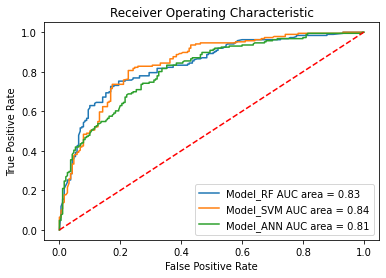

In [20]:
# Random forest
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)
performance_measures = model_training_and_validation(model_RF, "RF", splits)

# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
try:
    os.mkdir('results')
except:
    print("Directory already exists, continuing")
    
# SVM
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)
models.append({"label": "Model_SVM", "model": model_SVM})

# ANN
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=12)
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)
models.append({"label": "Model_ANN", "model": model_ANN})

# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

Our models show very good values for all measured values (see AUCs) and thus seem to be predictive.

**Cross-validation maccs**

In [21]:
N_FOLDS = 10
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.78 	and std : 0.02 
Mean sensitivity: 0.78 	and std : 0.04 
Mean specificity: 0.78 	and std : 0.04 
Mean AUC: 0.85 	and std : 0.03 
Time taken : 4.21s


Model_SVM
Mean accuracy: 0.79 	and std : 0.03 
Mean sensitivity: 0.79 	and std : 0.04 
Mean specificity: 0.78 	and std : 0.05 
Mean AUC: 0.85 	and std : 0.02 
Time taken : 18.03s


Model_ANN
Mean accuracy: 0.75 	and std : 0.03 
Mean sensitivity: 0.76 	and std : 0.06 
Mean specificity: 0.75 	and std : 0.05 
Mean AUC: 0.83 	and std : 0.03 
Time taken : 13.43s



All of the models seem to work nearly equally well. RF is slightly faster.

### Morgan FP cross validation

In [22]:
# Data processing, replacing the maccs fingerprints with morgan fingerprints.
compound_df = compound_df.drop(['fp'], axis=1)
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp, args=("morgan3",))

In [23]:
# Cross validation
for model in models:
    print("\n=======")
    print(model["label"])
    reduced_df = compound_df[['active','fp']]
    crossvalidation(model["model"], reduced_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.78 	and std : 0.02 
Mean sensitivity: 0.79 	and std : 0.04 
Mean specificity: 0.78 	and std : 0.04 
Mean AUC: 0.86 	and std : 0.02 
Time taken : 13.14s


Model_SVM
Mean accuracy: 0.76 	and std : 0.02 
Mean sensitivity: 0.67 	and std : 0.06 
Mean specificity: 0.85 	and std : 0.03 
Mean AUC: 0.81 	and std : 0.03 
Time taken : 140.49s


Model_ANN
Mean accuracy: 0.77 	and std : 0.03 
Mean sensitivity: 0.78 	and std : 0.05 
Mean specificity: 0.77 	and std : 0.04 
Mean AUC: 0.85 	and std : 0.03 
Time taken : 138.30s



The morgan fingerprint models seem to perform similarily to the maccs fingerprints. In this case RF is much fastr than SVM and ANN (although this might depend on the computer's hardware as running this script on a personal desktop showed ANN to be much faster).

#### RF regression
The random forest reggresion model is made here to predict the pChEMBL values. Initially RF seemed the best choice, but a different model type was used later. This section is kept here to be able to show the same results as in the presentation. The actual regression model comparison and the new round of predictions can be found after the docking section of this round.

In [24]:
#Data processing
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.pChEMBL_value.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))


#Kick out NaN in the pChEMBL values
compound_df_noNaN = compound_df.dropna()
#Create dictionary for later
CHEMBL_dic = compound_df_noNaN.set_index('Smiles').to_dict()['Molecule ChEMBL ID']
CHEMBL_smiles = compound_df_noNaN['Smiles'].tolist()

Training data size: 1504
Test data size: 376


In [25]:
MAE, RMSE,trained_model = crossvalidation_reg(RandomForestRegressor(), compound_df_noNaN, n_folds=3)

### Gathering compounds to screen with the regression model

To obtain a dataset of compounds to screen with the regression model, a few ligands were queried on pubchem. These so called query ligands were chosen to be representative for good TYK2 ligands. Among these are the reference ligand, two compounds with the highest pChEMBL values, and six compounds that are already on the market. These compounds were used to query a similarity search on pubchem with the following settings: <br>
- Similarity >= 90%
- XLogP <= 5
- Exact Mass <= 1000 <br>

In [26]:
#Dataframe of query compounds
query_df = pd.DataFrame({
    "ligand ID":["Reference_0X5",
                         "CHEMBL4789639",
                         "CHEMBL4793760",
                         "Deucravacitinib",
                         "Ruxolitinib",
                         "AT-9283",
                         "Peficitinib",
                         "Tofacitinib",
                         "Baricitinib"
                         ],
     "SMILES":['C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl', #0X5, PDB reference ligand
               '[2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC', #CHEMBL4789639
               '[2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC', #CHEMBL4793760
               '[2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC', #Deucravacitinib, TYK2
               'N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1', #Ruxolitinib, TYK2
               'O=C(Nc1c[nH]nc1-c1nc2ccc(CN3CCOCC3)cc2[nH]1)NC1CC1', #AT-9283, TYK2
               'NC(=O)c1cnc2[nH]ccc2c1N[C@H]1[C@H]2CC3C[C@@H]1C[C@](O)(C3)C2', #Peficitinib, TYK2
               'CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N', #Tofacitinib, JAK
               'CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1' #Baricitinib, TYK2
            ]})

#Creating a list of query compound smiles
querylist = query_df['SMILES'].tolist()

#Loop to query each smiles in the query list. Results are filtered 
screening = []
for query in querylist:
    print("\n\n\nCurrently querying smiles: {}.\n".format(query))
    #Query smiles
    job_key = query_pubchem_for_similar_compounds(query, threshold=90, n_records=10000)
    similar_cids = check_and_download(job_key)
    #Gather compound properties to filter
    a= pcp.get_properties(['canonical_smiles', 'XLogP', 'ExactMass'], similar_cids)
    a= pd.DataFrame.from_records(a).dropna()
    a['ExactMass'] = a['ExactMass'].astype(float)
    a[(a['XLogP'] <= 5) & (a['ExactMass'] <= 1000)]
    a=list(a['CanonicalSMILES'])
    #Add results to screening list
    screening.extend(a)
    print("\nThis query resulted in {} results,\nwhich makes the current amount of compounds in the screening dataset {}.".format(len(a),len(screening)))

print("\nThe amount of compounds currently in the screening dataset is: {}.".format(len(screening)))

print("\nA few examples are: \n{}, \n{},\n{}.".format(screening[1],screening[2],screening[3]))




Currently querying smiles: C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl.

Querying for job 1635428046281991115 at URL https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/1635428046281991115/cids/JSON....
This query resulted in 415 results,
which makes the current amount of compounds in the screening dataset 415.



Currently querying smiles: [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC.

Querying for job 2917360730223297988 at URL https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/2917360730223297988/cids/JSON....
This query resulted in 183 results,
which makes the current amount of compounds in the screening dataset 598.



Currently querying smiles: [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC.

Querying for job 4403635391727556302 at URL https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/4403635391727556302/cids/JSON....
This query resulted in 183 results,
which makes the current amount of compounds in th

#### Adding the queried compounds to the dataset and generating the fingerprints.
The smiles results from the similarity search are transfered to a testing dataset. The queried smiles are added to the front of this dataset to include them in the regression model's predictions. Each smiles will have a morgan3 fingerprint added.

In [27]:
test_smiles = screening.copy()
test_smiles = querylist+test_smiles  #this makes sure the queried compounds are being predicted as well, some but not all of them are already in this list, but duplicates are dropped anyways.
fps = []
drop = []

for smiles in test_smiles: 
    try:
        fp = smiles_to_fp(smiles,'morgan3')
        fps.append(fp)
    except:
        drop.append(smiles)
        
for i in drop:
    test_smiles.remove(i)

#### Making bioactivity predictions on the testing dataset
The testing dataset is put through the regression model to predict their pChEMBL values. An amount of the highest ranking smiles are gathered in the screened dataframe. This amount is set with *topslice*, which in this case is set to 10.<br><br> Because it is likely that there is one of the initial queried compounds from the ChEMBL dataset among the highest ranking smiles, there is a bit of code that removes them and replaces them with the next highest ranking smiles from the predicted dataset. The queried smiles are once again added to the final dataset to be able to compare them to the highest ranking smiles when docking.

In [28]:
#set number of highest predicted compounds you'd like in the dataset    
topslice=10

screened_df = pd.DataFrame()
pd.options.display.max_colwidth = 200
screened_df["smiles"] = test_smiles
predictions = trained_model.predict(fps)

screened_df["prediction"] = predictions
screened_df["prediction_type"] = "regression"
screened_df = screened_df.drop_duplicates(subset = 'smiles')
print("Excluding duplicates, a total of {} pChEMBL values have been predicted".format(len(screened_df)))
screened_df_full = screened_df.copy()
screened_df = screened_df.sort_values(by="prediction", ascending = False)[:topslice]
file = "SCREENEDDATA.csv"
screened_df.to_csv(file)

screened_data = screened_df.copy() #Alternatively use: pd.read_csv("SCREENEDDATA.csv")
display(screened_data)

#The first few indices are the queried compound, this code checks for duplicates in the top 5 predicted compounds and replaces them with the next highest predicted smiles
#nr of top predicted values to replace duplicate with
appendindex = topslice+1
while sum(screened_data.index<=(len(querylist)-1))>0:
    Index = screened_data.index[screened_data.index<(len(querylist)-1)][0] #index of the duplicate
    print(f"One of the top {len(screened_data)} predicted values ({query_df.iloc[Index][1]}) is one of the queried compounds: {query_df.iloc[Index][0]}, replacing it with the nr {appendindex} of the regression predicted smiles")
    screened_data = screened_data.drop(Index)
    screened_data = screened_data.append(screened_df_full.sort_values(by="prediction", ascending = False)[appendindex-1:appendindex]) #drop duplicate and append next highest predicted element
    appendindex += 1

#Creates list of ligand id's for the predicted values based, supports any number of predicted values
predicted_nr = []
for i in range(sum(screened_data.index>(len(querylist)-1))):
    predicted_nr.append("Predicted_nr"+str(i+1))

#adds queried ligands to dataframe
screened_data = screened_df_full[screened_df_full['smiles'].isin(querylist)].append(screened_data).drop_duplicates(subset = 'smiles')
identifiers = pd.DataFrame({"ligand ID": query_df['ligand ID'].append(pd.Series(predicted_nr)).reset_index(drop=True)})
screened_data["ligand ID"] = identifiers.values #names ligands
display(screened_data)
docking_smiles = screened_data['smiles']
print(docking_smiles)

Excluding duplicates, a total of 4033 pChEMBL values have been predicted


smiles  \
3      [2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC   
1083           CC1(COC1)NC2=NN=C(C(=C2)NC3=CC=CC(=C3OC)C4=NN(C=N4)C)C(=O)NC   
3414                          C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)O   
6              NC(=O)c1cnc2[nH]ccc2c1N[C@H]1[C@H]2CC3C[C@@H]1C[C@](O)(C3)C2   
2     [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC   
3591                        C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)C#N   
3593                     C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)C(=O)N   
3435                        CC12CC3CC(C1)C(C(C3)C2)NC4=C5C=CNC5=NC=C4C(=O)N   
3601                          C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)N   
3541                     C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)C(=O)O   

      prediction prediction_type  
3       8.808462      regression  
1083    8.347488      regression  
3414    8.303913      regression  
6       8.303913      regression  
2       8.284343      regression  
3591    8.253530      regression  
3593    8.251833      regression  
3435    8.249483      regression  
3601    8.247600      regression  
3541    8.239533      regression

One of the top 10 predicted values ([2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC) is one of the queried compounds: Deucravacitinib, replacing it with the nr 11 of the regression predicted smiles
One of the top 10 predicted values (NC(=O)c1cnc2[nH]ccc2c1N[C@H]1[C@H]2CC3C[C@@H]1C[C@](O)(C3)C2) is one of the queried compounds: Peficitinib, replacing it with the nr 12 of the regression predicted smiles
One of the top 10 predicted values ([2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC) is one of the queried compounds: CHEMBL4793760, replacing it with the nr 13 of the regression predicted smiles


smiles  \
0                           C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl   
1     [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC   
2     [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC   
3      [2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC   
4                              N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
5                        O=C(Nc1c[nH]nc1-c1nc2ccc(CN3CCOCC3)cc2[nH]1)NC1CC1   
6              NC(=O)c1cnc2[nH]ccc2c1N[C@H]1[C@H]2CC3C[C@@H]1C[C@](O)(C3)C2   
7                                 CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N   
8                       CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1   
1083           CC1(COC1)NC2=NN=C(C(=C2)NC3=CC=CC(=C3OC)C4=NN(C=N4)C)C(=O)NC   
3414                          C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)O   
3591                        C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)C#N   
3593                     C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)C(=O)N   
3435                        CC12CC3CC(C1)C(C(C3)C2)NC4=C5C=CNC5=NC=C4C(=O)N   
3601                          C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)N   
3541                     C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)C(=O)O   
3416                       COC12CC3CC(C1)C(C(C3)C2)NC4=C5C=CNC5=NC=C4C(=O)N   
3586                    CN(C)C12CC3CC(C1)C(C(C3)C2)NC4=C5C=CNC5=NC=C4C(=O)N   
3599               CN(C)C(=O)C12CC3CC(C1)C(C(C3)C2)NC4=C5C=CNC5=NC=C4C(=O)N   

      prediction prediction_type        ligand ID  
0       6.812411      regression    Reference_0X5  
1       7.952913      regression    CHEMBL4789639  
2       8.284343      regression    CHEMBL4793760  
3       8.808462      regression  Deucravacitinib  
4       7.906393      regression      Ruxolitinib  
5       8.071980      regression          AT-9283  
6       8.303913      regression      Peficitinib  
7       7.281540      regression      Tofacitinib  
8       7.377694      regression      Baricitinib  
1083    8.347488      regression    Predicted_nr1  
3414    8.303913      regression    Predicted_nr2  
3591    8.253530      regression    Predicted_nr3  
3593    8.251833      regression    Predicted_nr4  
3435    8.249483      regression    Predicted_nr5  
3601    8.247600      regression    Predicted_nr6  
3541    8.239533      regression    Predicted_nr7  
3416    8.221183      regression    Predicted_nr8  
3586    8.214583      regression    Predicted_nr9  
3599    8.196433      regression   Predicted_nr10

0                             C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl
1       [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC
2       [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC
3        [2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC
4                                N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1
5                          O=C(Nc1c[nH]nc1-c1nc2ccc(CN3CCOCC3)cc2[nH]1)NC1CC1
6                NC(=O)c1cnc2[nH]ccc2c1N[C@H]1[C@H]2CC3C[C@@H]1C[C@](O)(C3)C2
7                                   CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N
8                         CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1
1083             CC1(COC1)NC2=NN=C(C(=C2)NC3=CC=CC(=C3OC)C4=NN(C=N4)C)C(=O)NC
3414                            C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)O
3591                          C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)C#N
3593                       C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4

# Molecular docking


The 3D coordinates are generated for each of the smiles in the docking dataframe.

The first 9 ligands are from the querylist. The last 10 are the top 10 predicted ligands in descending order.


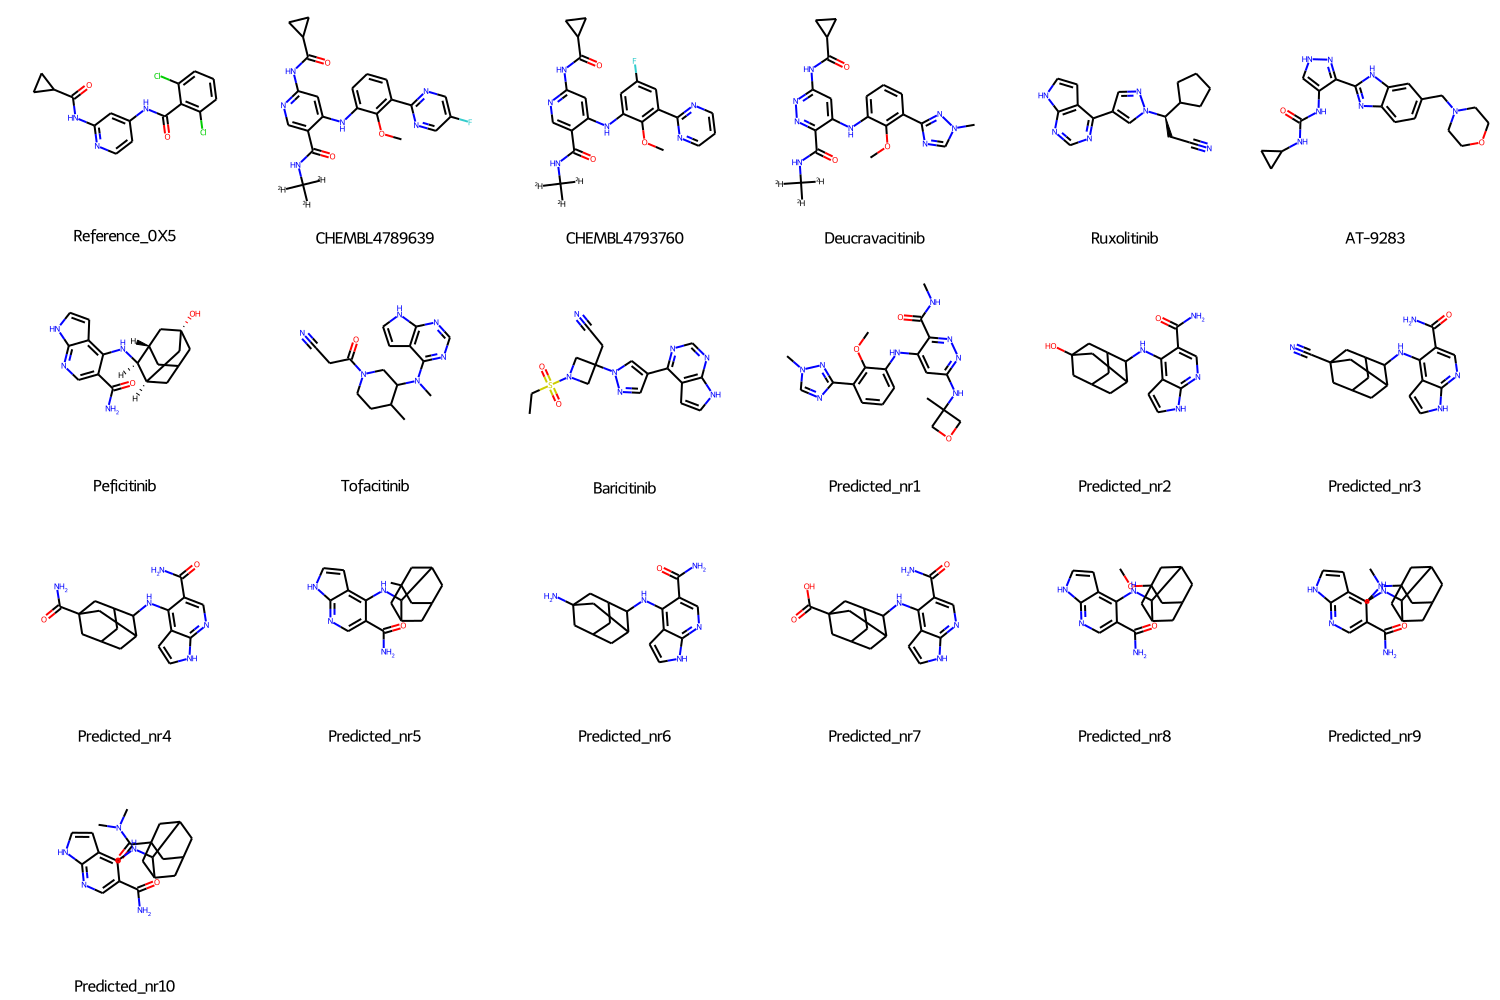

In [29]:
i = -1

IDs = []
for i in range(0,len(docking_smiles)):
    base = identifiers["ligand ID"][i]
    IDs.append(base)
    
df = pd.DataFrame({'ID':IDs, 'SMILES':docking_smiles})

df['rdkit_mol'] = [Chem.MolFromSmiles(s) for s in df['SMILES']]

# Generate 2D images of the molecules
img=Draw.MolsToGridImage(df['rdkit_mol'].tolist(),
                            molsPerRow=6,
                            subImgSize=(250,250),
                            legends=df['ID'].tolist())

for i in range(len(df)):
    row = df.iloc[i]
    mol = row['rdkit_mol']
    name = row['ID'] + '.mol'
    Chem.MolToMolFile(mol,name)

print("The first {} ligands are from the querylist. The last {} are the top {} predicted ligands in descending order.".format(len(querylist),sum(screened_data.index>(len(querylist)-1)),sum(screened_data.index>(len(querylist)-1))))
img


From the images it can be seen that all of the compounds with the highest predictions have a similar structure to peficitinib, except for predicted_nr 10.

#### Docking preparation

In [30]:
# Calculate the center based on the reference ligand
RadiusOfGyration = Rg('ligand-{}.pdb'.format(LIGAND_CODE))
print("Radius of Gyration = {}".format(RadiusOfGyration))

# Calculate center of geometry
CenterOfGeometry = COG('ligand-{}.pdb'.format(LIGAND_CODE))
print("Center Of Geometry = {}".format(CenterOfGeometry))

Radius of Gyration = 3.607
Center Of Geometry = [-7.964, -8.699, -16.866]


In [31]:
protein = Chem.MolFromPDBFile('{}_prepped.pdb'.format(TARGET_PDB_ID))
a = MolToPDBQTBlock(protein,flexible=False)
with open('protein.pdbqt','w') as outfile:
    for line in a:
        outfile.write(line)

In [32]:
docking_smiles

0                             C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl
1       [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC
2       [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC
3        [2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC
4                                N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1
5                          O=C(Nc1c[nH]nc1-c1nc2ccc(CN3CCOCC3)cc2[nH]1)NC1CC1
6                NC(=O)c1cnc2[nH]ccc2c1N[C@H]1[C@H]2CC3C[C@@H]1C[C@](O)(C3)C2
7                                   CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N
8                         CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1
1083             CC1(COC1)NC2=NN=C(C(=C2)NC3=CC=CC(=C3OC)C4=NN(C=N4)C)C(=O)NC
3414                            C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)O
3591                          C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)C#N
3593                       C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4

#### Docking the smiles to the protein

In this step the queried compounds and top regression compounds are docked to the protein. The settings for this docking are:
- Seed = 1
- Exhaustiveness = 20
- N_poses = 40.<br><br>
This step takes a while so it is also possible to load the pre-docked csv file.

In [33]:
if Load_data == True:
    print("Loading previous dataset")
    complete_data = pd.read_csv("complete_data_10_compounds_20_40.csv")
else:
    df_cols = {'ligand ID':[], 'vina_affinity': [],"prediction": [], 'prediction_type': [], 'exhaustiveness': [], 'n_poses': []}
    docked_ligands = pd.DataFrame(data=df_cols)

    for ID in df['ID']:
        print(f"\nDocking ligand ID: {ID}\n")
        for i in range(1,2,1):
            LIGAND_TO_DOCK = ID 
            m = Chem.MolFromMolFile('{}.mol'.format(LIGAND_TO_DOCK))
            a = MolToPDBQTBlock(m)
            with open('{}.pdbqt'.format(LIGAND_TO_DOCK), 'w') as outfile:
                for line in a:
                    outfile.write(line)

            v = Vina(sf_name='vina', seed = SEED)

            v.set_receptor('protein.pdbqt')

            v.set_ligand_from_file('{}.pdbqt'.format(LIGAND_TO_DOCK))

            center = {
                 'center_x' : CenterOfGeometry[0], 
                 'center_y' : CenterOfGeometry[1], 
                 'center_z' : CenterOfGeometry[2]

            }

            size = { 
                'size_x' : RadiusOfGyration * 2.9 ,
                'size_y' : RadiusOfGyration * 2.9,
                'size_z' : RadiusOfGyration * 2.9,           
                       }


            v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                                box_size=[size['size_x'], size['size_y'], size['size_z']])

            '''
            # Score the current pose
            energy = v.score()
            print('Score before minimization: %.3f (kcal/mol)' % energy[0])

            # Minimized locally the current pose
            energy_minimized = v.optimize()
            print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
            v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
            '''

            # Dock the ligand
            v.dock(exhaustiveness=20, n_poses=40)
            v.write_poses('docking_results.pdbqt', n_poses=1, overwrite=True)

            # Create a mol object from the docking results, write the mol to file and print the predicted affinity
            mol = MolFromPDBQTBlock('docking_results.pdbqt',sanitize=False)
            Chem.rdmolfiles.MolToPDBFile(mol, '{}_docked.pdb'.format(LIGAND_TO_DOCK))
            Ki = (math.exp(float(mol.GetProp('vina_affinity'))/0.592))
            pKi = -math.log10(Ki)
            pChEMBL = pKi
            print('The affinity predicted by Vina = {} (kcal/mol)'.format(mol.GetProp('vina_affinity')))
            print('Which (approximately) corresponds to a pChEMBL of {:.2f}'.format(pKi))
            docked_ligands.loc[len(docked_ligands)] = [LIGAND_TO_DOCK, mol.GetProp('vina_affinity'), pChEMBL, "docking", 20, 40]
            


    print(docked_ligands)


    docked_ligands['smiles'] = docking_smiles.to_list()
    complete_data = screened_data.append(docked_ligands).reset_index(drop=True)
    #warning this code depends on querylist, i do not know a dynamic way to code this (well i havent looked it up yet)
    chembldata=compound_df_noNaN.query('Smiles in @querylist')
    chembldata['prediction_type'] = "actual"
    chembldata['prediction'] = chembldata["pChEMBL_value"]
    chembldata['smiles'] = chembldata["Smiles"]
    chembldata = chembldata.drop(['fp', "Assay_Type", "Standard Relation", "Standard Value", "active", "Smiles", "pChEMBL_value"], axis =1)
    complete_data = complete_data.append(chembldata)
    complete_data['ligand ID'] = complete_data['smiles'].map(docked_ligands.set_index('smiles').to_dict()['ligand ID'])
    complete_data['Molecule ChEMBL ID'] = complete_data['smiles'].map(chembldata.set_index('smiles').to_dict()['Molecule ChEMBL ID'])
    complete_data.to_csv("complete_data_10_compounds_20_40.csv", index=False)
    
display(complete_data)


Loading previous dataset


smiles  \
0                         C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl   
1   [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC   
2   [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC   
3    [2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC   
4                            N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
..                                                                    ...   
62                    CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1   
63   [2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC   
64  [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC   
65  [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC   
66                    CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1   

    prediction prediction_type        ligand ID  vina_affinity  \
0     6.812411      regression    Reference_0X5            NaN   
1     7.952913      regression    CHEMBL4789639            NaN   
2     8.284343      regression    CHEMBL4793760            NaN   
3     8.808462      regression  Deucravacitinib            NaN   
4     7.906393      regression      Ruxolitinib            NaN   
..         ...             ...              ...            ...   
62    7.280000          actual      Baricitinib            NaN   
63    8.050000          actual  Deucravacitinib            NaN   
64    8.000000          actual    CHEMBL4789639            NaN   
65    9.720000          actual    CHEMBL4789639            NaN   
66    7.210000          actual      Baricitinib            NaN   

    exhaustiveness  n_poses Molecule ChEMBL ID  
0              NaN      NaN                NaN  
1              NaN      NaN      CHEMBL4789639  
2              NaN      NaN      CHEMBL4793760  
3              NaN      NaN      CHEMBL4435170  
4              NaN      NaN      CHEMBL1789941  
..             ...      ...                ...  
62             NaN      NaN      CHEMBL2105759  
63             NaN      NaN      CHEMBL4435170  
64             NaN      NaN      CHEMBL4789639  
65             NaN      NaN      CHEMBL4789639  
66             NaN      NaN      CHEMBL2105759  

[67 rows x 8 columns]

The dataframe is saved with a timestamp because the code takes a while as it usually runs in the background. This makes sure that the results are saved after docking and to preserve the data for each attempt.

In [34]:
complete_data.to_csv("complete_data"+time.asctime( time.localtime(time.time()))+".csv")

### Docking results

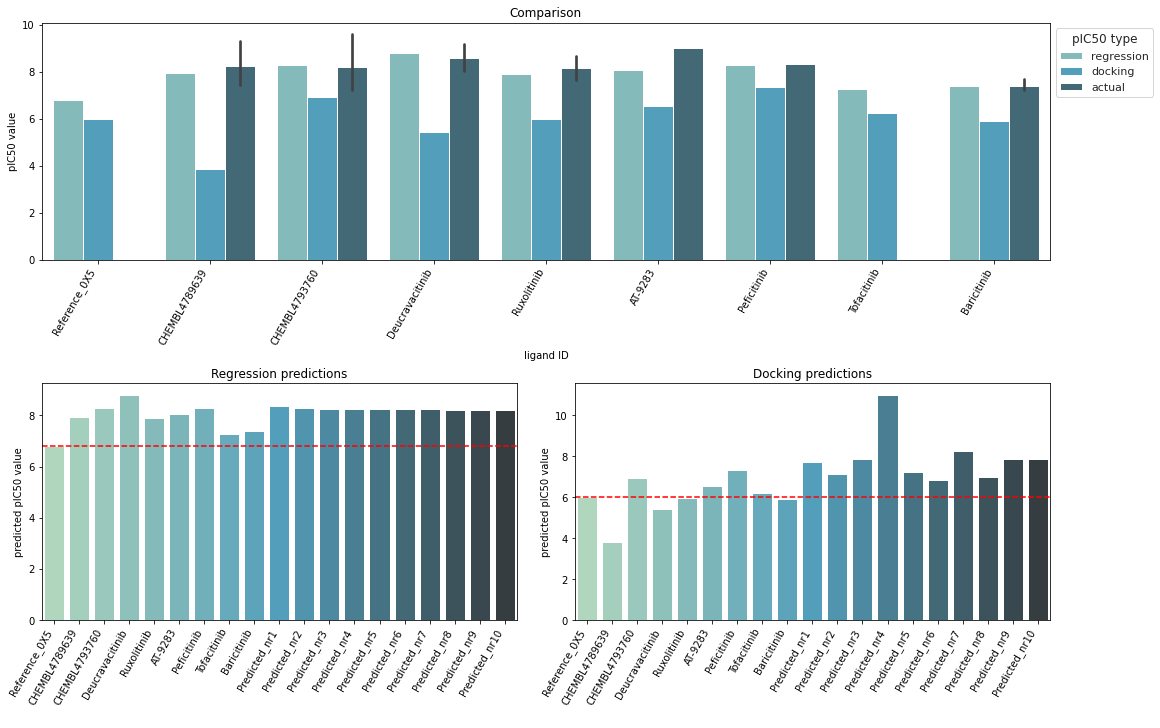

In [35]:
#Create subplot
fig = plt.figure(constrained_layout=True)
axes = fig.subplot_mosaic([['Top', 'Top'],['BottomLeft', 'BottomRight']],
                          gridspec_kw={'width_ratios':[1, 1]},)
fig.set_size_inches(16, 10)

sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

#Plot to compare regression predictions
plt.sca(axes['BottomLeft'])
sns.barplot(
    data=complete_data[complete_data['prediction_type']=="regression"],
    x="ligand ID", y="prediction", palette="GnBu_d"
)

plt.xticks(rotation=60, ha='right')
axes['BottomLeft'].set(title = "Regression predictions",
       xlabel = " ",
       ylabel = "predicted pIC50 value")
axes['BottomLeft'].axhline(
    complete_data.query('`ligand ID` == "Reference_0X5" and prediction_type == "regression"')['prediction'].values[0],
    ls='--', c='red')


#Plot to compare docking predictions
plt.sca(axes['BottomRight'])
sns.barplot(
    data=complete_data[complete_data['prediction_type']=="docking"],
    x="ligand ID", y="prediction", palette="GnBu_d"
)

plt.xticks(rotation=60, ha='right')
axes['BottomRight'].set(title = "Docking predictions",
       xlabel = " ",
       ylabel = "predicted pIC50 value")
axes['BottomRight'].axhline(
    complete_data.query('`ligand ID` == "Reference_0X5" and prediction_type == "docking"')['prediction'].values[0],
    ls='--', c='red')

#Top plot to compare prediction types
plt.sca(axes['Top'])
sns.barplot(
    data=complete_data.query('smiles in @querylist'),
    x="ligand ID", y="prediction", hue="prediction_type", palette="GnBu_d"
)
plt.xticks(rotation=60, ha='right')
axes['Top'].set(title = "Comparison",
       ylabel = "pIC50 value")
axes['Top'].legend(title='pIC50 type',loc=2, bbox_to_anchor=(1,1))

#saves the plots
plt.savefig("plots.png", dpi=400);

From this plot it can be seen that the regression predictions are usually close to the actual values. This is expected because the model is trained on this. The docking predictions are not as close to the actual values as the regression predictions and tend to be lower.<br><br>
All of the compounds have a higher predicted pChEMBL value compared to the reference ligand 0X5. On the other hand, not all compounds have a higher value when predicted with the docking score. However, all of the predicted compound were higher, with Predicted_nr4 having a value above 10.

In [36]:
#for an overview of the ligand id's
df['ID'].values

array(['Reference_0X5', 'CHEMBL4789639', 'CHEMBL4793760',
       'Deucravacitinib', 'Ruxolitinib', 'AT-9283', 'Peficitinib',
       'Tofacitinib', 'Baricitinib', 'Predicted_nr1', 'Predicted_nr2',
       'Predicted_nr3', 'Predicted_nr4', 'Predicted_nr5', 'Predicted_nr6',
       'Predicted_nr7', 'Predicted_nr8', 'Predicted_nr9',
       'Predicted_nr10'], dtype=object)

#### Comparison of the reference ligand and the highest scoring docked compound

In [37]:
LIGAND_TO_SHOW = 'Predicted_nr4'
print(f"Showing {LIGAND_TO_SHOW}")
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(TARGET_PDB_ID),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = 'Predicted_nr4_docked.pdb'
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

Showing Predicted_nr4
Reference: Magenta | Vina Pose: Cyan


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The nr 4 predicted compound fits well inside of the binding pocket. It mostly occupies the same space as the reference ligand.

#### The highest scoring compound alongside its parental (by similiarity) compound

In [38]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(TARGET_PDB_ID),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'Peficitinib_docked.pdb'
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = 'Predicted_nr4_docked.pdb'
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Peficitinib: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

Peficitinib: Magenta | Vina Pose: Cyan


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The nr 4 predicted compound and peficitinib have a lot in common regarding their molecular structure. It is therefore no surprise to see that they have been docked in a very similar way.

#### Showing the docked compound alongside the binding site's residues

In [39]:
# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(TARGET_PDB_ID),
'{}_docked.pdb'.format(LIGAND_TO_SHOW)
]
with open('{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)
                    
with open('{}-complex.pdb'.format(TARGET_PDB_ID)) as f:
    view_screened = nglview.show_file(f, ext="pdb")
    
view.center("UNL")
viewer.show_residues_around(view_screened, selection="UNL")
view_screened

NGLWidget()

The compound's joint rings are near the hydrophobic center of the binding pocket and the nitrogen rings near polar residues, so it looks like a good fit. One thing to note is that the joint ring/cage structure of the compound is not shown well in the ngl viewer. It seems like carbon nr 1 has a total of 5 bonds. This compound might therefore not be the best candidate to compare against the reference ligand as the docking might not have been correct. Alternatively, predicted nr 1 does not have this kind of structure so this one could be an alternative.

In [40]:
LIGAND_TO_SHOW = 'Predicted_nr1'
print(f"Showing {LIGAND_TO_SHOW}")
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(TARGET_PDB_ID),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = 'Predicted_nr1_docked.pdb'
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()


# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(TARGET_PDB_ID),
'{}_docked.pdb'.format(LIGAND_TO_SHOW)
]
with open('{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)
                    
with open('{}-complex.pdb'.format(TARGET_PDB_ID)) as f:
    view_screened = nglview.show_file(f, ext="pdb")
    
view.center("UNL")
viewer.show_residues_around(view_screened, selection="UNL")
view_screened

Showing Predicted_nr1
Reference: Magenta | Vina Pose: Cyan


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

NGLWidget()

This compound is in a similar position as the reference ligand. It differs with two branches at one end of which one is further into the protein's binding pocket and the other extends to the outside of the protein. There are also plenty of possible interactions with the protein's residues. Therefore for this round of docking this would be the compound that beats the reference ligand.

<br>

# Round 2 of predictions
In this round we try to improve the workflow, or just increase the scope, of the data gathering, regression predictions, and docking. Most steps take a very long time but there are saved dataframes that can be loaded to skip these steps.

### Regressor comparison
Here several regression models are compared: random forest, support vector, multi layer perceptron, k nearest neighbours, gradient boost, cat boost, and stochastic gradient descent. N_folds is set to 20 so this step takes a while.

In [41]:
N_FOLDSR = 20

regressor_cross_validation = pd.DataFrame({        
        "Model name":[],
        "MAE": [],
        "MAE std":[],
        "RMSE":[],
        "RMSE std":[],
        "Time":[],
        "n_folds":[],
        "trained_model":[]})

model_names = ["RF","SVR","MLP","KN","GB","CB","SGD"]
regression_type = [RandomForestRegressor(random_state=SEED),
                   SVR(),
                   MLPRegressor(random_state=SEED),
                   KNeighborsRegressor(),
                   GradientBoostingRegressor(random_state=SEED, max_depth = 10),
                   CatBoostRegressor(random_state=SEED),
                   SGDRegressor(random_state=SEED)]

for count, model in enumerate(regression_type):
    print(f"Trying model {model_names[count]}")
    start_time = time.time()
    MAE, RMSE, trained_model = crossvalidation_reg(model , compound_df_noNaN, n_folds=N_FOLDSR)
    model_time=(time.time() - start_time)
    regressor_cross_validation=regressor_cross_validation.append({
        "Model name":model_names[count],
        "MAE": np.mean(MAE),
        "MAE std":np.std(MAE),
        "RMSE":np.mean(RMSE),
        "RMSE std":np.std(RMSE),
        "Time":model_time,
        "n_folds":int(N_FOLDSR),
        "trained_model":trained_model},ignore_index=True)
    
print("Finished")

Trying model RF
Trying model SVR
Trying model MLP
Trying model KN
Trying model GB
Trying model CB
Learning rate set to 0.042921
0:	learn: 0.9644386	total: 58.4ms	remaining: 58.3s
1:	learn: 0.9577031	total: 68.1ms	remaining: 34s
2:	learn: 0.9498025	total: 77.6ms	remaining: 25.8s
3:	learn: 0.9416097	total: 87.3ms	remaining: 21.7s
4:	learn: 0.9351164	total: 97ms	remaining: 19.3s
5:	learn: 0.9279230	total: 106ms	remaining: 17.6s
6:	learn: 0.9210319	total: 116ms	remaining: 16.4s
7:	learn: 0.9152555	total: 125ms	remaining: 15.6s
8:	learn: 0.9085770	total: 135ms	remaining: 14.9s
9:	learn: 0.9034238	total: 145ms	remaining: 14.3s
10:	learn: 0.8991301	total: 154ms	remaining: 13.8s
11:	learn: 0.8932226	total: 163ms	remaining: 13.5s
12:	learn: 0.8880336	total: 173ms	remaining: 13.1s
13:	learn: 0.8829782	total: 183ms	remaining: 12.9s
14:	learn: 0.8778476	total: 192ms	remaining: 12.6s
15:	learn: 0.8740552	total: 202ms	remaining: 12.4s
16:	learn: 0.8686304	total: 211ms	remaining: 12.2s
17:	learn: 0.8

161:	learn: 0.6628018	total: 1.6s	remaining: 8.27s
162:	learn: 0.6620308	total: 1.61s	remaining: 8.26s
163:	learn: 0.6614708	total: 1.62s	remaining: 8.24s
164:	learn: 0.6607955	total: 1.63s	remaining: 8.23s
165:	learn: 0.6604130	total: 1.64s	remaining: 8.22s
166:	learn: 0.6602189	total: 1.64s	remaining: 8.2s
167:	learn: 0.6597356	total: 1.66s	remaining: 8.21s
168:	learn: 0.6589866	total: 1.67s	remaining: 8.2s
169:	learn: 0.6584212	total: 1.68s	remaining: 8.19s
170:	learn: 0.6578273	total: 1.69s	remaining: 8.18s
171:	learn: 0.6571815	total: 1.7s	remaining: 8.16s
172:	learn: 0.6563969	total: 1.71s	remaining: 8.15s
173:	learn: 0.6555854	total: 1.71s	remaining: 8.14s
174:	learn: 0.6549342	total: 1.72s	remaining: 8.12s
175:	learn: 0.6545041	total: 1.73s	remaining: 8.11s
176:	learn: 0.6539071	total: 1.74s	remaining: 8.1s
177:	learn: 0.6533396	total: 1.75s	remaining: 8.09s
178:	learn: 0.6518898	total: 1.76s	remaining: 8.08s
179:	learn: 0.6511991	total: 1.77s	remaining: 8.07s
180:	learn: 0.650

331:	learn: 0.5847750	total: 3.23s	remaining: 6.5s
332:	learn: 0.5845121	total: 3.24s	remaining: 6.49s
333:	learn: 0.5841791	total: 3.25s	remaining: 6.48s
334:	learn: 0.5838987	total: 3.26s	remaining: 6.47s
335:	learn: 0.5835875	total: 3.27s	remaining: 6.46s
336:	learn: 0.5832008	total: 3.28s	remaining: 6.45s
337:	learn: 0.5829999	total: 3.29s	remaining: 6.44s
338:	learn: 0.5824914	total: 3.3s	remaining: 6.43s
339:	learn: 0.5823673	total: 3.31s	remaining: 6.42s
340:	learn: 0.5821982	total: 3.32s	remaining: 6.41s
341:	learn: 0.5817337	total: 3.33s	remaining: 6.4s
342:	learn: 0.5816360	total: 3.34s	remaining: 6.39s
343:	learn: 0.5812492	total: 3.35s	remaining: 6.38s
344:	learn: 0.5811549	total: 3.36s	remaining: 6.37s
345:	learn: 0.5809548	total: 3.37s	remaining: 6.36s
346:	learn: 0.5805922	total: 3.38s	remaining: 6.35s
347:	learn: 0.5801353	total: 3.38s	remaining: 6.34s
348:	learn: 0.5797318	total: 3.39s	remaining: 6.33s
349:	learn: 0.5793890	total: 3.4s	remaining: 6.32s
350:	learn: 0.57

503:	learn: 0.5364722	total: 4.88s	remaining: 4.8s
504:	learn: 0.5362414	total: 4.88s	remaining: 4.79s
505:	learn: 0.5360191	total: 4.89s	remaining: 4.78s
506:	learn: 0.5358292	total: 4.9s	remaining: 4.77s
507:	learn: 0.5357541	total: 4.91s	remaining: 4.76s
508:	learn: 0.5355313	total: 4.92s	remaining: 4.75s
509:	learn: 0.5353494	total: 4.93s	remaining: 4.74s
510:	learn: 0.5351734	total: 4.94s	remaining: 4.73s
511:	learn: 0.5350301	total: 4.95s	remaining: 4.72s
512:	learn: 0.5347863	total: 4.96s	remaining: 4.71s
513:	learn: 0.5345021	total: 4.97s	remaining: 4.7s
514:	learn: 0.5343948	total: 4.98s	remaining: 4.69s
515:	learn: 0.5341705	total: 4.99s	remaining: 4.68s
516:	learn: 0.5339266	total: 5s	remaining: 4.67s
517:	learn: 0.5337303	total: 5.01s	remaining: 4.66s
518:	learn: 0.5335755	total: 5.02s	remaining: 4.65s
519:	learn: 0.5332627	total: 5.03s	remaining: 4.64s
520:	learn: 0.5330457	total: 5.04s	remaining: 4.63s
521:	learn: 0.5329702	total: 5.05s	remaining: 4.62s
522:	learn: 0.5327

675:	learn: 0.5082778	total: 6.52s	remaining: 3.13s
676:	learn: 0.5081543	total: 6.53s	remaining: 3.12s
677:	learn: 0.5080217	total: 6.54s	remaining: 3.1s
678:	learn: 0.5079213	total: 6.55s	remaining: 3.1s
679:	learn: 0.5076993	total: 6.56s	remaining: 3.09s
680:	learn: 0.5076649	total: 6.57s	remaining: 3.08s
681:	learn: 0.5074817	total: 6.58s	remaining: 3.07s
682:	learn: 0.5072950	total: 6.59s	remaining: 3.06s
683:	learn: 0.5071294	total: 6.59s	remaining: 3.05s
684:	learn: 0.5070716	total: 6.6s	remaining: 3.04s
685:	learn: 0.5069534	total: 6.61s	remaining: 3.03s
686:	learn: 0.5067026	total: 6.62s	remaining: 3.02s
687:	learn: 0.5064528	total: 6.63s	remaining: 3.01s
688:	learn: 0.5062732	total: 6.64s	remaining: 3s
689:	learn: 0.5061418	total: 6.65s	remaining: 2.99s
690:	learn: 0.5060421	total: 6.66s	remaining: 2.98s
691:	learn: 0.5058359	total: 6.67s	remaining: 2.97s
692:	learn: 0.5056933	total: 6.68s	remaining: 2.96s
693:	learn: 0.5056053	total: 6.69s	remaining: 2.95s
694:	learn: 0.5055

846:	learn: 0.4879659	total: 8.16s	remaining: 1.47s
847:	learn: 0.4878791	total: 8.17s	remaining: 1.46s
848:	learn: 0.4877460	total: 8.18s	remaining: 1.45s
849:	learn: 0.4876591	total: 8.19s	remaining: 1.44s
850:	learn: 0.4875691	total: 8.19s	remaining: 1.43s
851:	learn: 0.4874374	total: 8.21s	remaining: 1.43s
852:	learn: 0.4873744	total: 8.22s	remaining: 1.42s
853:	learn: 0.4873105	total: 8.23s	remaining: 1.41s
854:	learn: 0.4872436	total: 8.23s	remaining: 1.4s
855:	learn: 0.4871290	total: 8.24s	remaining: 1.39s
856:	learn: 0.4870248	total: 8.25s	remaining: 1.38s
857:	learn: 0.4869298	total: 8.26s	remaining: 1.37s
858:	learn: 0.4868664	total: 8.27s	remaining: 1.36s
859:	learn: 0.4867413	total: 8.28s	remaining: 1.35s
860:	learn: 0.4866398	total: 8.29s	remaining: 1.34s
861:	learn: 0.4865165	total: 8.3s	remaining: 1.33s
862:	learn: 0.4864232	total: 8.31s	remaining: 1.32s
863:	learn: 0.4862902	total: 8.32s	remaining: 1.31s
864:	learn: 0.4862239	total: 8.33s	remaining: 1.3s
865:	learn: 0.4

18:	learn: 0.8504504	total: 182ms	remaining: 9.4s
19:	learn: 0.8467313	total: 192ms	remaining: 9.4s
20:	learn: 0.8434934	total: 202ms	remaining: 9.4s
21:	learn: 0.8401950	total: 211ms	remaining: 9.4s
22:	learn: 0.8369241	total: 221ms	remaining: 9.39s
23:	learn: 0.8331973	total: 231ms	remaining: 9.38s
24:	learn: 0.8299755	total: 240ms	remaining: 9.36s
25:	learn: 0.8270481	total: 251ms	remaining: 9.4s
26:	learn: 0.8233536	total: 261ms	remaining: 9.39s
27:	learn: 0.8192203	total: 270ms	remaining: 9.38s
28:	learn: 0.8171071	total: 280ms	remaining: 9.36s
29:	learn: 0.8148062	total: 289ms	remaining: 9.34s
30:	learn: 0.8119378	total: 298ms	remaining: 9.33s
31:	learn: 0.8096579	total: 308ms	remaining: 9.32s
32:	learn: 0.8079662	total: 318ms	remaining: 9.3s
33:	learn: 0.8047124	total: 327ms	remaining: 9.3s
34:	learn: 0.8010996	total: 337ms	remaining: 9.3s
35:	learn: 0.7986457	total: 350ms	remaining: 9.37s
36:	learn: 0.7966613	total: 360ms	remaining: 9.36s
37:	learn: 0.7934663	total: 369ms	remai

184:	learn: 0.6430340	total: 1.82s	remaining: 8.03s
185:	learn: 0.6423656	total: 1.83s	remaining: 8.03s
186:	learn: 0.6414418	total: 1.84s	remaining: 8.02s
187:	learn: 0.6406883	total: 1.85s	remaining: 8.01s
188:	learn: 0.6401391	total: 1.86s	remaining: 8s
189:	learn: 0.6390193	total: 1.87s	remaining: 7.98s
190:	learn: 0.6383886	total: 1.88s	remaining: 7.97s
191:	learn: 0.6375708	total: 1.89s	remaining: 7.96s
192:	learn: 0.6367827	total: 1.9s	remaining: 7.95s
193:	learn: 0.6361652	total: 1.91s	remaining: 7.94s
194:	learn: 0.6357336	total: 1.92s	remaining: 7.93s
195:	learn: 0.6351004	total: 1.93s	remaining: 7.91s
196:	learn: 0.6346087	total: 1.94s	remaining: 7.9s
197:	learn: 0.6341682	total: 1.95s	remaining: 7.89s
198:	learn: 0.6334368	total: 1.96s	remaining: 7.88s
199:	learn: 0.6329437	total: 1.97s	remaining: 7.87s
200:	learn: 0.6323948	total: 1.98s	remaining: 7.86s
201:	learn: 0.6315160	total: 1.99s	remaining: 7.84s
202:	learn: 0.6309934	total: 1.99s	remaining: 7.83s
203:	learn: 0.630

354:	learn: 0.5676696	total: 3.46s	remaining: 6.29s
355:	learn: 0.5672912	total: 3.47s	remaining: 6.28s
356:	learn: 0.5668699	total: 3.48s	remaining: 6.27s
357:	learn: 0.5664689	total: 3.49s	remaining: 6.26s
358:	learn: 0.5661116	total: 3.5s	remaining: 6.25s
359:	learn: 0.5657630	total: 3.51s	remaining: 6.24s
360:	learn: 0.5653567	total: 3.52s	remaining: 6.23s
361:	learn: 0.5647943	total: 3.53s	remaining: 6.22s
362:	learn: 0.5643976	total: 3.54s	remaining: 6.21s
363:	learn: 0.5638380	total: 3.55s	remaining: 6.2s
364:	learn: 0.5634470	total: 3.56s	remaining: 6.19s
365:	learn: 0.5630931	total: 3.57s	remaining: 6.18s
366:	learn: 0.5626144	total: 3.58s	remaining: 6.17s
367:	learn: 0.5623125	total: 3.58s	remaining: 6.16s
368:	learn: 0.5621986	total: 3.6s	remaining: 6.15s
369:	learn: 0.5618329	total: 3.6s	remaining: 6.14s
370:	learn: 0.5613043	total: 3.61s	remaining: 6.13s
371:	learn: 0.5608536	total: 3.62s	remaining: 6.12s
372:	learn: 0.5607498	total: 3.63s	remaining: 6.11s
373:	learn: 0.56

524:	learn: 0.5223111	total: 5.11s	remaining: 4.62s
525:	learn: 0.5222390	total: 5.12s	remaining: 4.62s
526:	learn: 0.5221749	total: 5.13s	remaining: 4.61s
527:	learn: 0.5221164	total: 5.14s	remaining: 4.59s
528:	learn: 0.5219473	total: 5.15s	remaining: 4.58s
529:	learn: 0.5217632	total: 5.16s	remaining: 4.58s
530:	learn: 0.5216726	total: 5.17s	remaining: 4.57s
531:	learn: 0.5213920	total: 5.18s	remaining: 4.56s
532:	learn: 0.5213401	total: 5.19s	remaining: 4.55s
533:	learn: 0.5212714	total: 5.2s	remaining: 4.54s
534:	learn: 0.5210692	total: 5.21s	remaining: 4.53s
535:	learn: 0.5209110	total: 5.22s	remaining: 4.51s
536:	learn: 0.5207795	total: 5.22s	remaining: 4.5s
537:	learn: 0.5206934	total: 5.24s	remaining: 4.5s
538:	learn: 0.5204189	total: 5.24s	remaining: 4.49s
539:	learn: 0.5203640	total: 5.25s	remaining: 4.47s
540:	learn: 0.5202882	total: 5.26s	remaining: 4.46s
541:	learn: 0.5200242	total: 5.27s	remaining: 4.46s
542:	learn: 0.5199752	total: 5.28s	remaining: 4.45s
543:	learn: 0.5

694:	learn: 0.4963453	total: 6.76s	remaining: 2.96s
695:	learn: 0.4961899	total: 6.77s	remaining: 2.96s
696:	learn: 0.4960669	total: 6.78s	remaining: 2.95s
697:	learn: 0.4960181	total: 6.79s	remaining: 2.94s
698:	learn: 0.4958989	total: 6.8s	remaining: 2.93s
699:	learn: 0.4957508	total: 6.81s	remaining: 2.92s
700:	learn: 0.4956518	total: 6.82s	remaining: 2.91s
701:	learn: 0.4955807	total: 6.83s	remaining: 2.9s
702:	learn: 0.4955208	total: 6.84s	remaining: 2.89s
703:	learn: 0.4953224	total: 6.85s	remaining: 2.88s
704:	learn: 0.4951445	total: 6.86s	remaining: 2.87s
705:	learn: 0.4950104	total: 6.87s	remaining: 2.86s
706:	learn: 0.4949184	total: 6.88s	remaining: 2.85s
707:	learn: 0.4947050	total: 6.89s	remaining: 2.84s
708:	learn: 0.4945708	total: 6.9s	remaining: 2.83s
709:	learn: 0.4944602	total: 6.91s	remaining: 2.82s
710:	learn: 0.4944032	total: 6.92s	remaining: 2.81s
711:	learn: 0.4942563	total: 6.93s	remaining: 2.8s
712:	learn: 0.4941397	total: 6.94s	remaining: 2.79s
713:	learn: 0.49

859:	learn: 0.4781592	total: 8.38s	remaining: 1.36s
860:	learn: 0.4780055	total: 8.39s	remaining: 1.35s
861:	learn: 0.4779658	total: 8.4s	remaining: 1.34s
862:	learn: 0.4778532	total: 8.41s	remaining: 1.33s
863:	learn: 0.4777375	total: 8.42s	remaining: 1.32s
864:	learn: 0.4776281	total: 8.43s	remaining: 1.32s
865:	learn: 0.4775541	total: 8.44s	remaining: 1.31s
866:	learn: 0.4774841	total: 8.45s	remaining: 1.3s
867:	learn: 0.4773763	total: 8.46s	remaining: 1.29s
868:	learn: 0.4773201	total: 8.47s	remaining: 1.28s
869:	learn: 0.4772017	total: 8.48s	remaining: 1.27s
870:	learn: 0.4770724	total: 8.49s	remaining: 1.26s
871:	learn: 0.4770275	total: 8.5s	remaining: 1.25s
872:	learn: 0.4769244	total: 8.51s	remaining: 1.24s
873:	learn: 0.4767655	total: 8.52s	remaining: 1.23s
874:	learn: 0.4766977	total: 8.53s	remaining: 1.22s
875:	learn: 0.4766735	total: 8.54s	remaining: 1.21s
876:	learn: 0.4766171	total: 8.55s	remaining: 1.2s
877:	learn: 0.4765482	total: 8.56s	remaining: 1.19s
878:	learn: 0.47

17:	learn: 0.8632099	total: 189ms	remaining: 10.3s
18:	learn: 0.8600900	total: 199ms	remaining: 10.3s
19:	learn: 0.8560093	total: 210ms	remaining: 10.3s
20:	learn: 0.8513668	total: 222ms	remaining: 10.3s
21:	learn: 0.8478110	total: 232ms	remaining: 10.3s
22:	learn: 0.8449162	total: 243ms	remaining: 10.3s
23:	learn: 0.8417179	total: 253ms	remaining: 10.3s
24:	learn: 0.8390381	total: 263ms	remaining: 10.3s
25:	learn: 0.8360375	total: 273ms	remaining: 10.2s
26:	learn: 0.8333726	total: 283ms	remaining: 10.2s
27:	learn: 0.8312213	total: 293ms	remaining: 10.2s
28:	learn: 0.8288174	total: 303ms	remaining: 10.1s
29:	learn: 0.8265349	total: 313ms	remaining: 10.1s
30:	learn: 0.8233792	total: 324ms	remaining: 10.1s
31:	learn: 0.8203878	total: 341ms	remaining: 10.3s
32:	learn: 0.8175657	total: 351ms	remaining: 10.3s
33:	learn: 0.8152859	total: 361ms	remaining: 10.2s
34:	learn: 0.8125572	total: 371ms	remaining: 10.2s
35:	learn: 0.8106579	total: 381ms	remaining: 10.2s
36:	learn: 0.8083080	total: 391

190:	learn: 0.6563268	total: 2.04s	remaining: 8.66s
191:	learn: 0.6559182	total: 2.05s	remaining: 8.64s
192:	learn: 0.6557352	total: 2.06s	remaining: 8.63s
193:	learn: 0.6549697	total: 2.07s	remaining: 8.62s
194:	learn: 0.6541739	total: 2.08s	remaining: 8.6s
195:	learn: 0.6536091	total: 2.09s	remaining: 8.59s
196:	learn: 0.6530699	total: 2.11s	remaining: 8.59s
197:	learn: 0.6528959	total: 2.12s	remaining: 8.57s
198:	learn: 0.6524189	total: 2.13s	remaining: 8.56s
199:	learn: 0.6517605	total: 2.14s	remaining: 8.54s
200:	learn: 0.6514670	total: 2.15s	remaining: 8.53s
201:	learn: 0.6512544	total: 2.15s	remaining: 8.52s
202:	learn: 0.6507749	total: 2.17s	remaining: 8.5s
203:	learn: 0.6505783	total: 2.17s	remaining: 8.49s
204:	learn: 0.6499534	total: 2.19s	remaining: 8.47s
205:	learn: 0.6497446	total: 2.19s	remaining: 8.46s
206:	learn: 0.6490532	total: 2.21s	remaining: 8.46s
207:	learn: 0.6485422	total: 2.22s	remaining: 8.45s
208:	learn: 0.6480609	total: 2.23s	remaining: 8.44s
209:	learn: 0.

353:	learn: 0.5862016	total: 3.69s	remaining: 6.73s
354:	learn: 0.5859589	total: 3.7s	remaining: 6.72s
355:	learn: 0.5854817	total: 3.71s	remaining: 6.71s
356:	learn: 0.5850256	total: 3.72s	remaining: 6.7s
357:	learn: 0.5848941	total: 3.73s	remaining: 6.69s
358:	learn: 0.5844225	total: 3.74s	remaining: 6.67s
359:	learn: 0.5842744	total: 3.75s	remaining: 6.66s
360:	learn: 0.5836777	total: 3.76s	remaining: 6.65s
361:	learn: 0.5835260	total: 3.77s	remaining: 6.64s
362:	learn: 0.5830278	total: 3.78s	remaining: 6.63s
363:	learn: 0.5826542	total: 3.79s	remaining: 6.62s
364:	learn: 0.5822188	total: 3.8s	remaining: 6.61s
365:	learn: 0.5819688	total: 3.81s	remaining: 6.6s
366:	learn: 0.5815311	total: 3.82s	remaining: 6.58s
367:	learn: 0.5814573	total: 3.83s	remaining: 6.57s
368:	learn: 0.5813072	total: 3.84s	remaining: 6.56s
369:	learn: 0.5812000	total: 3.85s	remaining: 6.55s
370:	learn: 0.5808778	total: 3.86s	remaining: 6.54s
371:	learn: 0.5803533	total: 3.87s	remaining: 6.53s
372:	learn: 0.58

515:	learn: 0.5452992	total: 5.32s	remaining: 4.99s
516:	learn: 0.5450901	total: 5.33s	remaining: 4.98s
517:	learn: 0.5448186	total: 5.34s	remaining: 4.97s
518:	learn: 0.5446778	total: 5.35s	remaining: 4.96s
519:	learn: 0.5442982	total: 5.36s	remaining: 4.95s
520:	learn: 0.5439406	total: 5.37s	remaining: 4.94s
521:	learn: 0.5437546	total: 5.38s	remaining: 4.93s
522:	learn: 0.5435979	total: 5.39s	remaining: 4.92s
523:	learn: 0.5432600	total: 5.4s	remaining: 4.91s
524:	learn: 0.5431153	total: 5.41s	remaining: 4.9s
525:	learn: 0.5429796	total: 5.42s	remaining: 4.89s
526:	learn: 0.5427375	total: 5.43s	remaining: 4.88s
527:	learn: 0.5426375	total: 5.44s	remaining: 4.87s
528:	learn: 0.5424003	total: 5.45s	remaining: 4.85s
529:	learn: 0.5422197	total: 5.46s	remaining: 4.84s
530:	learn: 0.5420505	total: 5.47s	remaining: 4.83s
531:	learn: 0.5418413	total: 5.48s	remaining: 4.82s
532:	learn: 0.5416790	total: 5.49s	remaining: 4.81s
533:	learn: 0.5414673	total: 5.5s	remaining: 4.8s
534:	learn: 0.54

675:	learn: 0.5166181	total: 6.95s	remaining: 3.33s
676:	learn: 0.5165258	total: 6.96s	remaining: 3.32s
677:	learn: 0.5164739	total: 6.97s	remaining: 3.31s
678:	learn: 0.5164442	total: 6.98s	remaining: 3.3s
679:	learn: 0.5162569	total: 6.99s	remaining: 3.29s
680:	learn: 0.5161470	total: 7s	remaining: 3.28s
681:	learn: 0.5159241	total: 7.01s	remaining: 3.27s
682:	learn: 0.5158874	total: 7.02s	remaining: 3.26s
683:	learn: 0.5157772	total: 7.03s	remaining: 3.25s
684:	learn: 0.5156375	total: 7.04s	remaining: 3.24s
685:	learn: 0.5155752	total: 7.05s	remaining: 3.23s
686:	learn: 0.5153366	total: 7.06s	remaining: 3.22s
687:	learn: 0.5151725	total: 7.07s	remaining: 3.21s
688:	learn: 0.5150454	total: 7.08s	remaining: 3.2s
689:	learn: 0.5149541	total: 7.09s	remaining: 3.19s
690:	learn: 0.5149183	total: 7.1s	remaining: 3.17s
691:	learn: 0.5147931	total: 7.11s	remaining: 3.16s
692:	learn: 0.5146452	total: 7.12s	remaining: 3.15s
693:	learn: 0.5145444	total: 7.13s	remaining: 3.14s
694:	learn: 0.5144

840:	learn: 0.4988132	total: 8.6s	remaining: 1.63s
841:	learn: 0.4987473	total: 8.61s	remaining: 1.61s
842:	learn: 0.4986165	total: 8.62s	remaining: 1.6s
843:	learn: 0.4984992	total: 8.63s	remaining: 1.59s
844:	learn: 0.4983630	total: 8.64s	remaining: 1.58s
845:	learn: 0.4982634	total: 8.65s	remaining: 1.57s
846:	learn: 0.4981931	total: 8.66s	remaining: 1.56s
847:	learn: 0.4981288	total: 8.67s	remaining: 1.55s
848:	learn: 0.4980195	total: 8.68s	remaining: 1.54s
849:	learn: 0.4979517	total: 8.69s	remaining: 1.53s
850:	learn: 0.4977712	total: 8.7s	remaining: 1.52s
851:	learn: 0.4976826	total: 8.71s	remaining: 1.51s
852:	learn: 0.4975878	total: 8.72s	remaining: 1.5s
853:	learn: 0.4974652	total: 8.73s	remaining: 1.49s
854:	learn: 0.4973498	total: 8.74s	remaining: 1.48s
855:	learn: 0.4973138	total: 8.75s	remaining: 1.47s
856:	learn: 0.4972488	total: 8.76s	remaining: 1.46s
857:	learn: 0.4971087	total: 8.77s	remaining: 1.45s
858:	learn: 0.4969618	total: 8.78s	remaining: 1.44s
859:	learn: 0.49

Learning rate set to 0.042921
0:	learn: 0.9650924	total: 10.1ms	remaining: 10.1s
1:	learn: 0.9588592	total: 19.5ms	remaining: 9.75s
2:	learn: 0.9527867	total: 29.6ms	remaining: 9.83s
3:	learn: 0.9447494	total: 39.7ms	remaining: 9.89s
4:	learn: 0.9357965	total: 49.4ms	remaining: 9.83s
5:	learn: 0.9289147	total: 58.9ms	remaining: 9.76s
6:	learn: 0.9235696	total: 68.4ms	remaining: 9.7s
7:	learn: 0.9161001	total: 78.3ms	remaining: 9.71s
8:	learn: 0.9105969	total: 87.8ms	remaining: 9.67s
9:	learn: 0.9057040	total: 97.3ms	remaining: 9.63s
10:	learn: 0.9011940	total: 107ms	remaining: 9.6s
11:	learn: 0.8957046	total: 116ms	remaining: 9.56s
12:	learn: 0.8905482	total: 126ms	remaining: 9.54s
13:	learn: 0.8859819	total: 135ms	remaining: 9.52s
14:	learn: 0.8817259	total: 145ms	remaining: 9.49s
15:	learn: 0.8784452	total: 154ms	remaining: 9.46s
16:	learn: 0.8742367	total: 163ms	remaining: 9.45s
17:	learn: 0.8693202	total: 173ms	remaining: 9.44s
18:	learn: 0.8654133	total: 183ms	remaining: 9.42s
19:

164:	learn: 0.6708232	total: 1.62s	remaining: 8.19s
165:	learn: 0.6701852	total: 1.63s	remaining: 8.18s
166:	learn: 0.6696914	total: 1.64s	remaining: 8.17s
167:	learn: 0.6694257	total: 1.65s	remaining: 8.16s
168:	learn: 0.6686013	total: 1.66s	remaining: 8.15s
169:	learn: 0.6679384	total: 1.67s	remaining: 8.13s
170:	learn: 0.6669566	total: 1.68s	remaining: 8.13s
171:	learn: 0.6664130	total: 1.69s	remaining: 8.13s
172:	learn: 0.6659559	total: 1.7s	remaining: 8.12s
173:	learn: 0.6652745	total: 1.71s	remaining: 8.1s
174:	learn: 0.6646639	total: 1.72s	remaining: 8.09s
175:	learn: 0.6638970	total: 1.73s	remaining: 8.08s
176:	learn: 0.6629686	total: 1.74s	remaining: 8.07s
177:	learn: 0.6622691	total: 1.75s	remaining: 8.06s
178:	learn: 0.6615592	total: 1.75s	remaining: 8.05s
179:	learn: 0.6609443	total: 1.76s	remaining: 8.04s
180:	learn: 0.6603755	total: 1.77s	remaining: 8.03s
181:	learn: 0.6597485	total: 1.78s	remaining: 8.02s
182:	learn: 0.6593365	total: 1.79s	remaining: 8.01s
183:	learn: 0.

330:	learn: 0.5890809	total: 3.24s	remaining: 6.55s
331:	learn: 0.5887033	total: 3.25s	remaining: 6.55s
332:	learn: 0.5882854	total: 3.26s	remaining: 6.54s
333:	learn: 0.5876367	total: 3.28s	remaining: 6.53s
334:	learn: 0.5874326	total: 3.29s	remaining: 6.53s
335:	learn: 0.5871909	total: 3.3s	remaining: 6.52s
336:	learn: 0.5868776	total: 3.31s	remaining: 6.51s
337:	learn: 0.5866578	total: 3.32s	remaining: 6.5s
338:	learn: 0.5862925	total: 3.33s	remaining: 6.49s
339:	learn: 0.5860834	total: 3.34s	remaining: 6.48s
340:	learn: 0.5858277	total: 3.35s	remaining: 6.47s
341:	learn: 0.5857403	total: 3.35s	remaining: 6.46s
342:	learn: 0.5856042	total: 3.37s	remaining: 6.45s
343:	learn: 0.5851219	total: 3.38s	remaining: 6.44s
344:	learn: 0.5846563	total: 3.38s	remaining: 6.43s
345:	learn: 0.5844524	total: 3.4s	remaining: 6.42s
346:	learn: 0.5839602	total: 3.4s	remaining: 6.41s
347:	learn: 0.5834754	total: 3.41s	remaining: 6.4s
348:	learn: 0.5832899	total: 3.42s	remaining: 6.39s
349:	learn: 0.582

498:	learn: 0.5417277	total: 4.87s	remaining: 4.89s
499:	learn: 0.5413862	total: 4.88s	remaining: 4.88s
500:	learn: 0.5413119	total: 4.89s	remaining: 4.87s
501:	learn: 0.5412395	total: 4.9s	remaining: 4.86s
502:	learn: 0.5410680	total: 4.91s	remaining: 4.85s
503:	learn: 0.5407905	total: 4.92s	remaining: 4.84s
504:	learn: 0.5404935	total: 4.93s	remaining: 4.83s
505:	learn: 0.5402141	total: 4.94s	remaining: 4.82s
506:	learn: 0.5400234	total: 4.95s	remaining: 4.81s
507:	learn: 0.5398344	total: 4.96s	remaining: 4.81s
508:	learn: 0.5396273	total: 4.97s	remaining: 4.8s
509:	learn: 0.5394992	total: 4.98s	remaining: 4.79s
510:	learn: 0.5392289	total: 4.99s	remaining: 4.78s
511:	learn: 0.5389549	total: 5s	remaining: 4.77s
512:	learn: 0.5385891	total: 5.01s	remaining: 4.76s
513:	learn: 0.5383692	total: 5.02s	remaining: 4.75s
514:	learn: 0.5381904	total: 5.03s	remaining: 4.74s
515:	learn: 0.5376840	total: 5.04s	remaining: 4.73s
516:	learn: 0.5376167	total: 5.05s	remaining: 4.72s
517:	learn: 0.537

664:	learn: 0.5122712	total: 6.51s	remaining: 3.28s
665:	learn: 0.5121876	total: 6.52s	remaining: 3.27s
666:	learn: 0.5119639	total: 6.53s	remaining: 3.26s
667:	learn: 0.5117521	total: 6.54s	remaining: 3.25s
668:	learn: 0.5115382	total: 6.55s	remaining: 3.24s
669:	learn: 0.5114814	total: 6.56s	remaining: 3.23s
670:	learn: 0.5114148	total: 6.57s	remaining: 3.22s
671:	learn: 0.5113654	total: 6.58s	remaining: 3.21s
672:	learn: 0.5112657	total: 6.59s	remaining: 3.2s
673:	learn: 0.5111127	total: 6.6s	remaining: 3.19s
674:	learn: 0.5110123	total: 6.61s	remaining: 3.18s
675:	learn: 0.5107539	total: 6.62s	remaining: 3.17s
676:	learn: 0.5105957	total: 6.63s	remaining: 3.16s
677:	learn: 0.5103406	total: 6.64s	remaining: 3.15s
678:	learn: 0.5102877	total: 6.65s	remaining: 3.14s
679:	learn: 0.5101375	total: 6.66s	remaining: 3.13s
680:	learn: 0.5100853	total: 6.67s	remaining: 3.12s
681:	learn: 0.5099181	total: 6.68s	remaining: 3.11s
682:	learn: 0.5098120	total: 6.68s	remaining: 3.1s
683:	learn: 0.5

832:	learn: 0.4929983	total: 8.15s	remaining: 1.63s
833:	learn: 0.4928970	total: 8.16s	remaining: 1.62s
834:	learn: 0.4928373	total: 8.17s	remaining: 1.61s
835:	learn: 0.4927536	total: 8.18s	remaining: 1.6s
836:	learn: 0.4926517	total: 8.19s	remaining: 1.59s
837:	learn: 0.4925925	total: 8.2s	remaining: 1.58s
838:	learn: 0.4924866	total: 8.21s	remaining: 1.57s
839:	learn: 0.4923824	total: 8.22s	remaining: 1.56s
840:	learn: 0.4923460	total: 8.23s	remaining: 1.55s
841:	learn: 0.4922025	total: 8.23s	remaining: 1.54s
842:	learn: 0.4921008	total: 8.25s	remaining: 1.54s
843:	learn: 0.4919783	total: 8.26s	remaining: 1.53s
844:	learn: 0.4918298	total: 8.27s	remaining: 1.52s
845:	learn: 0.4917126	total: 8.28s	remaining: 1.51s
846:	learn: 0.4916272	total: 8.29s	remaining: 1.5s
847:	learn: 0.4915489	total: 8.3s	remaining: 1.49s
848:	learn: 0.4913794	total: 8.31s	remaining: 1.48s
849:	learn: 0.4912860	total: 8.31s	remaining: 1.47s
850:	learn: 0.4912579	total: 8.32s	remaining: 1.46s
851:	learn: 0.49

Learning rate set to 0.042921
0:	learn: 0.9583250	total: 10.1ms	remaining: 10s
1:	learn: 0.9511510	total: 19.7ms	remaining: 9.81s
2:	learn: 0.9436028	total: 29.3ms	remaining: 9.74s
3:	learn: 0.9346538	total: 39ms	remaining: 9.7s
4:	learn: 0.9281084	total: 48.3ms	remaining: 9.62s
5:	learn: 0.9208181	total: 57.9ms	remaining: 9.59s
6:	learn: 0.9152483	total: 67.6ms	remaining: 9.59s
7:	learn: 0.9096460	total: 77.2ms	remaining: 9.57s
8:	learn: 0.9035701	total: 86.8ms	remaining: 9.55s
9:	learn: 0.8981818	total: 96.4ms	remaining: 9.54s
10:	learn: 0.8930514	total: 106ms	remaining: 9.51s
11:	learn: 0.8883064	total: 115ms	remaining: 9.49s
12:	learn: 0.8835875	total: 125ms	remaining: 9.47s
13:	learn: 0.8788335	total: 134ms	remaining: 9.46s
14:	learn: 0.8746620	total: 144ms	remaining: 9.44s
15:	learn: 0.8701243	total: 153ms	remaining: 9.43s
16:	learn: 0.8656199	total: 163ms	remaining: 9.42s
17:	learn: 0.8613565	total: 173ms	remaining: 9.42s
18:	learn: 0.8585456	total: 182ms	remaining: 9.41s
19:	le

165:	learn: 0.6673633	total: 1.62s	remaining: 8.16s
166:	learn: 0.6668525	total: 1.63s	remaining: 8.15s
167:	learn: 0.6661858	total: 1.64s	remaining: 8.13s
168:	learn: 0.6656461	total: 1.65s	remaining: 8.12s
169:	learn: 0.6649375	total: 1.66s	remaining: 8.11s
170:	learn: 0.6641473	total: 1.67s	remaining: 8.1s
171:	learn: 0.6633397	total: 1.68s	remaining: 8.09s
172:	learn: 0.6626764	total: 1.69s	remaining: 8.07s
173:	learn: 0.6620586	total: 1.7s	remaining: 8.06s
174:	learn: 0.6613903	total: 1.71s	remaining: 8.05s
175:	learn: 0.6607282	total: 1.72s	remaining: 8.05s
176:	learn: 0.6600714	total: 1.73s	remaining: 8.04s
177:	learn: 0.6594647	total: 1.74s	remaining: 8.03s
178:	learn: 0.6582636	total: 1.75s	remaining: 8.02s
179:	learn: 0.6575096	total: 1.76s	remaining: 8.01s
180:	learn: 0.6570918	total: 1.77s	remaining: 8s
181:	learn: 0.6562599	total: 1.78s	remaining: 7.99s
182:	learn: 0.6552375	total: 1.79s	remaining: 7.98s
183:	learn: 0.6544972	total: 1.8s	remaining: 7.97s
184:	learn: 0.6538

333:	learn: 0.5869227	total: 3.24s	remaining: 6.46s
334:	learn: 0.5866113	total: 3.25s	remaining: 6.45s
335:	learn: 0.5863701	total: 3.26s	remaining: 6.44s
336:	learn: 0.5857399	total: 3.27s	remaining: 6.43s
337:	learn: 0.5849233	total: 3.28s	remaining: 6.42s
338:	learn: 0.5847625	total: 3.29s	remaining: 6.41s
339:	learn: 0.5845294	total: 3.3s	remaining: 6.4s
340:	learn: 0.5843219	total: 3.31s	remaining: 6.4s
341:	learn: 0.5840954	total: 3.32s	remaining: 6.39s
342:	learn: 0.5837328	total: 3.33s	remaining: 6.38s
343:	learn: 0.5832217	total: 3.34s	remaining: 6.37s
344:	learn: 0.5825504	total: 3.35s	remaining: 6.36s
345:	learn: 0.5822085	total: 3.36s	remaining: 6.35s
346:	learn: 0.5818313	total: 3.37s	remaining: 6.34s
347:	learn: 0.5812752	total: 3.38s	remaining: 6.33s
348:	learn: 0.5809578	total: 3.39s	remaining: 6.32s
349:	learn: 0.5806171	total: 3.4s	remaining: 6.31s
350:	learn: 0.5802449	total: 3.4s	remaining: 6.3s
351:	learn: 0.5797302	total: 3.42s	remaining: 6.29s
352:	learn: 0.5793

503:	learn: 0.5370200	total: 4.87s	remaining: 4.79s
504:	learn: 0.5368099	total: 4.88s	remaining: 4.79s
505:	learn: 0.5363988	total: 4.89s	remaining: 4.78s
506:	learn: 0.5360540	total: 4.9s	remaining: 4.77s
507:	learn: 0.5357656	total: 4.92s	remaining: 4.76s
508:	learn: 0.5354720	total: 4.92s	remaining: 4.75s
509:	learn: 0.5352393	total: 4.93s	remaining: 4.74s
510:	learn: 0.5350576	total: 4.94s	remaining: 4.73s
511:	learn: 0.5347670	total: 4.95s	remaining: 4.72s
512:	learn: 0.5346574	total: 4.96s	remaining: 4.71s
513:	learn: 0.5344711	total: 4.97s	remaining: 4.7s
514:	learn: 0.5343113	total: 4.98s	remaining: 4.69s
515:	learn: 0.5340870	total: 4.99s	remaining: 4.68s
516:	learn: 0.5338812	total: 5s	remaining: 4.67s
517:	learn: 0.5336943	total: 5.01s	remaining: 4.66s
518:	learn: 0.5334244	total: 5.02s	remaining: 4.65s
519:	learn: 0.5332574	total: 5.03s	remaining: 4.64s
520:	learn: 0.5330938	total: 5.04s	remaining: 4.63s
521:	learn: 0.5329640	total: 5.05s	remaining: 4.62s
522:	learn: 0.532

670:	learn: 0.5082002	total: 6.5s	remaining: 3.19s
671:	learn: 0.5081581	total: 6.51s	remaining: 3.18s
672:	learn: 0.5079687	total: 6.52s	remaining: 3.17s
673:	learn: 0.5079201	total: 6.53s	remaining: 3.16s
674:	learn: 0.5078800	total: 6.54s	remaining: 3.15s
675:	learn: 0.5078287	total: 6.55s	remaining: 3.14s
676:	learn: 0.5075770	total: 6.56s	remaining: 3.13s
677:	learn: 0.5074120	total: 6.57s	remaining: 3.12s
678:	learn: 0.5073015	total: 6.58s	remaining: 3.11s
679:	learn: 0.5072620	total: 6.59s	remaining: 3.1s
680:	learn: 0.5071674	total: 6.6s	remaining: 3.09s
681:	learn: 0.5071050	total: 6.61s	remaining: 3.08s
682:	learn: 0.5070096	total: 6.62s	remaining: 3.07s
683:	learn: 0.5067667	total: 6.63s	remaining: 3.06s
684:	learn: 0.5064649	total: 6.64s	remaining: 3.05s
685:	learn: 0.5063552	total: 6.65s	remaining: 3.04s
686:	learn: 0.5061356	total: 6.66s	remaining: 3.03s
687:	learn: 0.5060687	total: 6.67s	remaining: 3.02s
688:	learn: 0.5058905	total: 6.68s	remaining: 3.01s
689:	learn: 0.5

838:	learn: 0.4895933	total: 8.13s	remaining: 1.56s
839:	learn: 0.4895344	total: 8.14s	remaining: 1.55s
840:	learn: 0.4893502	total: 8.15s	remaining: 1.54s
841:	learn: 0.4893064	total: 8.15s	remaining: 1.53s
842:	learn: 0.4891982	total: 8.16s	remaining: 1.52s
843:	learn: 0.4890551	total: 8.18s	remaining: 1.51s
844:	learn: 0.4888726	total: 8.19s	remaining: 1.5s
845:	learn: 0.4888133	total: 8.2s	remaining: 1.49s
846:	learn: 0.4886715	total: 8.2s	remaining: 1.48s
847:	learn: 0.4886251	total: 8.21s	remaining: 1.47s
848:	learn: 0.4885148	total: 8.22s	remaining: 1.46s
849:	learn: 0.4883889	total: 8.23s	remaining: 1.45s
850:	learn: 0.4882240	total: 8.24s	remaining: 1.44s
851:	learn: 0.4881998	total: 8.25s	remaining: 1.43s
852:	learn: 0.4881057	total: 8.26s	remaining: 1.42s
853:	learn: 0.4880055	total: 8.27s	remaining: 1.41s
854:	learn: 0.4879775	total: 8.28s	remaining: 1.4s
855:	learn: 0.4878883	total: 8.29s	remaining: 1.39s
856:	learn: 0.4877975	total: 8.3s	remaining: 1.38s
857:	learn: 0.487

Learning rate set to 0.042921
0:	learn: 0.9558010	total: 11.1ms	remaining: 11.1s
1:	learn: 0.9493462	total: 21.4ms	remaining: 10.7s
2:	learn: 0.9426174	total: 32.2ms	remaining: 10.7s
3:	learn: 0.9353077	total: 42.7ms	remaining: 10.6s
4:	learn: 0.9286003	total: 53.3ms	remaining: 10.6s
5:	learn: 0.9221634	total: 63.7ms	remaining: 10.6s
6:	learn: 0.9158702	total: 74.4ms	remaining: 10.6s
7:	learn: 0.9090362	total: 84.8ms	remaining: 10.5s
8:	learn: 0.9026862	total: 95.5ms	remaining: 10.5s
9:	learn: 0.8963696	total: 107ms	remaining: 10.6s
10:	learn: 0.8927750	total: 117ms	remaining: 10.5s
11:	learn: 0.8870277	total: 127ms	remaining: 10.5s
12:	learn: 0.8829570	total: 138ms	remaining: 10.5s
13:	learn: 0.8788631	total: 149ms	remaining: 10.5s
14:	learn: 0.8752099	total: 159ms	remaining: 10.4s
15:	learn: 0.8711318	total: 169ms	remaining: 10.4s
16:	learn: 0.8669871	total: 179ms	remaining: 10.4s
17:	learn: 0.8635063	total: 190ms	remaining: 10.4s
18:	learn: 0.8603995	total: 201ms	remaining: 10.4s
19

172:	learn: 0.6610098	total: 1.81s	remaining: 8.66s
173:	learn: 0.6605347	total: 1.82s	remaining: 8.64s
174:	learn: 0.6600332	total: 1.83s	remaining: 8.64s
175:	learn: 0.6595418	total: 1.84s	remaining: 8.63s
176:	learn: 0.6588550	total: 1.85s	remaining: 8.61s
177:	learn: 0.6583290	total: 1.86s	remaining: 8.61s
178:	learn: 0.6579417	total: 1.87s	remaining: 8.59s
179:	learn: 0.6572430	total: 1.88s	remaining: 8.58s
180:	learn: 0.6566990	total: 1.9s	remaining: 8.58s
181:	learn: 0.6561552	total: 1.91s	remaining: 8.57s
182:	learn: 0.6553108	total: 1.92s	remaining: 8.56s
183:	learn: 0.6548073	total: 1.93s	remaining: 8.55s
184:	learn: 0.6540235	total: 1.94s	remaining: 8.54s
185:	learn: 0.6535675	total: 1.95s	remaining: 8.52s
186:	learn: 0.6529552	total: 1.96s	remaining: 8.51s
187:	learn: 0.6523858	total: 1.97s	remaining: 8.5s
188:	learn: 0.6518145	total: 1.98s	remaining: 8.49s
189:	learn: 0.6511806	total: 1.99s	remaining: 8.48s
190:	learn: 0.6507488	total: 2s	remaining: 8.47s
191:	learn: 0.649

347:	learn: 0.5837459	total: 3.65s	remaining: 6.83s
348:	learn: 0.5831103	total: 3.66s	remaining: 6.82s
349:	learn: 0.5828753	total: 3.67s	remaining: 6.81s
350:	learn: 0.5826039	total: 3.68s	remaining: 6.8s
351:	learn: 0.5823863	total: 3.69s	remaining: 6.79s
352:	learn: 0.5822424	total: 3.7s	remaining: 6.78s
353:	learn: 0.5817731	total: 3.71s	remaining: 6.77s
354:	learn: 0.5815021	total: 3.72s	remaining: 6.76s
355:	learn: 0.5811086	total: 3.73s	remaining: 6.75s
356:	learn: 0.5806037	total: 3.74s	remaining: 6.74s
357:	learn: 0.5801845	total: 3.75s	remaining: 6.73s
358:	learn: 0.5796880	total: 3.76s	remaining: 6.71s
359:	learn: 0.5792755	total: 3.77s	remaining: 6.7s
360:	learn: 0.5789507	total: 3.78s	remaining: 6.69s
361:	learn: 0.5785048	total: 3.79s	remaining: 6.68s
362:	learn: 0.5781860	total: 3.8s	remaining: 6.68s
363:	learn: 0.5777987	total: 3.81s	remaining: 6.67s
364:	learn: 0.5775547	total: 3.83s	remaining: 6.65s
365:	learn: 0.5774727	total: 3.84s	remaining: 6.65s
366:	learn: 0.57

524:	learn: 0.5387773	total: 5.49s	remaining: 4.96s
525:	learn: 0.5385707	total: 5.5s	remaining: 4.95s
526:	learn: 0.5385102	total: 5.51s	remaining: 4.94s
527:	learn: 0.5381589	total: 5.52s	remaining: 4.93s
528:	learn: 0.5379792	total: 5.53s	remaining: 4.92s
529:	learn: 0.5377600	total: 5.54s	remaining: 4.91s
530:	learn: 0.5376586	total: 5.55s	remaining: 4.9s
531:	learn: 0.5373868	total: 5.56s	remaining: 4.89s
532:	learn: 0.5372188	total: 5.57s	remaining: 4.88s
533:	learn: 0.5371078	total: 5.58s	remaining: 4.87s
534:	learn: 0.5367765	total: 5.59s	remaining: 4.86s
535:	learn: 0.5365878	total: 5.61s	remaining: 4.85s
536:	learn: 0.5364800	total: 5.62s	remaining: 4.84s
537:	learn: 0.5362231	total: 5.63s	remaining: 4.83s
538:	learn: 0.5359720	total: 5.64s	remaining: 4.82s
539:	learn: 0.5356371	total: 5.65s	remaining: 4.81s
540:	learn: 0.5354560	total: 5.66s	remaining: 4.8s
541:	learn: 0.5351569	total: 5.67s	remaining: 4.79s
542:	learn: 0.5351046	total: 5.68s	remaining: 4.78s
543:	learn: 0.5

698:	learn: 0.5069884	total: 7.32s	remaining: 3.15s
699:	learn: 0.5067973	total: 7.33s	remaining: 3.14s
700:	learn: 0.5067163	total: 7.34s	remaining: 3.13s
701:	learn: 0.5066733	total: 7.35s	remaining: 3.12s
702:	learn: 0.5065630	total: 7.36s	remaining: 3.11s
703:	learn: 0.5064062	total: 7.37s	remaining: 3.1s
704:	learn: 0.5063575	total: 7.38s	remaining: 3.09s
705:	learn: 0.5062372	total: 7.39s	remaining: 3.08s
706:	learn: 0.5059266	total: 7.41s	remaining: 3.07s
707:	learn: 0.5058150	total: 7.42s	remaining: 3.06s
708:	learn: 0.5057843	total: 7.42s	remaining: 3.05s
709:	learn: 0.5056934	total: 7.43s	remaining: 3.04s
710:	learn: 0.5055786	total: 7.45s	remaining: 3.03s
711:	learn: 0.5055147	total: 7.46s	remaining: 3.02s
712:	learn: 0.5053700	total: 7.47s	remaining: 3.01s
713:	learn: 0.5052633	total: 7.48s	remaining: 3s
714:	learn: 0.5050639	total: 7.49s	remaining: 2.98s
715:	learn: 0.5049019	total: 7.5s	remaining: 2.97s
716:	learn: 0.5047692	total: 7.51s	remaining: 2.96s
717:	learn: 0.504

874:	learn: 0.4871641	total: 9.17s	remaining: 1.31s
875:	learn: 0.4871118	total: 9.18s	remaining: 1.3s
876:	learn: 0.4869831	total: 9.19s	remaining: 1.29s
877:	learn: 0.4868869	total: 9.2s	remaining: 1.28s
878:	learn: 0.4868562	total: 9.21s	remaining: 1.27s
879:	learn: 0.4866803	total: 9.22s	remaining: 1.26s
880:	learn: 0.4866524	total: 9.23s	remaining: 1.25s
881:	learn: 0.4865533	total: 9.24s	remaining: 1.24s
882:	learn: 0.4864531	total: 9.26s	remaining: 1.23s
883:	learn: 0.4863641	total: 9.27s	remaining: 1.22s
884:	learn: 0.4863366	total: 9.28s	remaining: 1.21s
885:	learn: 0.4862347	total: 9.29s	remaining: 1.19s
886:	learn: 0.4861082	total: 9.3s	remaining: 1.18s
887:	learn: 0.4859749	total: 9.31s	remaining: 1.17s
888:	learn: 0.4858418	total: 9.32s	remaining: 1.16s
889:	learn: 0.4857014	total: 9.33s	remaining: 1.15s
890:	learn: 0.4855703	total: 9.34s	remaining: 1.14s
891:	learn: 0.4854901	total: 9.35s	remaining: 1.13s
892:	learn: 0.4854202	total: 9.36s	remaining: 1.12s
893:	learn: 0.4

37:	learn: 0.8100348	total: 396ms	remaining: 10s
38:	learn: 0.8076027	total: 406ms	remaining: 10s
39:	learn: 0.8056767	total: 417ms	remaining: 10s
40:	learn: 0.8039646	total: 427ms	remaining: 9.98s
41:	learn: 0.8021593	total: 439ms	remaining: 10s
42:	learn: 0.8003418	total: 450ms	remaining: 10s
43:	learn: 0.7986537	total: 460ms	remaining: 10s
44:	learn: 0.7960262	total: 471ms	remaining: 9.99s
45:	learn: 0.7938715	total: 481ms	remaining: 9.97s
46:	learn: 0.7923412	total: 492ms	remaining: 9.97s
47:	learn: 0.7896490	total: 502ms	remaining: 9.95s
48:	learn: 0.7874978	total: 512ms	remaining: 9.94s
49:	learn: 0.7852105	total: 522ms	remaining: 9.92s
50:	learn: 0.7830252	total: 533ms	remaining: 9.91s
51:	learn: 0.7815039	total: 544ms	remaining: 9.91s
52:	learn: 0.7795344	total: 554ms	remaining: 9.9s
53:	learn: 0.7777707	total: 564ms	remaining: 9.88s
54:	learn: 0.7760462	total: 574ms	remaining: 9.87s
55:	learn: 0.7740573	total: 584ms	remaining: 9.85s
56:	learn: 0.7724958	total: 595ms	remaining:

214:	learn: 0.6411717	total: 2.26s	remaining: 8.26s
215:	learn: 0.6405809	total: 2.27s	remaining: 8.25s
216:	learn: 0.6400053	total: 2.28s	remaining: 8.23s
217:	learn: 0.6394033	total: 2.29s	remaining: 8.22s
218:	learn: 0.6387849	total: 2.3s	remaining: 8.21s
219:	learn: 0.6381013	total: 2.31s	remaining: 8.2s
220:	learn: 0.6375447	total: 2.32s	remaining: 8.19s
221:	learn: 0.6372874	total: 2.33s	remaining: 8.18s
222:	learn: 0.6367551	total: 2.34s	remaining: 8.17s
223:	learn: 0.6364123	total: 2.35s	remaining: 8.16s
224:	learn: 0.6357105	total: 2.37s	remaining: 8.15s
225:	learn: 0.6355236	total: 2.38s	remaining: 8.13s
226:	learn: 0.6352567	total: 2.38s	remaining: 8.12s
227:	learn: 0.6347119	total: 2.4s	remaining: 8.11s
228:	learn: 0.6341430	total: 2.4s	remaining: 8.1s
229:	learn: 0.6338768	total: 2.42s	remaining: 8.09s
230:	learn: 0.6332713	total: 2.43s	remaining: 8.08s
231:	learn: 0.6331036	total: 2.44s	remaining: 8.06s
232:	learn: 0.6329656	total: 2.45s	remaining: 8.05s
233:	learn: 0.632

391:	learn: 0.5706612	total: 4.1s	remaining: 6.36s
392:	learn: 0.5701291	total: 4.12s	remaining: 6.36s
393:	learn: 0.5699758	total: 4.13s	remaining: 6.35s
394:	learn: 0.5697247	total: 4.14s	remaining: 6.33s
395:	learn: 0.5694475	total: 4.15s	remaining: 6.32s
396:	learn: 0.5691179	total: 4.16s	remaining: 6.31s
397:	learn: 0.5688982	total: 4.17s	remaining: 6.3s
398:	learn: 0.5686312	total: 4.18s	remaining: 6.29s
399:	learn: 0.5682222	total: 4.19s	remaining: 6.28s
400:	learn: 0.5678093	total: 4.2s	remaining: 6.27s
401:	learn: 0.5675445	total: 4.21s	remaining: 6.26s
402:	learn: 0.5674491	total: 4.22s	remaining: 6.25s
403:	learn: 0.5670053	total: 4.23s	remaining: 6.24s
404:	learn: 0.5666188	total: 4.24s	remaining: 6.23s
405:	learn: 0.5662549	total: 4.25s	remaining: 6.22s
406:	learn: 0.5659496	total: 4.26s	remaining: 6.21s
407:	learn: 0.5656858	total: 4.27s	remaining: 6.2s
408:	learn: 0.5654208	total: 4.28s	remaining: 6.18s
409:	learn: 0.5653121	total: 4.29s	remaining: 6.17s
410:	learn: 0.56

568:	learn: 0.5292285	total: 5.96s	remaining: 4.52s
569:	learn: 0.5291251	total: 5.97s	remaining: 4.51s
570:	learn: 0.5289237	total: 5.98s	remaining: 4.5s
571:	learn: 0.5287828	total: 5.99s	remaining: 4.49s
572:	learn: 0.5285769	total: 6.01s	remaining: 4.48s
573:	learn: 0.5283561	total: 6.02s	remaining: 4.46s
574:	learn: 0.5282176	total: 6.03s	remaining: 4.45s
575:	learn: 0.5280839	total: 6.04s	remaining: 4.44s
576:	learn: 0.5280184	total: 6.05s	remaining: 4.43s
577:	learn: 0.5278920	total: 6.06s	remaining: 4.42s
578:	learn: 0.5276555	total: 6.07s	remaining: 4.41s
579:	learn: 0.5274552	total: 6.08s	remaining: 4.4s
580:	learn: 0.5272800	total: 6.09s	remaining: 4.39s
581:	learn: 0.5268902	total: 6.1s	remaining: 4.38s
582:	learn: 0.5266478	total: 6.11s	remaining: 4.37s
583:	learn: 0.5264553	total: 6.12s	remaining: 4.36s
584:	learn: 0.5263921	total: 6.13s	remaining: 4.35s
585:	learn: 0.5261190	total: 6.14s	remaining: 4.34s
586:	learn: 0.5259628	total: 6.15s	remaining: 4.33s
587:	learn: 0.5

746:	learn: 0.5038080	total: 7.82s	remaining: 2.65s
747:	learn: 0.5036265	total: 7.83s	remaining: 2.64s
748:	learn: 0.5035962	total: 7.84s	remaining: 2.63s
749:	learn: 0.5034871	total: 7.85s	remaining: 2.62s
750:	learn: 0.5033757	total: 7.86s	remaining: 2.6s
751:	learn: 0.5032615	total: 7.87s	remaining: 2.59s
752:	learn: 0.5031642	total: 7.88s	remaining: 2.58s
753:	learn: 0.5030516	total: 7.89s	remaining: 2.57s
754:	learn: 0.5028043	total: 7.9s	remaining: 2.56s
755:	learn: 0.5027491	total: 7.91s	remaining: 2.55s
756:	learn: 0.5025782	total: 7.92s	remaining: 2.54s
757:	learn: 0.5024325	total: 7.93s	remaining: 2.53s
758:	learn: 0.5022990	total: 7.94s	remaining: 2.52s
759:	learn: 0.5021878	total: 7.95s	remaining: 2.51s
760:	learn: 0.5021583	total: 7.96s	remaining: 2.5s
761:	learn: 0.5020953	total: 7.97s	remaining: 2.49s
762:	learn: 0.5019857	total: 7.98s	remaining: 2.48s
763:	learn: 0.5019276	total: 7.99s	remaining: 2.47s
764:	learn: 0.5018291	total: 8.01s	remaining: 2.46s
765:	learn: 0.5

922:	learn: 0.4867038	total: 9.66s	remaining: 806ms
923:	learn: 0.4865830	total: 9.67s	remaining: 795ms
924:	learn: 0.4865316	total: 9.68s	remaining: 785ms
925:	learn: 0.4863413	total: 9.69s	remaining: 775ms
926:	learn: 0.4862917	total: 9.7s	remaining: 764ms
927:	learn: 0.4862135	total: 9.71s	remaining: 754ms
928:	learn: 0.4861704	total: 9.72s	remaining: 743ms
929:	learn: 0.4860744	total: 9.73s	remaining: 733ms
930:	learn: 0.4860237	total: 9.74s	remaining: 722ms
931:	learn: 0.4859398	total: 9.75s	remaining: 712ms
932:	learn: 0.4858792	total: 9.76s	remaining: 701ms
933:	learn: 0.4858032	total: 9.77s	remaining: 691ms
934:	learn: 0.4857793	total: 9.79s	remaining: 680ms
935:	learn: 0.4857095	total: 9.79s	remaining: 670ms
936:	learn: 0.4856131	total: 9.8s	remaining: 659ms
937:	learn: 0.4854501	total: 9.82s	remaining: 649ms
938:	learn: 0.4853910	total: 9.83s	remaining: 638ms
939:	learn: 0.4852437	total: 9.84s	remaining: 628ms
940:	learn: 0.4851107	total: 9.85s	remaining: 617ms
941:	learn: 0.

101:	learn: 0.7203323	total: 994ms	remaining: 8.76s
102:	learn: 0.7196850	total: 1s	remaining: 8.74s
103:	learn: 0.7187998	total: 1.01s	remaining: 8.73s
104:	learn: 0.7180570	total: 1.02s	remaining: 8.72s
105:	learn: 0.7172047	total: 1.03s	remaining: 8.71s
106:	learn: 0.7163036	total: 1.04s	remaining: 8.71s
107:	learn: 0.7152525	total: 1.05s	remaining: 8.7s
108:	learn: 0.7143028	total: 1.06s	remaining: 8.69s
109:	learn: 0.7130482	total: 1.07s	remaining: 8.68s
110:	learn: 0.7121952	total: 1.08s	remaining: 8.69s
111:	learn: 0.7113066	total: 1.09s	remaining: 8.68s
112:	learn: 0.7105374	total: 1.1s	remaining: 8.67s
113:	learn: 0.7097757	total: 1.11s	remaining: 8.66s
114:	learn: 0.7087902	total: 1.12s	remaining: 8.65s
115:	learn: 0.7077599	total: 1.14s	remaining: 8.67s
116:	learn: 0.7070168	total: 1.15s	remaining: 8.67s
117:	learn: 0.7059631	total: 1.16s	remaining: 8.67s
118:	learn: 0.7052798	total: 1.17s	remaining: 8.66s
119:	learn: 0.7042408	total: 1.18s	remaining: 8.65s
120:	learn: 0.703

268:	learn: 0.6198178	total: 2.64s	remaining: 7.17s
269:	learn: 0.6191627	total: 2.65s	remaining: 7.16s
270:	learn: 0.6187029	total: 2.66s	remaining: 7.15s
271:	learn: 0.6185337	total: 2.67s	remaining: 7.14s
272:	learn: 0.6181563	total: 2.68s	remaining: 7.13s
273:	learn: 0.6175735	total: 2.69s	remaining: 7.12s
274:	learn: 0.6172405	total: 2.7s	remaining: 7.11s
275:	learn: 0.6167583	total: 2.71s	remaining: 7.1s
276:	learn: 0.6164003	total: 2.71s	remaining: 7.09s
277:	learn: 0.6161860	total: 2.73s	remaining: 7.08s
278:	learn: 0.6156648	total: 2.74s	remaining: 7.07s
279:	learn: 0.6147801	total: 2.75s	remaining: 7.06s
280:	learn: 0.6142242	total: 2.75s	remaining: 7.05s
281:	learn: 0.6136188	total: 2.77s	remaining: 7.04s
282:	learn: 0.6131040	total: 2.77s	remaining: 7.03s
283:	learn: 0.6127026	total: 2.78s	remaining: 7.02s
284:	learn: 0.6125789	total: 2.79s	remaining: 7.01s
285:	learn: 0.6119094	total: 2.8s	remaining: 7s
286:	learn: 0.6115574	total: 2.81s	remaining: 6.99s
287:	learn: 0.6110

436:	learn: 0.5602226	total: 4.27s	remaining: 5.5s
437:	learn: 0.5598661	total: 4.28s	remaining: 5.49s
438:	learn: 0.5596347	total: 4.29s	remaining: 5.48s
439:	learn: 0.5593588	total: 4.3s	remaining: 5.47s
440:	learn: 0.5590241	total: 4.31s	remaining: 5.46s
441:	learn: 0.5585865	total: 4.32s	remaining: 5.46s
442:	learn: 0.5584029	total: 4.33s	remaining: 5.45s
443:	learn: 0.5580765	total: 4.34s	remaining: 5.44s
444:	learn: 0.5575905	total: 4.35s	remaining: 5.43s
445:	learn: 0.5572754	total: 4.36s	remaining: 5.42s
446:	learn: 0.5570134	total: 4.37s	remaining: 5.41s
447:	learn: 0.5566995	total: 4.38s	remaining: 5.4s
448:	learn: 0.5565320	total: 4.39s	remaining: 5.39s
449:	learn: 0.5561872	total: 4.4s	remaining: 5.38s
450:	learn: 0.5558699	total: 4.41s	remaining: 5.37s
451:	learn: 0.5555448	total: 4.42s	remaining: 5.36s
452:	learn: 0.5552888	total: 4.43s	remaining: 5.35s
453:	learn: 0.5549951	total: 4.44s	remaining: 5.34s
454:	learn: 0.5546489	total: 4.45s	remaining: 5.33s
455:	learn: 0.55

604:	learn: 0.5235407	total: 5.89s	remaining: 3.84s
605:	learn: 0.5233130	total: 5.9s	remaining: 3.83s
606:	learn: 0.5230574	total: 5.91s	remaining: 3.83s
607:	learn: 0.5229031	total: 5.92s	remaining: 3.81s
608:	learn: 0.5227705	total: 5.93s	remaining: 3.81s
609:	learn: 0.5226252	total: 5.94s	remaining: 3.79s
610:	learn: 0.5223905	total: 5.95s	remaining: 3.79s
611:	learn: 0.5222693	total: 5.96s	remaining: 3.77s
612:	learn: 0.5220318	total: 5.96s	remaining: 3.77s
613:	learn: 0.5217855	total: 5.97s	remaining: 3.75s
614:	learn: 0.5216199	total: 5.98s	remaining: 3.75s
615:	learn: 0.5215562	total: 5.99s	remaining: 3.74s
616:	learn: 0.5211879	total: 6s	remaining: 3.73s
617:	learn: 0.5210393	total: 6.01s	remaining: 3.72s
618:	learn: 0.5209889	total: 6.02s	remaining: 3.71s
619:	learn: 0.5208320	total: 6.03s	remaining: 3.7s
620:	learn: 0.5207613	total: 6.05s	remaining: 3.69s
621:	learn: 0.5205403	total: 6.06s	remaining: 3.69s
622:	learn: 0.5204809	total: 6.07s	remaining: 3.67s
623:	learn: 0.520

772:	learn: 0.4999117	total: 7.51s	remaining: 2.21s
773:	learn: 0.4998780	total: 7.52s	remaining: 2.2s
774:	learn: 0.4998481	total: 7.53s	remaining: 2.19s
775:	learn: 0.4998056	total: 7.54s	remaining: 2.18s
776:	learn: 0.4997791	total: 7.55s	remaining: 2.17s
777:	learn: 0.4995321	total: 7.56s	remaining: 2.16s
778:	learn: 0.4994498	total: 7.57s	remaining: 2.15s
779:	learn: 0.4993611	total: 7.58s	remaining: 2.14s
780:	learn: 0.4992363	total: 7.59s	remaining: 2.13s
781:	learn: 0.4991398	total: 7.6s	remaining: 2.12s
782:	learn: 0.4991053	total: 7.61s	remaining: 2.11s
783:	learn: 0.4990619	total: 7.62s	remaining: 2.1s
784:	learn: 0.4989863	total: 7.63s	remaining: 2.09s
785:	learn: 0.4988644	total: 7.64s	remaining: 2.08s
786:	learn: 0.4987756	total: 7.65s	remaining: 2.07s
787:	learn: 0.4986566	total: 7.66s	remaining: 2.06s
788:	learn: 0.4984915	total: 7.67s	remaining: 2.05s
789:	learn: 0.4983599	total: 7.68s	remaining: 2.04s
790:	learn: 0.4982377	total: 7.69s	remaining: 2.03s
791:	learn: 0.4

940:	learn: 0.4836610	total: 9.14s	remaining: 573ms
941:	learn: 0.4835934	total: 9.15s	remaining: 563ms
942:	learn: 0.4835165	total: 9.16s	remaining: 553ms
943:	learn: 0.4834352	total: 9.17s	remaining: 544ms
944:	learn: 0.4833545	total: 9.18s	remaining: 534ms
945:	learn: 0.4832914	total: 9.19s	remaining: 524ms
946:	learn: 0.4831805	total: 9.2s	remaining: 515ms
947:	learn: 0.4830820	total: 9.21s	remaining: 505ms
948:	learn: 0.4830539	total: 9.21s	remaining: 495ms
949:	learn: 0.4829755	total: 9.22s	remaining: 486ms
950:	learn: 0.4829205	total: 9.23s	remaining: 476ms
951:	learn: 0.4828377	total: 9.24s	remaining: 466ms
952:	learn: 0.4827570	total: 9.25s	remaining: 456ms
953:	learn: 0.4827336	total: 9.26s	remaining: 447ms
954:	learn: 0.4826348	total: 9.27s	remaining: 437ms
955:	learn: 0.4825714	total: 9.29s	remaining: 427ms
956:	learn: 0.4825243	total: 9.29s	remaining: 418ms
957:	learn: 0.4823912	total: 9.3s	remaining: 408ms
958:	learn: 0.4822965	total: 9.31s	remaining: 398ms
959:	learn: 0.

111:	learn: 0.7029616	total: 1.16s	remaining: 9.2s
112:	learn: 0.7019667	total: 1.17s	remaining: 9.19s
113:	learn: 0.7010499	total: 1.18s	remaining: 9.18s
114:	learn: 0.7002473	total: 1.19s	remaining: 9.17s
115:	learn: 0.6994612	total: 1.2s	remaining: 9.16s
116:	learn: 0.6984888	total: 1.21s	remaining: 9.15s
117:	learn: 0.6978193	total: 1.22s	remaining: 9.13s
118:	learn: 0.6968422	total: 1.23s	remaining: 9.12s
119:	learn: 0.6961775	total: 1.24s	remaining: 9.11s
120:	learn: 0.6954721	total: 1.25s	remaining: 9.1s
121:	learn: 0.6947210	total: 1.26s	remaining: 9.09s
122:	learn: 0.6940148	total: 1.27s	remaining: 9.09s
123:	learn: 0.6933822	total: 1.28s	remaining: 9.08s
124:	learn: 0.6924349	total: 1.29s	remaining: 9.06s
125:	learn: 0.6917959	total: 1.3s	remaining: 9.05s
126:	learn: 0.6906702	total: 1.31s	remaining: 9.04s
127:	learn: 0.6896765	total: 1.33s	remaining: 9.04s
128:	learn: 0.6890173	total: 1.34s	remaining: 9.02s
129:	learn: 0.6883997	total: 1.35s	remaining: 9.01s
130:	learn: 0.68

271:	learn: 0.6116060	total: 2.8s	remaining: 7.5s
272:	learn: 0.6111642	total: 2.81s	remaining: 7.49s
273:	learn: 0.6104268	total: 2.82s	remaining: 7.48s
274:	learn: 0.6099326	total: 2.83s	remaining: 7.47s
275:	learn: 0.6095542	total: 2.84s	remaining: 7.46s
276:	learn: 0.6089885	total: 2.85s	remaining: 7.45s
277:	learn: 0.6084074	total: 2.87s	remaining: 7.44s
278:	learn: 0.6077578	total: 2.88s	remaining: 7.43s
279:	learn: 0.6073828	total: 2.89s	remaining: 7.42s
280:	learn: 0.6069535	total: 2.9s	remaining: 7.41s
281:	learn: 0.6064863	total: 2.9s	remaining: 7.4s
282:	learn: 0.6057874	total: 2.92s	remaining: 7.39s
283:	learn: 0.6051018	total: 2.92s	remaining: 7.38s
284:	learn: 0.6047539	total: 2.94s	remaining: 7.36s
285:	learn: 0.6041915	total: 2.94s	remaining: 7.35s
286:	learn: 0.6038447	total: 2.95s	remaining: 7.34s
287:	learn: 0.6034787	total: 2.96s	remaining: 7.33s
288:	learn: 0.6031866	total: 2.97s	remaining: 7.32s
289:	learn: 0.6030575	total: 2.98s	remaining: 7.3s
290:	learn: 0.6024

432:	learn: 0.5537372	total: 4.45s	remaining: 5.83s
433:	learn: 0.5536547	total: 4.46s	remaining: 5.82s
434:	learn: 0.5535174	total: 4.47s	remaining: 5.81s
435:	learn: 0.5530325	total: 4.48s	remaining: 5.8s
436:	learn: 0.5526897	total: 4.49s	remaining: 5.79s
437:	learn: 0.5523933	total: 4.5s	remaining: 5.78s
438:	learn: 0.5520973	total: 4.51s	remaining: 5.77s
439:	learn: 0.5519879	total: 4.52s	remaining: 5.76s
440:	learn: 0.5516857	total: 4.53s	remaining: 5.75s
441:	learn: 0.5514003	total: 4.54s	remaining: 5.74s
442:	learn: 0.5512814	total: 4.55s	remaining: 5.72s
443:	learn: 0.5511316	total: 4.56s	remaining: 5.71s
444:	learn: 0.5507870	total: 4.57s	remaining: 5.7s
445:	learn: 0.5505104	total: 4.58s	remaining: 5.69s
446:	learn: 0.5501687	total: 4.59s	remaining: 5.68s
447:	learn: 0.5498618	total: 4.6s	remaining: 5.67s
448:	learn: 0.5496043	total: 4.61s	remaining: 5.66s
449:	learn: 0.5493152	total: 4.62s	remaining: 5.65s
450:	learn: 0.5491120	total: 4.63s	remaining: 5.64s
451:	learn: 0.54

595:	learn: 0.5183384	total: 6.09s	remaining: 4.13s
596:	learn: 0.5180221	total: 6.1s	remaining: 4.12s
597:	learn: 0.5179461	total: 6.11s	remaining: 4.11s
598:	learn: 0.5178290	total: 6.12s	remaining: 4.1s
599:	learn: 0.5176815	total: 6.13s	remaining: 4.09s
600:	learn: 0.5174168	total: 6.14s	remaining: 4.08s
601:	learn: 0.5172709	total: 6.15s	remaining: 4.07s
602:	learn: 0.5170980	total: 6.16s	remaining: 4.06s
603:	learn: 0.5167895	total: 6.17s	remaining: 4.05s
604:	learn: 0.5166229	total: 6.18s	remaining: 4.04s
605:	learn: 0.5164017	total: 6.19s	remaining: 4.03s
606:	learn: 0.5162876	total: 6.2s	remaining: 4.02s
607:	learn: 0.5162259	total: 6.21s	remaining: 4.01s
608:	learn: 0.5161807	total: 6.22s	remaining: 4s
609:	learn: 0.5161413	total: 6.23s	remaining: 3.98s
610:	learn: 0.5159483	total: 6.24s	remaining: 3.98s
611:	learn: 0.5157244	total: 6.25s	remaining: 3.96s
612:	learn: 0.5156843	total: 6.26s	remaining: 3.95s
613:	learn: 0.5155476	total: 6.27s	remaining: 3.94s
614:	learn: 0.5153

756:	learn: 0.4951836	total: 7.74s	remaining: 2.48s
757:	learn: 0.4951313	total: 7.75s	remaining: 2.47s
758:	learn: 0.4950951	total: 7.76s	remaining: 2.46s
759:	learn: 0.4949299	total: 7.77s	remaining: 2.45s
760:	learn: 0.4947551	total: 7.78s	remaining: 2.44s
761:	learn: 0.4946841	total: 7.79s	remaining: 2.43s
762:	learn: 0.4946498	total: 7.8s	remaining: 2.42s
763:	learn: 0.4945757	total: 7.81s	remaining: 2.41s
764:	learn: 0.4943413	total: 7.82s	remaining: 2.4s
765:	learn: 0.4942476	total: 7.83s	remaining: 2.39s
766:	learn: 0.4941563	total: 7.84s	remaining: 2.38s
767:	learn: 0.4940174	total: 7.85s	remaining: 2.37s
768:	learn: 0.4938337	total: 7.86s	remaining: 2.36s
769:	learn: 0.4936010	total: 7.87s	remaining: 2.35s
770:	learn: 0.4935420	total: 7.88s	remaining: 2.34s
771:	learn: 0.4935098	total: 7.89s	remaining: 2.33s
772:	learn: 0.4934598	total: 7.9s	remaining: 2.32s
773:	learn: 0.4934321	total: 7.91s	remaining: 2.31s
774:	learn: 0.4933736	total: 7.92s	remaining: 2.3s
775:	learn: 0.49

917:	learn: 0.4783500	total: 9.37s	remaining: 837ms
918:	learn: 0.4782685	total: 9.38s	remaining: 827ms
919:	learn: 0.4782004	total: 9.39s	remaining: 817ms
920:	learn: 0.4780944	total: 9.4s	remaining: 806ms
921:	learn: 0.4780715	total: 9.41s	remaining: 796ms
922:	learn: 0.4779334	total: 9.42s	remaining: 786ms
923:	learn: 0.4777893	total: 9.43s	remaining: 776ms
924:	learn: 0.4776495	total: 9.44s	remaining: 766ms
925:	learn: 0.4775322	total: 9.45s	remaining: 756ms
926:	learn: 0.4774821	total: 9.46s	remaining: 745ms
927:	learn: 0.4773612	total: 9.47s	remaining: 735ms
928:	learn: 0.4773355	total: 9.48s	remaining: 725ms
929:	learn: 0.4773114	total: 9.49s	remaining: 715ms
930:	learn: 0.4772372	total: 9.5s	remaining: 704ms
931:	learn: 0.4772104	total: 9.51s	remaining: 694ms
932:	learn: 0.4770944	total: 9.52s	remaining: 684ms
933:	learn: 0.4769997	total: 9.53s	remaining: 674ms
934:	learn: 0.4769661	total: 9.54s	remaining: 664ms
935:	learn: 0.4767967	total: 9.55s	remaining: 653ms
936:	learn: 0.

81:	learn: 0.7346697	total: 794ms	remaining: 8.89s
82:	learn: 0.7334475	total: 804ms	remaining: 8.88s
83:	learn: 0.7322939	total: 814ms	remaining: 8.87s
84:	learn: 0.7309252	total: 824ms	remaining: 8.87s
85:	learn: 0.7293215	total: 833ms	remaining: 8.86s
86:	learn: 0.7283117	total: 843ms	remaining: 8.85s
87:	learn: 0.7273133	total: 855ms	remaining: 8.86s
88:	learn: 0.7262627	total: 865ms	remaining: 8.86s
89:	learn: 0.7251346	total: 875ms	remaining: 8.85s
90:	learn: 0.7241080	total: 885ms	remaining: 8.84s
91:	learn: 0.7233150	total: 895ms	remaining: 8.84s
92:	learn: 0.7221969	total: 905ms	remaining: 8.82s
93:	learn: 0.7212143	total: 915ms	remaining: 8.82s
94:	learn: 0.7205744	total: 924ms	remaining: 8.81s
95:	learn: 0.7192680	total: 934ms	remaining: 8.8s
96:	learn: 0.7180785	total: 944ms	remaining: 8.79s
97:	learn: 0.7167375	total: 954ms	remaining: 8.78s
98:	learn: 0.7151077	total: 964ms	remaining: 8.78s
99:	learn: 0.7139551	total: 974ms	remaining: 8.77s
100:	learn: 0.7129072	total: 984

249:	learn: 0.6222360	total: 2.45s	remaining: 7.34s
250:	learn: 0.6216168	total: 2.46s	remaining: 7.33s
251:	learn: 0.6209956	total: 2.47s	remaining: 7.32s
252:	learn: 0.6206835	total: 2.48s	remaining: 7.31s
253:	learn: 0.6205140	total: 2.49s	remaining: 7.3s
254:	learn: 0.6203811	total: 2.5s	remaining: 7.29s
255:	learn: 0.6196231	total: 2.5s	remaining: 7.28s
256:	learn: 0.6187998	total: 2.52s	remaining: 7.27s
257:	learn: 0.6183128	total: 2.52s	remaining: 7.26s
258:	learn: 0.6181108	total: 2.53s	remaining: 7.25s
259:	learn: 0.6175389	total: 2.54s	remaining: 7.24s
260:	learn: 0.6174067	total: 2.55s	remaining: 7.23s
261:	learn: 0.6172575	total: 2.56s	remaining: 7.22s
262:	learn: 0.6168226	total: 2.57s	remaining: 7.21s
263:	learn: 0.6166537	total: 2.58s	remaining: 7.2s
264:	learn: 0.6161406	total: 2.59s	remaining: 7.19s
265:	learn: 0.6155484	total: 2.6s	remaining: 7.18s
266:	learn: 0.6152277	total: 2.61s	remaining: 7.17s
267:	learn: 0.6147300	total: 2.62s	remaining: 7.16s
268:	learn: 0.614

417:	learn: 0.5607493	total: 4.08s	remaining: 5.68s
418:	learn: 0.5606559	total: 4.09s	remaining: 5.67s
419:	learn: 0.5604868	total: 4.1s	remaining: 5.66s
420:	learn: 0.5601700	total: 4.11s	remaining: 5.65s
421:	learn: 0.5596462	total: 4.12s	remaining: 5.64s
422:	learn: 0.5593545	total: 4.13s	remaining: 5.63s
423:	learn: 0.5590547	total: 4.14s	remaining: 5.62s
424:	learn: 0.5587826	total: 4.15s	remaining: 5.61s
425:	learn: 0.5586757	total: 4.16s	remaining: 5.6s
426:	learn: 0.5585582	total: 4.17s	remaining: 5.59s
427:	learn: 0.5583291	total: 4.18s	remaining: 5.58s
428:	learn: 0.5581475	total: 4.19s	remaining: 5.57s
429:	learn: 0.5577700	total: 4.2s	remaining: 5.56s
430:	learn: 0.5574832	total: 4.21s	remaining: 5.55s
431:	learn: 0.5570855	total: 4.22s	remaining: 5.54s
432:	learn: 0.5568020	total: 4.22s	remaining: 5.53s
433:	learn: 0.5566152	total: 4.24s	remaining: 5.52s
434:	learn: 0.5563991	total: 4.24s	remaining: 5.51s
435:	learn: 0.5563075	total: 4.25s	remaining: 5.5s
436:	learn: 0.55

585:	learn: 0.5261220	total: 5.71s	remaining: 4.03s
586:	learn: 0.5259845	total: 5.72s	remaining: 4.02s
587:	learn: 0.5258046	total: 5.73s	remaining: 4.01s
588:	learn: 0.5256033	total: 5.74s	remaining: 4s
589:	learn: 0.5255075	total: 5.75s	remaining: 3.99s
590:	learn: 0.5252313	total: 5.76s	remaining: 3.98s
591:	learn: 0.5251895	total: 5.76s	remaining: 3.97s
592:	learn: 0.5250669	total: 5.78s	remaining: 3.96s
593:	learn: 0.5248865	total: 5.79s	remaining: 3.95s
594:	learn: 0.5247353	total: 5.79s	remaining: 3.94s
595:	learn: 0.5243488	total: 5.8s	remaining: 3.93s
596:	learn: 0.5241935	total: 5.81s	remaining: 3.92s
597:	learn: 0.5241311	total: 5.82s	remaining: 3.91s
598:	learn: 0.5240892	total: 5.83s	remaining: 3.9s
599:	learn: 0.5240150	total: 5.84s	remaining: 3.89s
600:	learn: 0.5237927	total: 5.85s	remaining: 3.88s
601:	learn: 0.5234873	total: 5.86s	remaining: 3.88s
602:	learn: 0.5234450	total: 5.87s	remaining: 3.87s
603:	learn: 0.5232187	total: 5.88s	remaining: 3.85s
604:	learn: 0.523

753:	learn: 0.5021602	total: 7.35s	remaining: 2.4s
754:	learn: 0.5020347	total: 7.36s	remaining: 2.39s
755:	learn: 0.5019573	total: 7.37s	remaining: 2.38s
756:	learn: 0.5018375	total: 7.38s	remaining: 2.37s
757:	learn: 0.5016991	total: 7.39s	remaining: 2.36s
758:	learn: 0.5015296	total: 7.4s	remaining: 2.35s
759:	learn: 0.5013131	total: 7.41s	remaining: 2.34s
760:	learn: 0.5011838	total: 7.42s	remaining: 2.33s
761:	learn: 0.5010779	total: 7.43s	remaining: 2.32s
762:	learn: 0.5009752	total: 7.44s	remaining: 2.31s
763:	learn: 0.5008470	total: 7.46s	remaining: 2.3s
764:	learn: 0.5007366	total: 7.47s	remaining: 2.29s
765:	learn: 0.5006295	total: 7.48s	remaining: 2.28s
766:	learn: 0.5005510	total: 7.49s	remaining: 2.27s
767:	learn: 0.5004178	total: 7.5s	remaining: 2.27s
768:	learn: 0.5003403	total: 7.51s	remaining: 2.25s
769:	learn: 0.5002540	total: 7.52s	remaining: 2.25s
770:	learn: 0.5002234	total: 7.53s	remaining: 2.23s
771:	learn: 0.5001363	total: 7.54s	remaining: 2.23s
772:	learn: 0.50

920:	learn: 0.4859492	total: 8.99s	remaining: 771ms
921:	learn: 0.4858782	total: 9s	remaining: 761ms
922:	learn: 0.4857240	total: 9.01s	remaining: 751ms
923:	learn: 0.4856253	total: 9.02s	remaining: 742ms
924:	learn: 0.4855816	total: 9.03s	remaining: 732ms
925:	learn: 0.4854842	total: 9.04s	remaining: 722ms
926:	learn: 0.4853718	total: 9.05s	remaining: 712ms
927:	learn: 0.4853152	total: 9.06s	remaining: 703ms
928:	learn: 0.4851840	total: 9.07s	remaining: 693ms
929:	learn: 0.4850658	total: 9.08s	remaining: 683ms
930:	learn: 0.4849626	total: 9.09s	remaining: 673ms
931:	learn: 0.4849294	total: 9.1s	remaining: 664ms
932:	learn: 0.4848638	total: 9.11s	remaining: 654ms
933:	learn: 0.4847797	total: 9.12s	remaining: 644ms
934:	learn: 0.4846318	total: 9.13s	remaining: 635ms
935:	learn: 0.4845049	total: 9.14s	remaining: 625ms
936:	learn: 0.4843989	total: 9.15s	remaining: 615ms
937:	learn: 0.4843439	total: 9.16s	remaining: 605ms
938:	learn: 0.4843169	total: 9.17s	remaining: 596ms
939:	learn: 0.48

98:	learn: 0.7144929	total: 1.01s	remaining: 9.17s
99:	learn: 0.7133869	total: 1.02s	remaining: 9.15s
100:	learn: 0.7120352	total: 1.03s	remaining: 9.14s
101:	learn: 0.7111429	total: 1.04s	remaining: 9.13s
102:	learn: 0.7103459	total: 1.05s	remaining: 9.12s
103:	learn: 0.7093637	total: 1.06s	remaining: 9.11s
104:	learn: 0.7085159	total: 1.07s	remaining: 9.11s
105:	learn: 0.7077203	total: 1.08s	remaining: 9.1s
106:	learn: 0.7070099	total: 1.09s	remaining: 9.09s
107:	learn: 0.7057641	total: 1.1s	remaining: 9.08s
108:	learn: 0.7050515	total: 1.11s	remaining: 9.06s
109:	learn: 0.7041866	total: 1.12s	remaining: 9.05s
110:	learn: 0.7029794	total: 1.13s	remaining: 9.04s
111:	learn: 0.7018956	total: 1.14s	remaining: 9.03s
112:	learn: 0.7009536	total: 1.15s	remaining: 9.01s
113:	learn: 0.6998345	total: 1.16s	remaining: 9.03s
114:	learn: 0.6988323	total: 1.17s	remaining: 9.01s
115:	learn: 0.6981888	total: 1.18s	remaining: 9s
116:	learn: 0.6974262	total: 1.19s	remaining: 8.98s
117:	learn: 0.69688

259:	learn: 0.6175135	total: 2.63s	remaining: 7.48s
260:	learn: 0.6173814	total: 2.64s	remaining: 7.47s
261:	learn: 0.6171178	total: 2.65s	remaining: 7.47s
262:	learn: 0.6163274	total: 2.66s	remaining: 7.46s
263:	learn: 0.6157126	total: 2.67s	remaining: 7.45s
264:	learn: 0.6156028	total: 2.68s	remaining: 7.44s
265:	learn: 0.6149782	total: 2.69s	remaining: 7.43s
266:	learn: 0.6145476	total: 2.7s	remaining: 7.42s
267:	learn: 0.6137778	total: 2.71s	remaining: 7.41s
268:	learn: 0.6133890	total: 2.72s	remaining: 7.4s
269:	learn: 0.6128226	total: 2.73s	remaining: 7.39s
270:	learn: 0.6127075	total: 2.74s	remaining: 7.38s
271:	learn: 0.6125954	total: 2.75s	remaining: 7.37s
272:	learn: 0.6120032	total: 2.76s	remaining: 7.36s
273:	learn: 0.6113670	total: 2.77s	remaining: 7.35s
274:	learn: 0.6108664	total: 2.78s	remaining: 7.34s
275:	learn: 0.6103246	total: 2.79s	remaining: 7.33s
276:	learn: 0.6097294	total: 2.8s	remaining: 7.32s
277:	learn: 0.6092047	total: 2.81s	remaining: 7.31s
278:	learn: 0.6

420:	learn: 0.5547328	total: 4.26s	remaining: 5.86s
421:	learn: 0.5544352	total: 4.27s	remaining: 5.85s
422:	learn: 0.5542543	total: 4.28s	remaining: 5.84s
423:	learn: 0.5538164	total: 4.29s	remaining: 5.83s
424:	learn: 0.5533874	total: 4.3s	remaining: 5.82s
425:	learn: 0.5527109	total: 4.31s	remaining: 5.81s
426:	learn: 0.5526233	total: 4.32s	remaining: 5.8s
427:	learn: 0.5522836	total: 4.33s	remaining: 5.79s
428:	learn: 0.5519879	total: 4.34s	remaining: 5.78s
429:	learn: 0.5517211	total: 4.35s	remaining: 5.77s
430:	learn: 0.5516012	total: 4.36s	remaining: 5.76s
431:	learn: 0.5514950	total: 4.37s	remaining: 5.75s
432:	learn: 0.5512551	total: 4.38s	remaining: 5.74s
433:	learn: 0.5510325	total: 4.39s	remaining: 5.73s
434:	learn: 0.5508372	total: 4.4s	remaining: 5.72s
435:	learn: 0.5506402	total: 4.41s	remaining: 5.71s
436:	learn: 0.5503529	total: 4.42s	remaining: 5.7s
437:	learn: 0.5502184	total: 4.43s	remaining: 5.69s
438:	learn: 0.5500193	total: 4.44s	remaining: 5.68s
439:	learn: 0.54

581:	learn: 0.5201395	total: 5.88s	remaining: 4.23s
582:	learn: 0.5198903	total: 5.89s	remaining: 4.22s
583:	learn: 0.5198113	total: 5.91s	remaining: 4.21s
584:	learn: 0.5196108	total: 5.92s	remaining: 4.2s
585:	learn: 0.5193187	total: 5.92s	remaining: 4.19s
586:	learn: 0.5191941	total: 5.94s	remaining: 4.18s
587:	learn: 0.5191428	total: 5.95s	remaining: 4.17s
588:	learn: 0.5188929	total: 5.96s	remaining: 4.16s
589:	learn: 0.5185733	total: 5.96s	remaining: 4.14s
590:	learn: 0.5184951	total: 5.97s	remaining: 4.13s
591:	learn: 0.5184180	total: 5.99s	remaining: 4.12s
592:	learn: 0.5182891	total: 5.99s	remaining: 4.11s
593:	learn: 0.5181289	total: 6s	remaining: 4.1s
594:	learn: 0.5179177	total: 6.01s	remaining: 4.09s
595:	learn: 0.5177458	total: 6.02s	remaining: 4.08s
596:	learn: 0.5175048	total: 6.03s	remaining: 4.07s
597:	learn: 0.5173113	total: 6.04s	remaining: 4.06s
598:	learn: 0.5172373	total: 6.05s	remaining: 4.05s
599:	learn: 0.5170822	total: 6.06s	remaining: 4.04s
600:	learn: 0.516

744:	learn: 0.4967069	total: 7.53s	remaining: 2.58s
745:	learn: 0.4965407	total: 7.54s	remaining: 2.57s
746:	learn: 0.4963945	total: 7.55s	remaining: 2.56s
747:	learn: 0.4962178	total: 7.56s	remaining: 2.55s
748:	learn: 0.4961707	total: 7.57s	remaining: 2.54s
749:	learn: 0.4960735	total: 7.58s	remaining: 2.53s
750:	learn: 0.4959828	total: 7.59s	remaining: 2.52s
751:	learn: 0.4958669	total: 7.6s	remaining: 2.51s
752:	learn: 0.4957189	total: 7.61s	remaining: 2.5s
753:	learn: 0.4956743	total: 7.62s	remaining: 2.49s
754:	learn: 0.4955502	total: 7.63s	remaining: 2.48s
755:	learn: 0.4955033	total: 7.64s	remaining: 2.47s
756:	learn: 0.4954291	total: 7.65s	remaining: 2.46s
757:	learn: 0.4952714	total: 7.66s	remaining: 2.45s
758:	learn: 0.4952082	total: 7.67s	remaining: 2.44s
759:	learn: 0.4951717	total: 7.68s	remaining: 2.42s
760:	learn: 0.4950487	total: 7.69s	remaining: 2.42s
761:	learn: 0.4949366	total: 7.7s	remaining: 2.4s
762:	learn: 0.4949030	total: 7.71s	remaining: 2.4s
763:	learn: 0.494

909:	learn: 0.4798989	total: 9.18s	remaining: 908ms
910:	learn: 0.4797577	total: 9.19s	remaining: 898ms
911:	learn: 0.4796494	total: 9.2s	remaining: 888ms
912:	learn: 0.4794143	total: 9.22s	remaining: 878ms
913:	learn: 0.4793247	total: 9.23s	remaining: 868ms
914:	learn: 0.4791757	total: 9.24s	remaining: 858ms
915:	learn: 0.4790836	total: 9.25s	remaining: 848ms
916:	learn: 0.4790163	total: 9.26s	remaining: 838ms
917:	learn: 0.4789295	total: 9.27s	remaining: 828ms
918:	learn: 0.4788849	total: 9.28s	remaining: 818ms
919:	learn: 0.4788485	total: 9.29s	remaining: 808ms
920:	learn: 0.4787428	total: 9.3s	remaining: 797ms
921:	learn: 0.4786627	total: 9.31s	remaining: 787ms
922:	learn: 0.4786030	total: 9.32s	remaining: 777ms
923:	learn: 0.4785700	total: 9.33s	remaining: 767ms
924:	learn: 0.4785110	total: 9.34s	remaining: 757ms
925:	learn: 0.4784075	total: 9.35s	remaining: 747ms
926:	learn: 0.4782969	total: 9.36s	remaining: 737ms
927:	learn: 0.4782188	total: 9.37s	remaining: 727ms
928:	learn: 0.

77:	learn: 0.7366484	total: 790ms	remaining: 9.34s
78:	learn: 0.7354770	total: 800ms	remaining: 9.33s
79:	learn: 0.7344919	total: 810ms	remaining: 9.31s
80:	learn: 0.7330094	total: 820ms	remaining: 9.3s
81:	learn: 0.7318652	total: 830ms	remaining: 9.29s
82:	learn: 0.7310877	total: 840ms	remaining: 9.28s
83:	learn: 0.7296414	total: 850ms	remaining: 9.27s
84:	learn: 0.7286581	total: 859ms	remaining: 9.25s
85:	learn: 0.7276219	total: 869ms	remaining: 9.24s
86:	learn: 0.7266380	total: 879ms	remaining: 9.22s
87:	learn: 0.7257044	total: 891ms	remaining: 9.23s
88:	learn: 0.7247470	total: 901ms	remaining: 9.22s
89:	learn: 0.7234634	total: 911ms	remaining: 9.21s
90:	learn: 0.7226303	total: 921ms	remaining: 9.2s
91:	learn: 0.7218296	total: 930ms	remaining: 9.18s
92:	learn: 0.7209501	total: 940ms	remaining: 9.17s
93:	learn: 0.7200880	total: 950ms	remaining: 9.16s
94:	learn: 0.7193233	total: 961ms	remaining: 9.15s
95:	learn: 0.7182713	total: 971ms	remaining: 9.14s
96:	learn: 0.7171945	total: 981ms

239:	learn: 0.6244269	total: 2.43s	remaining: 7.69s
240:	learn: 0.6240375	total: 2.44s	remaining: 7.68s
241:	learn: 0.6236989	total: 2.45s	remaining: 7.67s
242:	learn: 0.6234719	total: 2.46s	remaining: 7.66s
243:	learn: 0.6233109	total: 2.47s	remaining: 7.65s
244:	learn: 0.6226844	total: 2.48s	remaining: 7.64s
245:	learn: 0.6219518	total: 2.49s	remaining: 7.64s
246:	learn: 0.6214817	total: 2.5s	remaining: 7.63s
247:	learn: 0.6211394	total: 2.51s	remaining: 7.61s
248:	learn: 0.6209721	total: 2.52s	remaining: 7.6s
249:	learn: 0.6202270	total: 2.53s	remaining: 7.59s
250:	learn: 0.6199162	total: 2.54s	remaining: 7.58s
251:	learn: 0.6193034	total: 2.55s	remaining: 7.57s
252:	learn: 0.6190435	total: 2.56s	remaining: 7.56s
253:	learn: 0.6182845	total: 2.57s	remaining: 7.54s
254:	learn: 0.6181143	total: 2.58s	remaining: 7.53s
255:	learn: 0.6173431	total: 2.59s	remaining: 7.52s
256:	learn: 0.6166616	total: 2.6s	remaining: 7.51s
257:	learn: 0.6165223	total: 2.61s	remaining: 7.5s
258:	learn: 0.61

402:	learn: 0.5651855	total: 4.06s	remaining: 6.01s
403:	learn: 0.5651101	total: 4.07s	remaining: 6s
404:	learn: 0.5650341	total: 4.08s	remaining: 5.99s
405:	learn: 0.5649602	total: 4.09s	remaining: 5.98s
406:	learn: 0.5645785	total: 4.1s	remaining: 5.97s
407:	learn: 0.5642539	total: 4.11s	remaining: 5.96s
408:	learn: 0.5637794	total: 4.12s	remaining: 5.95s
409:	learn: 0.5636530	total: 4.13s	remaining: 5.94s
410:	learn: 0.5635350	total: 4.14s	remaining: 5.93s
411:	learn: 0.5632692	total: 4.15s	remaining: 5.92s
412:	learn: 0.5632009	total: 4.16s	remaining: 5.91s
413:	learn: 0.5629406	total: 4.17s	remaining: 5.9s
414:	learn: 0.5625820	total: 4.18s	remaining: 5.89s
415:	learn: 0.5622491	total: 4.19s	remaining: 5.88s
416:	learn: 0.5618585	total: 4.2s	remaining: 5.87s
417:	learn: 0.5617211	total: 4.21s	remaining: 5.86s
418:	learn: 0.5614085	total: 4.22s	remaining: 5.85s
419:	learn: 0.5612301	total: 4.23s	remaining: 5.84s
420:	learn: 0.5608787	total: 4.24s	remaining: 5.83s
421:	learn: 0.5607

565:	learn: 0.5281699	total: 5.9s	remaining: 4.52s
566:	learn: 0.5277779	total: 5.91s	remaining: 4.51s
567:	learn: 0.5275600	total: 5.92s	remaining: 4.5s
568:	learn: 0.5273791	total: 5.93s	remaining: 4.49s
569:	learn: 0.5270884	total: 5.94s	remaining: 4.48s
570:	learn: 0.5268678	total: 5.95s	remaining: 4.47s
571:	learn: 0.5268181	total: 5.96s	remaining: 4.46s
572:	learn: 0.5266434	total: 5.97s	remaining: 4.45s
573:	learn: 0.5263893	total: 5.98s	remaining: 4.44s
574:	learn: 0.5263466	total: 5.99s	remaining: 4.43s
575:	learn: 0.5262249	total: 6s	remaining: 4.42s
576:	learn: 0.5260439	total: 6.01s	remaining: 4.41s
577:	learn: 0.5259181	total: 6.02s	remaining: 4.39s
578:	learn: 0.5257154	total: 6.03s	remaining: 4.38s
579:	learn: 0.5256028	total: 6.04s	remaining: 4.37s
580:	learn: 0.5255015	total: 6.05s	remaining: 4.36s
581:	learn: 0.5252376	total: 6.06s	remaining: 4.35s
582:	learn: 0.5250249	total: 6.07s	remaining: 4.34s
583:	learn: 0.5247050	total: 6.08s	remaining: 4.33s
584:	learn: 0.524

727:	learn: 0.5015808	total: 7.53s	remaining: 2.81s
728:	learn: 0.5014187	total: 7.54s	remaining: 2.8s
729:	learn: 0.5012096	total: 7.55s	remaining: 2.79s
730:	learn: 0.5010733	total: 7.56s	remaining: 2.78s
731:	learn: 0.5009487	total: 7.57s	remaining: 2.77s
732:	learn: 0.5008846	total: 7.58s	remaining: 2.76s
733:	learn: 0.5007526	total: 7.59s	remaining: 2.75s
734:	learn: 0.5007118	total: 7.6s	remaining: 2.74s
735:	learn: 0.5006353	total: 7.61s	remaining: 2.73s
736:	learn: 0.5004509	total: 7.62s	remaining: 2.72s
737:	learn: 0.5002418	total: 7.63s	remaining: 2.71s
738:	learn: 0.5000207	total: 7.64s	remaining: 2.7s
739:	learn: 0.4998976	total: 7.65s	remaining: 2.69s
740:	learn: 0.4997845	total: 7.66s	remaining: 2.68s
741:	learn: 0.4996647	total: 7.67s	remaining: 2.67s
742:	learn: 0.4996306	total: 7.68s	remaining: 2.65s
743:	learn: 0.4994398	total: 7.69s	remaining: 2.65s
744:	learn: 0.4992764	total: 7.7s	remaining: 2.63s
745:	learn: 0.4991611	total: 7.71s	remaining: 2.62s
746:	learn: 0.49

891:	learn: 0.4838154	total: 9.16s	remaining: 1.11s
892:	learn: 0.4837900	total: 9.18s	remaining: 1.1s
893:	learn: 0.4836844	total: 9.19s	remaining: 1.09s
894:	learn: 0.4836450	total: 9.2s	remaining: 1.08s
895:	learn: 0.4836061	total: 9.21s	remaining: 1.07s
896:	learn: 0.4835690	total: 9.21s	remaining: 1.06s
897:	learn: 0.4834760	total: 9.22s	remaining: 1.05s
898:	learn: 0.4833830	total: 9.24s	remaining: 1.04s
899:	learn: 0.4832915	total: 9.25s	remaining: 1.03s
900:	learn: 0.4831822	total: 9.26s	remaining: 1.02s
901:	learn: 0.4831369	total: 9.27s	remaining: 1.01s
902:	learn: 0.4830190	total: 9.28s	remaining: 997ms
903:	learn: 0.4829117	total: 9.29s	remaining: 986ms
904:	learn: 0.4828909	total: 9.3s	remaining: 976ms
905:	learn: 0.4828044	total: 9.31s	remaining: 966ms
906:	learn: 0.4826642	total: 9.32s	remaining: 955ms
907:	learn: 0.4824797	total: 9.33s	remaining: 945ms
908:	learn: 0.4823744	total: 9.34s	remaining: 935ms
909:	learn: 0.4821376	total: 9.35s	remaining: 925ms
910:	learn: 0.4

57:	learn: 0.7629813	total: 596ms	remaining: 9.68s
58:	learn: 0.7618039	total: 606ms	remaining: 9.66s
59:	learn: 0.7594354	total: 616ms	remaining: 9.65s
60:	learn: 0.7575830	total: 628ms	remaining: 9.67s
61:	learn: 0.7559516	total: 638ms	remaining: 9.65s
62:	learn: 0.7540591	total: 648ms	remaining: 9.64s
63:	learn: 0.7526218	total: 658ms	remaining: 9.63s
64:	learn: 0.7507177	total: 669ms	remaining: 9.62s
65:	learn: 0.7491524	total: 679ms	remaining: 9.61s
66:	learn: 0.7478671	total: 689ms	remaining: 9.6s
67:	learn: 0.7466705	total: 699ms	remaining: 9.58s
68:	learn: 0.7451002	total: 709ms	remaining: 9.57s
69:	learn: 0.7438684	total: 719ms	remaining: 9.55s
70:	learn: 0.7423870	total: 731ms	remaining: 9.56s
71:	learn: 0.7412427	total: 741ms	remaining: 9.55s
72:	learn: 0.7399785	total: 751ms	remaining: 9.54s
73:	learn: 0.7389273	total: 761ms	remaining: 9.52s
74:	learn: 0.7378201	total: 771ms	remaining: 9.51s
75:	learn: 0.7368308	total: 781ms	remaining: 9.5s
76:	learn: 0.7353140	total: 791ms

233:	learn: 0.6182974	total: 2.44s	remaining: 7.98s
234:	learn: 0.6178375	total: 2.45s	remaining: 7.97s
235:	learn: 0.6171289	total: 2.46s	remaining: 7.96s
236:	learn: 0.6161679	total: 2.47s	remaining: 7.94s
237:	learn: 0.6155995	total: 2.48s	remaining: 7.93s
238:	learn: 0.6149844	total: 2.49s	remaining: 7.92s
239:	learn: 0.6146122	total: 2.5s	remaining: 7.91s
240:	learn: 0.6139561	total: 2.51s	remaining: 7.9s
241:	learn: 0.6137827	total: 2.52s	remaining: 7.9s
242:	learn: 0.6133501	total: 2.53s	remaining: 7.88s
243:	learn: 0.6128061	total: 2.54s	remaining: 7.87s
244:	learn: 0.6124315	total: 2.55s	remaining: 7.86s
245:	learn: 0.6122552	total: 2.56s	remaining: 7.85s
246:	learn: 0.6117264	total: 2.57s	remaining: 7.84s
247:	learn: 0.6111074	total: 2.58s	remaining: 7.83s
248:	learn: 0.6105001	total: 2.59s	remaining: 7.81s
249:	learn: 0.6103300	total: 2.6s	remaining: 7.8s
250:	learn: 0.6101553	total: 2.61s	remaining: 7.79s
251:	learn: 0.6097615	total: 2.62s	remaining: 7.78s
252:	learn: 0.608

395:	learn: 0.5554487	total: 4.07s	remaining: 6.21s
396:	learn: 0.5552656	total: 4.08s	remaining: 6.2s
397:	learn: 0.5550243	total: 4.09s	remaining: 6.19s
398:	learn: 0.5545863	total: 4.11s	remaining: 6.19s
399:	learn: 0.5543303	total: 4.12s	remaining: 6.18s
400:	learn: 0.5538875	total: 4.13s	remaining: 6.17s
401:	learn: 0.5537067	total: 4.14s	remaining: 6.16s
402:	learn: 0.5533772	total: 4.15s	remaining: 6.15s
403:	learn: 0.5531791	total: 4.16s	remaining: 6.14s
404:	learn: 0.5530858	total: 4.17s	remaining: 6.13s
405:	learn: 0.5528228	total: 4.18s	remaining: 6.12s
406:	learn: 0.5525026	total: 4.19s	remaining: 6.11s
407:	learn: 0.5522528	total: 4.2s	remaining: 6.1s
408:	learn: 0.5519500	total: 4.21s	remaining: 6.09s
409:	learn: 0.5514243	total: 4.22s	remaining: 6.08s
410:	learn: 0.5511888	total: 4.24s	remaining: 6.07s
411:	learn: 0.5507282	total: 4.25s	remaining: 6.06s
412:	learn: 0.5505042	total: 4.26s	remaining: 6.05s
413:	learn: 0.5501507	total: 4.27s	remaining: 6.04s
414:	learn: 0.5

560:	learn: 0.5163472	total: 5.91s	remaining: 4.63s
561:	learn: 0.5161681	total: 5.92s	remaining: 4.62s
562:	learn: 0.5160696	total: 5.93s	remaining: 4.61s
563:	learn: 0.5159557	total: 5.94s	remaining: 4.59s
564:	learn: 0.5158598	total: 5.95s	remaining: 4.58s
565:	learn: 0.5156734	total: 5.96s	remaining: 4.57s
566:	learn: 0.5156055	total: 5.98s	remaining: 4.56s
567:	learn: 0.5154366	total: 5.99s	remaining: 4.56s
568:	learn: 0.5150910	total: 6s	remaining: 4.55s
569:	learn: 0.5150025	total: 6.01s	remaining: 4.54s
570:	learn: 0.5148639	total: 6.02s	remaining: 4.53s
571:	learn: 0.5146544	total: 6.04s	remaining: 4.51s
572:	learn: 0.5143371	total: 6.05s	remaining: 4.5s
573:	learn: 0.5140820	total: 6.06s	remaining: 4.5s
574:	learn: 0.5138751	total: 6.07s	remaining: 4.49s
575:	learn: 0.5137439	total: 6.08s	remaining: 4.47s
576:	learn: 0.5134411	total: 6.09s	remaining: 4.46s
577:	learn: 0.5131823	total: 6.1s	remaining: 4.46s
578:	learn: 0.5129365	total: 6.11s	remaining: 4.44s
579:	learn: 0.5127

733:	learn: 0.4908089	total: 7.75s	remaining: 2.81s
734:	learn: 0.4906198	total: 7.76s	remaining: 2.8s
735:	learn: 0.4905618	total: 7.77s	remaining: 2.79s
736:	learn: 0.4903538	total: 7.79s	remaining: 2.78s
737:	learn: 0.4901634	total: 7.8s	remaining: 2.77s
738:	learn: 0.4900090	total: 7.81s	remaining: 2.76s
739:	learn: 0.4898171	total: 7.82s	remaining: 2.75s
740:	learn: 0.4897746	total: 7.83s	remaining: 2.74s
741:	learn: 0.4896203	total: 7.85s	remaining: 2.73s
742:	learn: 0.4895635	total: 7.86s	remaining: 2.72s
743:	learn: 0.4895191	total: 7.87s	remaining: 2.71s
744:	learn: 0.4893964	total: 7.88s	remaining: 2.7s
745:	learn: 0.4891900	total: 7.89s	remaining: 2.69s
746:	learn: 0.4891429	total: 7.9s	remaining: 2.68s
747:	learn: 0.4890427	total: 7.91s	remaining: 2.67s
748:	learn: 0.4888492	total: 7.92s	remaining: 2.65s
749:	learn: 0.4887585	total: 7.93s	remaining: 2.64s
750:	learn: 0.4887260	total: 7.95s	remaining: 2.63s
751:	learn: 0.4886415	total: 7.96s	remaining: 2.62s
752:	learn: 0.48

898:	learn: 0.4728263	total: 9.58s	remaining: 1.08s
899:	learn: 0.4727616	total: 9.59s	remaining: 1.07s
900:	learn: 0.4725993	total: 9.6s	remaining: 1.05s
901:	learn: 0.4725245	total: 9.62s	remaining: 1.04s
902:	learn: 0.4724310	total: 9.63s	remaining: 1.03s
903:	learn: 0.4723853	total: 9.63s	remaining: 1.02s
904:	learn: 0.4722875	total: 9.64s	remaining: 1.01s
905:	learn: 0.4721924	total: 9.66s	remaining: 1s
906:	learn: 0.4721582	total: 9.67s	remaining: 991ms
907:	learn: 0.4721034	total: 9.68s	remaining: 981ms
908:	learn: 0.4719598	total: 9.69s	remaining: 970ms
909:	learn: 0.4719375	total: 9.7s	remaining: 959ms
910:	learn: 0.4718144	total: 9.71s	remaining: 948ms
911:	learn: 0.4717614	total: 9.72s	remaining: 938ms
912:	learn: 0.4716858	total: 9.73s	remaining: 927ms
913:	learn: 0.4716651	total: 9.74s	remaining: 916ms
914:	learn: 0.4715300	total: 9.75s	remaining: 906ms
915:	learn: 0.4714207	total: 9.76s	remaining: 895ms
916:	learn: 0.4713967	total: 9.77s	remaining: 884ms
917:	learn: 0.471

71:	learn: 0.7384892	total: 747ms	remaining: 9.63s
72:	learn: 0.7374064	total: 757ms	remaining: 9.61s
73:	learn: 0.7363254	total: 767ms	remaining: 9.6s
74:	learn: 0.7351551	total: 777ms	remaining: 9.59s
75:	learn: 0.7339241	total: 787ms	remaining: 9.57s
76:	learn: 0.7323862	total: 797ms	remaining: 9.56s
77:	learn: 0.7311956	total: 807ms	remaining: 9.54s
78:	learn: 0.7301950	total: 818ms	remaining: 9.53s
79:	learn: 0.7284478	total: 831ms	remaining: 9.55s
80:	learn: 0.7273162	total: 841ms	remaining: 9.54s
81:	learn: 0.7265184	total: 850ms	remaining: 9.52s
82:	learn: 0.7253469	total: 861ms	remaining: 9.51s
83:	learn: 0.7242516	total: 871ms	remaining: 9.5s
84:	learn: 0.7235515	total: 881ms	remaining: 9.48s
85:	learn: 0.7218711	total: 891ms	remaining: 9.47s
86:	learn: 0.7209279	total: 901ms	remaining: 9.46s
87:	learn: 0.7199512	total: 911ms	remaining: 9.44s
88:	learn: 0.7186833	total: 921ms	remaining: 9.43s
89:	learn: 0.7177646	total: 932ms	remaining: 9.43s
90:	learn: 0.7169546	total: 943ms

231:	learn: 0.6258345	total: 2.38s	remaining: 7.88s
232:	learn: 0.6251018	total: 2.39s	remaining: 7.86s
233:	learn: 0.6249139	total: 2.4s	remaining: 7.85s
234:	learn: 0.6246538	total: 2.41s	remaining: 7.84s
235:	learn: 0.6238382	total: 2.42s	remaining: 7.84s
236:	learn: 0.6230476	total: 2.43s	remaining: 7.83s
237:	learn: 0.6221988	total: 2.44s	remaining: 7.82s
238:	learn: 0.6214296	total: 2.45s	remaining: 7.8s
239:	learn: 0.6207440	total: 2.46s	remaining: 7.79s
240:	learn: 0.6206017	total: 2.47s	remaining: 7.78s
241:	learn: 0.6199773	total: 2.48s	remaining: 7.77s
242:	learn: 0.6193728	total: 2.49s	remaining: 7.76s
243:	learn: 0.6189222	total: 2.5s	remaining: 7.75s
244:	learn: 0.6187948	total: 2.51s	remaining: 7.74s
245:	learn: 0.6181522	total: 2.52s	remaining: 7.72s
246:	learn: 0.6175371	total: 2.53s	remaining: 7.71s
247:	learn: 0.6168769	total: 2.54s	remaining: 7.7s
248:	learn: 0.6160664	total: 2.55s	remaining: 7.69s
249:	learn: 0.6156589	total: 2.56s	remaining: 7.68s
250:	learn: 0.61

392:	learn: 0.5636168	total: 4.02s	remaining: 6.2s
393:	learn: 0.5632254	total: 4.03s	remaining: 6.2s
394:	learn: 0.5628077	total: 4.04s	remaining: 6.18s
395:	learn: 0.5624861	total: 4.05s	remaining: 6.17s
396:	learn: 0.5621364	total: 4.06s	remaining: 6.16s
397:	learn: 0.5618617	total: 4.07s	remaining: 6.15s
398:	learn: 0.5615614	total: 4.08s	remaining: 6.14s
399:	learn: 0.5613909	total: 4.09s	remaining: 6.13s
400:	learn: 0.5612196	total: 4.1s	remaining: 6.12s
401:	learn: 0.5611277	total: 4.11s	remaining: 6.12s
402:	learn: 0.5609563	total: 4.12s	remaining: 6.11s
403:	learn: 0.5607415	total: 4.13s	remaining: 6.09s
404:	learn: 0.5605626	total: 4.14s	remaining: 6.08s
405:	learn: 0.5603175	total: 4.15s	remaining: 6.07s
406:	learn: 0.5600175	total: 4.16s	remaining: 6.06s
407:	learn: 0.5598528	total: 4.17s	remaining: 6.05s
408:	learn: 0.5592702	total: 4.18s	remaining: 6.04s
409:	learn: 0.5591065	total: 4.19s	remaining: 6.03s
410:	learn: 0.5587984	total: 4.2s	remaining: 6.02s
411:	learn: 0.55

552:	learn: 0.5278352	total: 5.64s	remaining: 4.56s
553:	learn: 0.5277259	total: 5.66s	remaining: 4.55s
554:	learn: 0.5275557	total: 5.67s	remaining: 4.54s
555:	learn: 0.5273565	total: 5.68s	remaining: 4.53s
556:	learn: 0.5272836	total: 5.69s	remaining: 4.52s
557:	learn: 0.5270217	total: 5.7s	remaining: 4.51s
558:	learn: 0.5269272	total: 5.71s	remaining: 4.5s
559:	learn: 0.5266870	total: 5.72s	remaining: 4.49s
560:	learn: 0.5266418	total: 5.73s	remaining: 4.48s
561:	learn: 0.5265979	total: 5.74s	remaining: 4.47s
562:	learn: 0.5263098	total: 5.75s	remaining: 4.46s
563:	learn: 0.5261615	total: 5.76s	remaining: 4.45s
564:	learn: 0.5259531	total: 5.77s	remaining: 4.44s
565:	learn: 0.5257276	total: 5.78s	remaining: 4.43s
566:	learn: 0.5256064	total: 5.79s	remaining: 4.42s
567:	learn: 0.5254945	total: 5.8s	remaining: 4.41s
568:	learn: 0.5253319	total: 5.81s	remaining: 4.4s
569:	learn: 0.5250701	total: 5.82s	remaining: 4.39s
570:	learn: 0.5248610	total: 5.83s	remaining: 4.38s
571:	learn: 0.52

712:	learn: 0.5058662	total: 7.29s	remaining: 2.93s
713:	learn: 0.5057924	total: 7.3s	remaining: 2.92s
714:	learn: 0.5056506	total: 7.31s	remaining: 2.91s
715:	learn: 0.5056193	total: 7.32s	remaining: 2.9s
716:	learn: 0.5055914	total: 7.33s	remaining: 2.89s
717:	learn: 0.5054688	total: 7.34s	remaining: 2.88s
718:	learn: 0.5053265	total: 7.35s	remaining: 2.87s
719:	learn: 0.5052423	total: 7.36s	remaining: 2.86s
720:	learn: 0.5051465	total: 7.37s	remaining: 2.85s
721:	learn: 0.5049975	total: 7.38s	remaining: 2.84s
722:	learn: 0.5049060	total: 7.39s	remaining: 2.83s
723:	learn: 0.5047197	total: 7.4s	remaining: 2.82s
724:	learn: 0.5045506	total: 7.41s	remaining: 2.81s
725:	learn: 0.5044264	total: 7.42s	remaining: 2.8s
726:	learn: 0.5043799	total: 7.43s	remaining: 2.79s
727:	learn: 0.5042635	total: 7.44s	remaining: 2.78s
728:	learn: 0.5042247	total: 7.45s	remaining: 2.77s
729:	learn: 0.5040260	total: 7.46s	remaining: 2.76s
730:	learn: 0.5039326	total: 7.47s	remaining: 2.75s
731:	learn: 0.50

872:	learn: 0.4897867	total: 8.91s	remaining: 1.3s
873:	learn: 0.4896635	total: 8.92s	remaining: 1.29s
874:	learn: 0.4895685	total: 8.93s	remaining: 1.27s
875:	learn: 0.4894467	total: 8.94s	remaining: 1.26s
876:	learn: 0.4893516	total: 8.95s	remaining: 1.25s
877:	learn: 0.4892496	total: 8.96s	remaining: 1.25s
878:	learn: 0.4891596	total: 8.97s	remaining: 1.24s
879:	learn: 0.4890280	total: 8.98s	remaining: 1.23s
880:	learn: 0.4889130	total: 8.99s	remaining: 1.21s
881:	learn: 0.4887535	total: 9s	remaining: 1.2s
882:	learn: 0.4886206	total: 9.01s	remaining: 1.19s
883:	learn: 0.4885495	total: 9.02s	remaining: 1.18s
884:	learn: 0.4884779	total: 9.03s	remaining: 1.17s
885:	learn: 0.4883177	total: 9.04s	remaining: 1.16s
886:	learn: 0.4882710	total: 9.05s	remaining: 1.15s
887:	learn: 0.4881541	total: 9.06s	remaining: 1.14s
888:	learn: 0.4880529	total: 9.07s	remaining: 1.13s
889:	learn: 0.4879961	total: 9.08s	remaining: 1.12s
890:	learn: 0.4879724	total: 9.09s	remaining: 1.11s
891:	learn: 0.487

36:	learn: 0.8038190	total: 394ms	remaining: 10.3s
37:	learn: 0.8013524	total: 405ms	remaining: 10.2s
38:	learn: 0.7989383	total: 415ms	remaining: 10.2s
39:	learn: 0.7975667	total: 425ms	remaining: 10.2s
40:	learn: 0.7961072	total: 435ms	remaining: 10.2s
41:	learn: 0.7945053	total: 445ms	remaining: 10.2s
42:	learn: 0.7924264	total: 456ms	remaining: 10.1s
43:	learn: 0.7906814	total: 466ms	remaining: 10.1s
44:	learn: 0.7891559	total: 476ms	remaining: 10.1s
45:	learn: 0.7875175	total: 487ms	remaining: 10.1s
46:	learn: 0.7858994	total: 498ms	remaining: 10.1s
47:	learn: 0.7844346	total: 508ms	remaining: 10.1s
48:	learn: 0.7824396	total: 520ms	remaining: 10.1s
49:	learn: 0.7807702	total: 530ms	remaining: 10.1s
50:	learn: 0.7789197	total: 541ms	remaining: 10.1s
51:	learn: 0.7768106	total: 552ms	remaining: 10.1s
52:	learn: 0.7755134	total: 562ms	remaining: 10s
53:	learn: 0.7741646	total: 573ms	remaining: 10s
54:	learn: 0.7728637	total: 584ms	remaining: 10s
55:	learn: 0.7708825	total: 594ms	rem

209:	learn: 0.6438056	total: 2.24s	remaining: 8.41s
210:	learn: 0.6436282	total: 2.25s	remaining: 8.4s
211:	learn: 0.6427429	total: 2.26s	remaining: 8.39s
212:	learn: 0.6423371	total: 2.27s	remaining: 8.38s
213:	learn: 0.6421685	total: 2.28s	remaining: 8.38s
214:	learn: 0.6416324	total: 2.29s	remaining: 8.37s
215:	learn: 0.6409308	total: 2.3s	remaining: 8.36s
216:	learn: 0.6404468	total: 2.31s	remaining: 8.35s
217:	learn: 0.6398750	total: 2.32s	remaining: 8.34s
218:	learn: 0.6393112	total: 2.33s	remaining: 8.32s
219:	learn: 0.6391272	total: 2.34s	remaining: 8.31s
220:	learn: 0.6383974	total: 2.35s	remaining: 8.3s
221:	learn: 0.6378482	total: 2.36s	remaining: 8.29s
222:	learn: 0.6369626	total: 2.37s	remaining: 8.27s
223:	learn: 0.6363194	total: 2.38s	remaining: 8.26s
224:	learn: 0.6359077	total: 2.4s	remaining: 8.25s
225:	learn: 0.6357437	total: 2.41s	remaining: 8.24s
226:	learn: 0.6354811	total: 2.42s	remaining: 8.23s
227:	learn: 0.6349982	total: 2.43s	remaining: 8.21s
228:	learn: 0.63

368:	learn: 0.5805137	total: 3.9s	remaining: 6.67s
369:	learn: 0.5801595	total: 3.91s	remaining: 6.65s
370:	learn: 0.5797963	total: 3.92s	remaining: 6.64s
371:	learn: 0.5794417	total: 3.93s	remaining: 6.63s
372:	learn: 0.5790276	total: 3.94s	remaining: 6.62s
373:	learn: 0.5787101	total: 3.95s	remaining: 6.61s
374:	learn: 0.5783834	total: 3.96s	remaining: 6.6s
375:	learn: 0.5782830	total: 3.97s	remaining: 6.59s
376:	learn: 0.5780282	total: 3.98s	remaining: 6.58s
377:	learn: 0.5777033	total: 3.99s	remaining: 6.57s
378:	learn: 0.5773829	total: 4s	remaining: 6.56s
379:	learn: 0.5770477	total: 4.01s	remaining: 6.55s
380:	learn: 0.5769012	total: 4.03s	remaining: 6.54s
381:	learn: 0.5766947	total: 4.04s	remaining: 6.53s
382:	learn: 0.5764651	total: 4.05s	remaining: 6.52s
383:	learn: 0.5758591	total: 4.06s	remaining: 6.51s
384:	learn: 0.5757864	total: 4.07s	remaining: 6.5s
385:	learn: 0.5757158	total: 4.08s	remaining: 6.49s
386:	learn: 0.5752787	total: 4.09s	remaining: 6.48s
387:	learn: 0.5749

537:	learn: 0.5374361	total: 5.74s	remaining: 4.93s
538:	learn: 0.5372225	total: 5.75s	remaining: 4.92s
539:	learn: 0.5370792	total: 5.76s	remaining: 4.91s
540:	learn: 0.5368669	total: 5.77s	remaining: 4.9s
541:	learn: 0.5368167	total: 5.78s	remaining: 4.89s
542:	learn: 0.5367436	total: 5.79s	remaining: 4.88s
543:	learn: 0.5365506	total: 5.8s	remaining: 4.86s
544:	learn: 0.5362716	total: 5.81s	remaining: 4.85s
545:	learn: 0.5362157	total: 5.82s	remaining: 4.84s
546:	learn: 0.5360689	total: 5.83s	remaining: 4.83s
547:	learn: 0.5359316	total: 5.84s	remaining: 4.82s
548:	learn: 0.5357889	total: 5.85s	remaining: 4.81s
549:	learn: 0.5356985	total: 5.86s	remaining: 4.8s
550:	learn: 0.5355238	total: 5.87s	remaining: 4.79s
551:	learn: 0.5353346	total: 5.88s	remaining: 4.78s
552:	learn: 0.5352853	total: 5.89s	remaining: 4.76s
553:	learn: 0.5349403	total: 5.91s	remaining: 4.75s
554:	learn: 0.5348872	total: 5.92s	remaining: 4.74s
555:	learn: 0.5347830	total: 5.93s	remaining: 4.73s
556:	learn: 0.5

714:	learn: 0.5101687	total: 7.59s	remaining: 3.03s
715:	learn: 0.5098076	total: 7.61s	remaining: 3.02s
716:	learn: 0.5096545	total: 7.62s	remaining: 3s
717:	learn: 0.5095594	total: 7.63s	remaining: 3s
718:	learn: 0.5095222	total: 7.63s	remaining: 2.98s
719:	learn: 0.5094193	total: 7.65s	remaining: 2.97s
720:	learn: 0.5092242	total: 7.66s	remaining: 2.96s
721:	learn: 0.5090384	total: 7.67s	remaining: 2.95s
722:	learn: 0.5089577	total: 7.68s	remaining: 2.94s
723:	learn: 0.5087812	total: 7.69s	remaining: 2.93s
724:	learn: 0.5086031	total: 7.7s	remaining: 2.92s
725:	learn: 0.5085355	total: 7.71s	remaining: 2.91s
726:	learn: 0.5083451	total: 7.72s	remaining: 2.9s
727:	learn: 0.5083145	total: 7.73s	remaining: 2.89s
728:	learn: 0.5081575	total: 7.75s	remaining: 2.88s
729:	learn: 0.5079326	total: 7.76s	remaining: 2.87s
730:	learn: 0.5077096	total: 7.77s	remaining: 2.86s
731:	learn: 0.5075779	total: 7.78s	remaining: 2.85s
732:	learn: 0.5074099	total: 7.79s	remaining: 2.84s
733:	learn: 0.507308

888:	learn: 0.4910637	total: 9.43s	remaining: 1.18s
889:	learn: 0.4910158	total: 9.44s	remaining: 1.17s
890:	learn: 0.4908946	total: 9.45s	remaining: 1.16s
891:	learn: 0.4908345	total: 9.46s	remaining: 1.15s
892:	learn: 0.4907795	total: 9.47s	remaining: 1.14s
893:	learn: 0.4906961	total: 9.48s	remaining: 1.12s
894:	learn: 0.4905586	total: 9.49s	remaining: 1.11s
895:	learn: 0.4904809	total: 9.51s	remaining: 1.1s
896:	learn: 0.4903378	total: 9.52s	remaining: 1.09s
897:	learn: 0.4902322	total: 9.53s	remaining: 1.08s
898:	learn: 0.4900711	total: 9.54s	remaining: 1.07s
899:	learn: 0.4899801	total: 9.55s	remaining: 1.06s
900:	learn: 0.4898748	total: 9.56s	remaining: 1.05s
901:	learn: 0.4898097	total: 9.57s	remaining: 1.04s
902:	learn: 0.4896910	total: 9.58s	remaining: 1.03s
903:	learn: 0.4896643	total: 9.59s	remaining: 1.02s
904:	learn: 0.4895346	total: 9.6s	remaining: 1.01s
905:	learn: 0.4894462	total: 9.61s	remaining: 997ms
906:	learn: 0.4894043	total: 9.62s	remaining: 986ms
907:	learn: 0.

55:	learn: 0.7654121	total: 579ms	remaining: 9.76s
56:	learn: 0.7634484	total: 589ms	remaining: 9.75s
57:	learn: 0.7625049	total: 600ms	remaining: 9.74s
58:	learn: 0.7606244	total: 610ms	remaining: 9.73s
59:	learn: 0.7595524	total: 620ms	remaining: 9.72s
60:	learn: 0.7577486	total: 630ms	remaining: 9.7s
61:	learn: 0.7563496	total: 641ms	remaining: 9.69s
62:	learn: 0.7549643	total: 651ms	remaining: 9.68s
63:	learn: 0.7535502	total: 662ms	remaining: 9.68s
64:	learn: 0.7513055	total: 673ms	remaining: 9.69s
65:	learn: 0.7501645	total: 684ms	remaining: 9.67s
66:	learn: 0.7487126	total: 694ms	remaining: 9.66s
67:	learn: 0.7471705	total: 704ms	remaining: 9.65s
68:	learn: 0.7456908	total: 714ms	remaining: 9.64s
69:	learn: 0.7444088	total: 724ms	remaining: 9.62s
70:	learn: 0.7434188	total: 734ms	remaining: 9.61s
71:	learn: 0.7419486	total: 745ms	remaining: 9.6s
72:	learn: 0.7404721	total: 755ms	remaining: 9.59s
73:	learn: 0.7399355	total: 765ms	remaining: 9.57s
74:	learn: 0.7386793	total: 776ms

215:	learn: 0.6387065	total: 2.22s	remaining: 8.05s
216:	learn: 0.6383680	total: 2.23s	remaining: 8.04s
217:	learn: 0.6381667	total: 2.24s	remaining: 8.02s
218:	learn: 0.6379931	total: 2.25s	remaining: 8.01s
219:	learn: 0.6372545	total: 2.26s	remaining: 8s
220:	learn: 0.6365443	total: 2.27s	remaining: 7.99s
221:	learn: 0.6362220	total: 2.28s	remaining: 7.98s
222:	learn: 0.6356912	total: 2.29s	remaining: 7.97s
223:	learn: 0.6354950	total: 2.3s	remaining: 7.96s
224:	learn: 0.6349031	total: 2.31s	remaining: 7.95s
225:	learn: 0.6339948	total: 2.32s	remaining: 7.94s
226:	learn: 0.6338551	total: 2.33s	remaining: 7.92s
227:	learn: 0.6337116	total: 2.34s	remaining: 7.91s
228:	learn: 0.6335649	total: 2.35s	remaining: 7.9s
229:	learn: 0.6327762	total: 2.36s	remaining: 7.89s
230:	learn: 0.6318896	total: 2.37s	remaining: 7.88s
231:	learn: 0.6308286	total: 2.38s	remaining: 7.87s
232:	learn: 0.6304870	total: 2.39s	remaining: 7.86s
233:	learn: 0.6301134	total: 2.4s	remaining: 7.85s
234:	learn: 0.6292

375:	learn: 0.5708581	total: 3.85s	remaining: 6.39s
376:	learn: 0.5706680	total: 3.86s	remaining: 6.38s
377:	learn: 0.5701738	total: 3.87s	remaining: 6.37s
378:	learn: 0.5700742	total: 3.88s	remaining: 6.36s
379:	learn: 0.5698279	total: 3.89s	remaining: 6.35s
380:	learn: 0.5694869	total: 3.9s	remaining: 6.34s
381:	learn: 0.5693213	total: 3.91s	remaining: 6.33s
382:	learn: 0.5691687	total: 3.92s	remaining: 6.32s
383:	learn: 0.5688688	total: 3.93s	remaining: 6.31s
384:	learn: 0.5687395	total: 3.94s	remaining: 6.3s
385:	learn: 0.5684026	total: 3.95s	remaining: 6.29s
386:	learn: 0.5681916	total: 3.96s	remaining: 6.28s
387:	learn: 0.5678690	total: 3.97s	remaining: 6.27s
388:	learn: 0.5674270	total: 3.98s	remaining: 6.26s
389:	learn: 0.5673079	total: 3.99s	remaining: 6.25s
390:	learn: 0.5671963	total: 4s	remaining: 6.24s
391:	learn: 0.5671115	total: 4.01s	remaining: 6.22s
392:	learn: 0.5666188	total: 4.02s	remaining: 6.21s
393:	learn: 0.5664286	total: 4.03s	remaining: 6.2s
394:	learn: 0.5658

543:	learn: 0.5306810	total: 5.68s	remaining: 4.76s
544:	learn: 0.5304415	total: 5.69s	remaining: 4.75s
545:	learn: 0.5304038	total: 5.7s	remaining: 4.74s
546:	learn: 0.5302597	total: 5.71s	remaining: 4.72s
547:	learn: 0.5300665	total: 5.71s	remaining: 4.71s
548:	learn: 0.5298351	total: 5.72s	remaining: 4.7s
549:	learn: 0.5296349	total: 5.74s	remaining: 4.69s
550:	learn: 0.5294821	total: 5.75s	remaining: 4.68s
551:	learn: 0.5292853	total: 5.76s	remaining: 4.67s
552:	learn: 0.5291449	total: 5.77s	remaining: 4.66s
553:	learn: 0.5288218	total: 5.78s	remaining: 4.65s
554:	learn: 0.5286155	total: 5.79s	remaining: 4.64s
555:	learn: 0.5285165	total: 5.8s	remaining: 4.63s
556:	learn: 0.5283826	total: 5.81s	remaining: 4.62s
557:	learn: 0.5281043	total: 5.82s	remaining: 4.61s
558:	learn: 0.5280067	total: 5.83s	remaining: 4.6s
559:	learn: 0.5277027	total: 5.84s	remaining: 4.58s
560:	learn: 0.5275506	total: 5.85s	remaining: 4.58s
561:	learn: 0.5273501	total: 5.86s	remaining: 4.56s
562:	learn: 0.52

703:	learn: 0.5066374	total: 7.29s	remaining: 3.06s
704:	learn: 0.5066035	total: 7.3s	remaining: 3.05s
705:	learn: 0.5064790	total: 7.31s	remaining: 3.04s
706:	learn: 0.5062565	total: 7.32s	remaining: 3.03s
707:	learn: 0.5060985	total: 7.33s	remaining: 3.02s
708:	learn: 0.5059530	total: 7.34s	remaining: 3.01s
709:	learn: 0.5058828	total: 7.35s	remaining: 3s
710:	learn: 0.5057902	total: 7.36s	remaining: 2.99s
711:	learn: 0.5055984	total: 7.37s	remaining: 2.98s
712:	learn: 0.5054153	total: 7.38s	remaining: 2.97s
713:	learn: 0.5052954	total: 7.39s	remaining: 2.96s
714:	learn: 0.5050925	total: 7.4s	remaining: 2.95s
715:	learn: 0.5050378	total: 7.41s	remaining: 2.94s
716:	learn: 0.5049456	total: 7.42s	remaining: 2.93s
717:	learn: 0.5046772	total: 7.43s	remaining: 2.92s
718:	learn: 0.5045771	total: 7.44s	remaining: 2.91s
719:	learn: 0.5043352	total: 7.45s	remaining: 2.9s
720:	learn: 0.5042492	total: 7.46s	remaining: 2.89s
721:	learn: 0.5041725	total: 7.47s	remaining: 2.88s
722:	learn: 0.5040

881:	learn: 0.4868228	total: 9.12s	remaining: 1.22s
882:	learn: 0.4867062	total: 9.13s	remaining: 1.21s
883:	learn: 0.4866173	total: 9.14s	remaining: 1.2s
884:	learn: 0.4865178	total: 9.15s	remaining: 1.19s
885:	learn: 0.4864327	total: 9.16s	remaining: 1.18s
886:	learn: 0.4863305	total: 9.17s	remaining: 1.17s
887:	learn: 0.4862945	total: 9.18s	remaining: 1.16s
888:	learn: 0.4862058	total: 9.19s	remaining: 1.15s
889:	learn: 0.4861143	total: 9.2s	remaining: 1.14s
890:	learn: 0.4859589	total: 9.21s	remaining: 1.13s
891:	learn: 0.4858484	total: 9.22s	remaining: 1.12s
892:	learn: 0.4857516	total: 9.23s	remaining: 1.11s
893:	learn: 0.4856584	total: 9.24s	remaining: 1.09s
894:	learn: 0.4855550	total: 9.25s	remaining: 1.08s
895:	learn: 0.4854731	total: 9.26s	remaining: 1.07s
896:	learn: 0.4853655	total: 9.27s	remaining: 1.06s
897:	learn: 0.4852522	total: 9.28s	remaining: 1.05s
898:	learn: 0.4851294	total: 9.29s	remaining: 1.04s
899:	learn: 0.4850536	total: 9.3s	remaining: 1.03s
900:	learn: 0.4

57:	learn: 0.7640498	total: 567ms	remaining: 9.21s
58:	learn: 0.7628956	total: 577ms	remaining: 9.2s
59:	learn: 0.7616013	total: 587ms	remaining: 9.19s
60:	learn: 0.7603389	total: 596ms	remaining: 9.17s
61:	learn: 0.7581656	total: 606ms	remaining: 9.16s
62:	learn: 0.7567427	total: 615ms	remaining: 9.15s
63:	learn: 0.7555497	total: 625ms	remaining: 9.13s
64:	learn: 0.7540773	total: 634ms	remaining: 9.12s
65:	learn: 0.7525859	total: 644ms	remaining: 9.11s
66:	learn: 0.7516919	total: 653ms	remaining: 9.1s
67:	learn: 0.7501194	total: 664ms	remaining: 9.11s
68:	learn: 0.7486455	total: 674ms	remaining: 9.1s
69:	learn: 0.7469339	total: 684ms	remaining: 9.09s
70:	learn: 0.7458836	total: 693ms	remaining: 9.07s
71:	learn: 0.7442726	total: 703ms	remaining: 9.06s
72:	learn: 0.7423014	total: 712ms	remaining: 9.05s
73:	learn: 0.7411027	total: 722ms	remaining: 9.04s
74:	learn: 0.7399745	total: 731ms	remaining: 9.02s
75:	learn: 0.7388522	total: 741ms	remaining: 9.01s
76:	learn: 0.7370866	total: 751ms	

225:	learn: 0.6324295	total: 2.21s	remaining: 7.56s
226:	learn: 0.6316732	total: 2.22s	remaining: 7.55s
227:	learn: 0.6308653	total: 2.23s	remaining: 7.54s
228:	learn: 0.6302891	total: 2.23s	remaining: 7.53s
229:	learn: 0.6296735	total: 2.25s	remaining: 7.52s
230:	learn: 0.6291596	total: 2.26s	remaining: 7.51s
231:	learn: 0.6287590	total: 2.27s	remaining: 7.5s
232:	learn: 0.6285793	total: 2.27s	remaining: 7.49s
233:	learn: 0.6277771	total: 2.29s	remaining: 7.48s
234:	learn: 0.6269924	total: 2.29s	remaining: 7.47s
235:	learn: 0.6266010	total: 2.3s	remaining: 7.46s
236:	learn: 0.6259452	total: 2.31s	remaining: 7.45s
237:	learn: 0.6251644	total: 2.32s	remaining: 7.44s
238:	learn: 0.6250243	total: 2.33s	remaining: 7.43s
239:	learn: 0.6244610	total: 2.34s	remaining: 7.42s
240:	learn: 0.6242654	total: 2.35s	remaining: 7.41s
241:	learn: 0.6235958	total: 2.36s	remaining: 7.4s
242:	learn: 0.6231286	total: 2.37s	remaining: 7.39s
243:	learn: 0.6229463	total: 2.38s	remaining: 7.38s
244:	learn: 0.6

394:	learn: 0.5656464	total: 3.85s	remaining: 5.89s
395:	learn: 0.5654916	total: 3.85s	remaining: 5.88s
396:	learn: 0.5652899	total: 3.86s	remaining: 5.87s
397:	learn: 0.5651351	total: 3.87s	remaining: 5.86s
398:	learn: 0.5647730	total: 3.88s	remaining: 5.85s
399:	learn: 0.5643508	total: 3.89s	remaining: 5.84s
400:	learn: 0.5641287	total: 3.9s	remaining: 5.83s
401:	learn: 0.5638746	total: 3.91s	remaining: 5.82s
402:	learn: 0.5635446	total: 3.92s	remaining: 5.81s
403:	learn: 0.5630232	total: 3.93s	remaining: 5.8s
404:	learn: 0.5624542	total: 3.94s	remaining: 5.79s
405:	learn: 0.5620977	total: 3.95s	remaining: 5.79s
406:	learn: 0.5618300	total: 3.96s	remaining: 5.78s
407:	learn: 0.5615311	total: 3.97s	remaining: 5.76s
408:	learn: 0.5611901	total: 3.98s	remaining: 5.76s
409:	learn: 0.5607822	total: 3.99s	remaining: 5.75s
410:	learn: 0.5604861	total: 4s	remaining: 5.74s
411:	learn: 0.5601626	total: 4.01s	remaining: 5.73s
412:	learn: 0.5598095	total: 4.02s	remaining: 5.72s
413:	learn: 0.559

562:	learn: 0.5252435	total: 5.47s	remaining: 4.25s
563:	learn: 0.5251604	total: 5.48s	remaining: 4.24s
564:	learn: 0.5250398	total: 5.49s	remaining: 4.23s
565:	learn: 0.5249883	total: 5.5s	remaining: 4.22s
566:	learn: 0.5248364	total: 5.51s	remaining: 4.21s
567:	learn: 0.5246835	total: 5.52s	remaining: 4.2s
568:	learn: 0.5246292	total: 5.53s	remaining: 4.19s
569:	learn: 0.5244373	total: 5.54s	remaining: 4.18s
570:	learn: 0.5243895	total: 5.55s	remaining: 4.17s
571:	learn: 0.5242279	total: 5.56s	remaining: 4.16s
572:	learn: 0.5241751	total: 5.57s	remaining: 4.15s
573:	learn: 0.5240013	total: 5.58s	remaining: 4.14s
574:	learn: 0.5238196	total: 5.59s	remaining: 4.13s
575:	learn: 0.5237039	total: 5.6s	remaining: 4.12s
576:	learn: 0.5236260	total: 5.61s	remaining: 4.11s
577:	learn: 0.5234905	total: 5.62s	remaining: 4.1s
578:	learn: 0.5233394	total: 5.63s	remaining: 4.09s
579:	learn: 0.5230817	total: 5.64s	remaining: 4.08s
580:	learn: 0.5229995	total: 5.65s	remaining: 4.07s
581:	learn: 0.52

731:	learn: 0.5023876	total: 7.09s	remaining: 2.6s
732:	learn: 0.5023466	total: 7.1s	remaining: 2.59s
733:	learn: 0.5022696	total: 7.12s	remaining: 2.58s
734:	learn: 0.5020930	total: 7.13s	remaining: 2.57s
735:	learn: 0.5019538	total: 7.14s	remaining: 2.56s
736:	learn: 0.5017936	total: 7.15s	remaining: 2.55s
737:	learn: 0.5015799	total: 7.16s	remaining: 2.54s
738:	learn: 0.5013326	total: 7.17s	remaining: 2.53s
739:	learn: 0.5013029	total: 7.18s	remaining: 2.52s
740:	learn: 0.5011542	total: 7.19s	remaining: 2.51s
741:	learn: 0.5010239	total: 7.2s	remaining: 2.5s
742:	learn: 0.5009082	total: 7.21s	remaining: 2.49s
743:	learn: 0.5008522	total: 7.22s	remaining: 2.48s
744:	learn: 0.5007492	total: 7.23s	remaining: 2.47s
745:	learn: 0.5006008	total: 7.24s	remaining: 2.46s
746:	learn: 0.5005100	total: 7.25s	remaining: 2.45s
747:	learn: 0.5004483	total: 7.26s	remaining: 2.44s
748:	learn: 0.5003688	total: 7.27s	remaining: 2.44s
749:	learn: 0.5003103	total: 7.28s	remaining: 2.42s
750:	learn: 0.50

895:	learn: 0.4858265	total: 8.73s	remaining: 1.01s
896:	learn: 0.4857662	total: 8.74s	remaining: 1s
897:	learn: 0.4856787	total: 8.75s	remaining: 994ms
898:	learn: 0.4854931	total: 8.76s	remaining: 984ms
899:	learn: 0.4853064	total: 8.77s	remaining: 974ms
900:	learn: 0.4851367	total: 8.78s	remaining: 964ms
901:	learn: 0.4850885	total: 8.79s	remaining: 955ms
902:	learn: 0.4849937	total: 8.79s	remaining: 945ms
903:	learn: 0.4849530	total: 8.81s	remaining: 935ms
904:	learn: 0.4848625	total: 8.82s	remaining: 925ms
905:	learn: 0.4848323	total: 8.82s	remaining: 916ms
906:	learn: 0.4847058	total: 8.84s	remaining: 906ms
907:	learn: 0.4846112	total: 8.85s	remaining: 896ms
908:	learn: 0.4845140	total: 8.86s	remaining: 886ms
909:	learn: 0.4844635	total: 8.86s	remaining: 877ms
910:	learn: 0.4843198	total: 8.87s	remaining: 867ms
911:	learn: 0.4842600	total: 8.88s	remaining: 857ms
912:	learn: 0.4841427	total: 8.89s	remaining: 847ms
913:	learn: 0.4840137	total: 8.9s	remaining: 838ms
914:	learn: 0.48

59:	learn: 0.7553261	total: 592ms	remaining: 9.27s
60:	learn: 0.7533931	total: 601ms	remaining: 9.26s
61:	learn: 0.7519220	total: 611ms	remaining: 9.24s
62:	learn: 0.7505765	total: 620ms	remaining: 9.23s
63:	learn: 0.7495836	total: 630ms	remaining: 9.21s
64:	learn: 0.7486159	total: 639ms	remaining: 9.19s
65:	learn: 0.7471740	total: 659ms	remaining: 9.33s
66:	learn: 0.7457831	total: 669ms	remaining: 9.31s
67:	learn: 0.7441681	total: 678ms	remaining: 9.29s
68:	learn: 0.7424163	total: 688ms	remaining: 9.28s
69:	learn: 0.7405267	total: 698ms	remaining: 9.27s
70:	learn: 0.7396034	total: 707ms	remaining: 9.25s
71:	learn: 0.7382023	total: 717ms	remaining: 9.24s
72:	learn: 0.7368411	total: 726ms	remaining: 9.22s
73:	learn: 0.7357013	total: 736ms	remaining: 9.21s
74:	learn: 0.7337078	total: 746ms	remaining: 9.2s
75:	learn: 0.7325911	total: 755ms	remaining: 9.18s
76:	learn: 0.7315045	total: 765ms	remaining: 9.17s
77:	learn: 0.7301722	total: 775ms	remaining: 9.15s
78:	learn: 0.7290135	total: 784m

228:	learn: 0.6237473	total: 2.22s	remaining: 7.49s
229:	learn: 0.6232371	total: 2.23s	remaining: 7.48s
230:	learn: 0.6228214	total: 2.24s	remaining: 7.46s
231:	learn: 0.6218730	total: 2.25s	remaining: 7.46s
232:	learn: 0.6216723	total: 2.26s	remaining: 7.45s
233:	learn: 0.6212745	total: 2.27s	remaining: 7.44s
234:	learn: 0.6207746	total: 2.28s	remaining: 7.43s
235:	learn: 0.6201229	total: 2.29s	remaining: 7.42s
236:	learn: 0.6194856	total: 2.3s	remaining: 7.41s
237:	learn: 0.6189023	total: 2.31s	remaining: 7.39s
238:	learn: 0.6187177	total: 2.32s	remaining: 7.38s
239:	learn: 0.6183110	total: 2.33s	remaining: 7.37s
240:	learn: 0.6177368	total: 2.34s	remaining: 7.36s
241:	learn: 0.6172604	total: 2.35s	remaining: 7.35s
242:	learn: 0.6169155	total: 2.35s	remaining: 7.34s
243:	learn: 0.6161611	total: 2.36s	remaining: 7.33s
244:	learn: 0.6153852	total: 2.37s	remaining: 7.32s
245:	learn: 0.6150109	total: 2.38s	remaining: 7.3s
246:	learn: 0.6148311	total: 2.39s	remaining: 7.29s
247:	learn: 0.

400:	learn: 0.5602305	total: 3.85s	remaining: 5.76s
401:	learn: 0.5599347	total: 3.87s	remaining: 5.75s
402:	learn: 0.5596518	total: 3.87s	remaining: 5.74s
403:	learn: 0.5595009	total: 3.88s	remaining: 5.73s
404:	learn: 0.5594071	total: 3.89s	remaining: 5.72s
405:	learn: 0.5591274	total: 3.9s	remaining: 5.71s
406:	learn: 0.5589163	total: 3.91s	remaining: 5.7s
407:	learn: 0.5586171	total: 3.92s	remaining: 5.69s
408:	learn: 0.5583565	total: 3.93s	remaining: 5.68s
409:	learn: 0.5580208	total: 3.94s	remaining: 5.67s
410:	learn: 0.5577616	total: 3.95s	remaining: 5.66s
411:	learn: 0.5574114	total: 3.96s	remaining: 5.65s
412:	learn: 0.5570745	total: 3.97s	remaining: 5.64s
413:	learn: 0.5568321	total: 3.98s	remaining: 5.63s
414:	learn: 0.5565441	total: 3.99s	remaining: 5.62s
415:	learn: 0.5563450	total: 4s	remaining: 5.61s
416:	learn: 0.5561623	total: 4.01s	remaining: 5.6s
417:	learn: 0.5559712	total: 4.01s	remaining: 5.59s
418:	learn: 0.5556663	total: 4.03s	remaining: 5.58s
419:	learn: 0.5553

573:	learn: 0.5214449	total: 5.49s	remaining: 4.07s
574:	learn: 0.5211558	total: 5.5s	remaining: 4.06s
575:	learn: 0.5208925	total: 5.51s	remaining: 4.05s
576:	learn: 0.5207718	total: 5.52s	remaining: 4.04s
577:	learn: 0.5204997	total: 5.53s	remaining: 4.03s
578:	learn: 0.5203121	total: 5.54s	remaining: 4.03s
579:	learn: 0.5201110	total: 5.54s	remaining: 4.01s
580:	learn: 0.5197877	total: 5.55s	remaining: 4s
581:	learn: 0.5196607	total: 5.56s	remaining: 4s
582:	learn: 0.5195315	total: 5.57s	remaining: 3.99s
583:	learn: 0.5194642	total: 5.58s	remaining: 3.98s
584:	learn: 0.5193305	total: 5.59s	remaining: 3.97s
585:	learn: 0.5192036	total: 5.6s	remaining: 3.96s
586:	learn: 0.5190253	total: 5.61s	remaining: 3.95s
587:	learn: 0.5188148	total: 5.62s	remaining: 3.94s
588:	learn: 0.5185704	total: 5.63s	remaining: 3.93s
589:	learn: 0.5185227	total: 5.64s	remaining: 3.92s
590:	learn: 0.5184394	total: 5.65s	remaining: 3.91s
591:	learn: 0.5183415	total: 5.66s	remaining: 3.9s
592:	learn: 0.5181839

743:	learn: 0.4978856	total: 7.13s	remaining: 2.45s
744:	learn: 0.4976137	total: 7.14s	remaining: 2.44s
745:	learn: 0.4975124	total: 7.15s	remaining: 2.43s
746:	learn: 0.4973859	total: 7.16s	remaining: 2.42s
747:	learn: 0.4972623	total: 7.17s	remaining: 2.41s
748:	learn: 0.4970526	total: 7.18s	remaining: 2.4s
749:	learn: 0.4969457	total: 7.18s	remaining: 2.4s
750:	learn: 0.4968746	total: 7.19s	remaining: 2.38s
751:	learn: 0.4967081	total: 7.2s	remaining: 2.38s
752:	learn: 0.4965878	total: 7.21s	remaining: 2.37s
753:	learn: 0.4964818	total: 7.22s	remaining: 2.36s
754:	learn: 0.4964366	total: 7.23s	remaining: 2.35s
755:	learn: 0.4963028	total: 7.24s	remaining: 2.34s
756:	learn: 0.4961795	total: 7.25s	remaining: 2.33s
757:	learn: 0.4960175	total: 7.26s	remaining: 2.32s
758:	learn: 0.4958266	total: 7.27s	remaining: 2.31s
759:	learn: 0.4955399	total: 7.28s	remaining: 2.3s
760:	learn: 0.4955074	total: 7.29s	remaining: 2.29s
761:	learn: 0.4954581	total: 7.3s	remaining: 2.28s
762:	learn: 0.495

905:	learn: 0.4814422	total: 8.77s	remaining: 909ms
906:	learn: 0.4813742	total: 8.77s	remaining: 900ms
907:	learn: 0.4813333	total: 8.78s	remaining: 890ms
908:	learn: 0.4812769	total: 8.79s	remaining: 880ms
909:	learn: 0.4812254	total: 8.8s	remaining: 871ms
910:	learn: 0.4811606	total: 8.81s	remaining: 861ms
911:	learn: 0.4809693	total: 8.82s	remaining: 852ms
912:	learn: 0.4808386	total: 8.83s	remaining: 842ms
913:	learn: 0.4807652	total: 8.84s	remaining: 832ms
914:	learn: 0.4806713	total: 8.85s	remaining: 822ms
915:	learn: 0.4805958	total: 8.86s	remaining: 813ms
916:	learn: 0.4805008	total: 8.87s	remaining: 803ms
917:	learn: 0.4803983	total: 8.88s	remaining: 793ms
918:	learn: 0.4803242	total: 8.89s	remaining: 784ms
919:	learn: 0.4801724	total: 8.9s	remaining: 774ms
920:	learn: 0.4801416	total: 8.91s	remaining: 764ms
921:	learn: 0.4800411	total: 8.92s	remaining: 755ms
922:	learn: 0.4800029	total: 8.93s	remaining: 745ms
923:	learn: 0.4799250	total: 8.94s	remaining: 735ms
924:	learn: 0.

78:	learn: 0.7370507	total: 794ms	remaining: 9.26s
79:	learn: 0.7349933	total: 804ms	remaining: 9.25s
80:	learn: 0.7338311	total: 814ms	remaining: 9.23s
81:	learn: 0.7325253	total: 823ms	remaining: 9.22s
82:	learn: 0.7317065	total: 833ms	remaining: 9.2s
83:	learn: 0.7309720	total: 842ms	remaining: 9.19s
84:	learn: 0.7301492	total: 855ms	remaining: 9.2s
85:	learn: 0.7292343	total: 865ms	remaining: 9.19s
86:	learn: 0.7283248	total: 875ms	remaining: 9.18s
87:	learn: 0.7275390	total: 885ms	remaining: 9.17s
88:	learn: 0.7264791	total: 895ms	remaining: 9.16s
89:	learn: 0.7258851	total: 905ms	remaining: 9.15s
90:	learn: 0.7252154	total: 915ms	remaining: 9.14s
91:	learn: 0.7241251	total: 925ms	remaining: 9.13s
92:	learn: 0.7232101	total: 934ms	remaining: 9.11s
93:	learn: 0.7224537	total: 944ms	remaining: 9.1s
94:	learn: 0.7213940	total: 954ms	remaining: 9.08s
95:	learn: 0.7200188	total: 963ms	remaining: 9.07s
96:	learn: 0.7191981	total: 973ms	remaining: 9.06s
97:	learn: 0.7182968	total: 982ms	

245:	learn: 0.6238763	total: 2.44s	remaining: 7.48s
246:	learn: 0.6233306	total: 2.45s	remaining: 7.47s
247:	learn: 0.6228121	total: 2.46s	remaining: 7.46s
248:	learn: 0.6222862	total: 2.47s	remaining: 7.45s
249:	learn: 0.6218732	total: 2.48s	remaining: 7.44s
250:	learn: 0.6213376	total: 2.49s	remaining: 7.43s
251:	learn: 0.6209637	total: 2.5s	remaining: 7.42s
252:	learn: 0.6206546	total: 2.51s	remaining: 7.41s
253:	learn: 0.6202184	total: 2.52s	remaining: 7.39s
254:	learn: 0.6194744	total: 2.53s	remaining: 7.38s
255:	learn: 0.6190037	total: 2.54s	remaining: 7.37s
256:	learn: 0.6182830	total: 2.55s	remaining: 7.36s
257:	learn: 0.6179370	total: 2.56s	remaining: 7.35s
258:	learn: 0.6172639	total: 2.57s	remaining: 7.34s
259:	learn: 0.6166733	total: 2.58s	remaining: 7.33s
260:	learn: 0.6165194	total: 2.58s	remaining: 7.32s
261:	learn: 0.6161115	total: 2.59s	remaining: 7.31s
262:	learn: 0.6156319	total: 2.6s	remaining: 7.3s
263:	learn: 0.6150016	total: 2.61s	remaining: 7.29s
264:	learn: 0.6

411:	learn: 0.5607016	total: 4.07s	remaining: 5.81s
412:	learn: 0.5602421	total: 4.08s	remaining: 5.8s
413:	learn: 0.5600042	total: 4.09s	remaining: 5.79s
414:	learn: 0.5598162	total: 4.1s	remaining: 5.78s
415:	learn: 0.5593952	total: 4.11s	remaining: 5.77s
416:	learn: 0.5592704	total: 4.12s	remaining: 5.76s
417:	learn: 0.5591123	total: 4.14s	remaining: 5.76s
418:	learn: 0.5589590	total: 4.15s	remaining: 5.75s
419:	learn: 0.5585574	total: 4.16s	remaining: 5.74s
420:	learn: 0.5584689	total: 4.17s	remaining: 5.73s
421:	learn: 0.5581086	total: 4.18s	remaining: 5.73s
422:	learn: 0.5577087	total: 4.19s	remaining: 5.72s
423:	learn: 0.5574612	total: 4.2s	remaining: 5.71s
424:	learn: 0.5570325	total: 4.21s	remaining: 5.7s
425:	learn: 0.5569687	total: 4.22s	remaining: 5.69s
426:	learn: 0.5567852	total: 4.23s	remaining: 5.68s
427:	learn: 0.5563798	total: 4.24s	remaining: 5.67s
428:	learn: 0.5560386	total: 4.25s	remaining: 5.66s
429:	learn: 0.5556832	total: 4.26s	remaining: 5.65s
430:	learn: 0.55

576:	learn: 0.5229902	total: 5.73s	remaining: 4.2s
577:	learn: 0.5227160	total: 5.74s	remaining: 4.19s
578:	learn: 0.5226002	total: 5.75s	remaining: 4.18s
579:	learn: 0.5223749	total: 5.76s	remaining: 4.17s
580:	learn: 0.5223101	total: 5.77s	remaining: 4.16s
581:	learn: 0.5221223	total: 5.78s	remaining: 4.15s
582:	learn: 0.5218619	total: 5.79s	remaining: 4.14s
583:	learn: 0.5216384	total: 5.8s	remaining: 4.13s
584:	learn: 0.5213693	total: 5.81s	remaining: 4.12s
585:	learn: 0.5211314	total: 5.82s	remaining: 4.11s
586:	learn: 0.5210394	total: 5.83s	remaining: 4.1s
587:	learn: 0.5208603	total: 5.84s	remaining: 4.09s
588:	learn: 0.5206607	total: 5.85s	remaining: 4.08s
589:	learn: 0.5204914	total: 5.86s	remaining: 4.07s
590:	learn: 0.5203415	total: 5.87s	remaining: 4.06s
591:	learn: 0.5201557	total: 5.88s	remaining: 4.05s
592:	learn: 0.5201126	total: 5.89s	remaining: 4.04s
593:	learn: 0.5197691	total: 5.9s	remaining: 4.03s
594:	learn: 0.5194682	total: 5.91s	remaining: 4.02s
595:	learn: 0.51

741:	learn: 0.4985615	total: 7.37s	remaining: 2.56s
742:	learn: 0.4985269	total: 7.38s	remaining: 2.55s
743:	learn: 0.4983280	total: 7.39s	remaining: 2.54s
744:	learn: 0.4982275	total: 7.4s	remaining: 2.53s
745:	learn: 0.4979634	total: 7.41s	remaining: 2.52s
746:	learn: 0.4978974	total: 7.42s	remaining: 2.51s
747:	learn: 0.4977904	total: 7.43s	remaining: 2.5s
748:	learn: 0.4976132	total: 7.44s	remaining: 2.49s
749:	learn: 0.4975353	total: 7.45s	remaining: 2.48s
750:	learn: 0.4975003	total: 7.46s	remaining: 2.47s
751:	learn: 0.4973517	total: 7.47s	remaining: 2.46s
752:	learn: 0.4973059	total: 7.48s	remaining: 2.45s
753:	learn: 0.4972474	total: 7.49s	remaining: 2.44s
754:	learn: 0.4971228	total: 7.5s	remaining: 2.43s
755:	learn: 0.4970075	total: 7.51s	remaining: 2.42s
756:	learn: 0.4968461	total: 7.52s	remaining: 2.41s
757:	learn: 0.4967022	total: 7.53s	remaining: 2.4s
758:	learn: 0.4966519	total: 7.54s	remaining: 2.39s
759:	learn: 0.4966135	total: 7.55s	remaining: 2.38s
760:	learn: 0.49

906:	learn: 0.4814326	total: 9s	remaining: 923ms
907:	learn: 0.4814108	total: 9.01s	remaining: 913ms
908:	learn: 0.4812409	total: 9.02s	remaining: 903ms
909:	learn: 0.4811906	total: 9.03s	remaining: 893ms
910:	learn: 0.4811086	total: 9.04s	remaining: 883ms
911:	learn: 0.4810853	total: 9.05s	remaining: 873ms
912:	learn: 0.4809703	total: 9.06s	remaining: 863ms
913:	learn: 0.4809217	total: 9.07s	remaining: 853ms
914:	learn: 0.4808724	total: 9.08s	remaining: 843ms
915:	learn: 0.4808130	total: 9.09s	remaining: 833ms
916:	learn: 0.4806488	total: 9.1s	remaining: 824ms
917:	learn: 0.4805837	total: 9.11s	remaining: 814ms
918:	learn: 0.4805578	total: 9.12s	remaining: 804ms
919:	learn: 0.4804429	total: 9.13s	remaining: 794ms
920:	learn: 0.4804077	total: 9.14s	remaining: 784ms
921:	learn: 0.4803775	total: 9.15s	remaining: 774ms
922:	learn: 0.4803313	total: 9.16s	remaining: 764ms
923:	learn: 0.4802357	total: 9.17s	remaining: 754ms
924:	learn: 0.4801910	total: 9.18s	remaining: 744ms
925:	learn: 0.48

81:	learn: 0.7374368	total: 802ms	remaining: 8.97s
82:	learn: 0.7362806	total: 814ms	remaining: 8.99s
83:	learn: 0.7353877	total: 823ms	remaining: 8.97s
84:	learn: 0.7344459	total: 834ms	remaining: 8.98s
85:	learn: 0.7334016	total: 844ms	remaining: 8.97s
86:	learn: 0.7323965	total: 854ms	remaining: 8.96s
87:	learn: 0.7315806	total: 863ms	remaining: 8.94s
88:	learn: 0.7303440	total: 872ms	remaining: 8.93s
89:	learn: 0.7291460	total: 882ms	remaining: 8.91s
90:	learn: 0.7280497	total: 891ms	remaining: 8.9s
91:	learn: 0.7272453	total: 901ms	remaining: 8.89s
92:	learn: 0.7261864	total: 910ms	remaining: 8.88s
93:	learn: 0.7248962	total: 920ms	remaining: 8.87s
94:	learn: 0.7241198	total: 929ms	remaining: 8.85s
95:	learn: 0.7233398	total: 939ms	remaining: 8.84s
96:	learn: 0.7224007	total: 949ms	remaining: 8.83s
97:	learn: 0.7215873	total: 958ms	remaining: 8.82s
98:	learn: 0.7204482	total: 968ms	remaining: 8.81s
99:	learn: 0.7193665	total: 977ms	remaining: 8.8s
100:	learn: 0.7178602	total: 987m

249:	learn: 0.6195935	total: 2.44s	remaining: 7.32s
250:	learn: 0.6194546	total: 2.45s	remaining: 7.3s
251:	learn: 0.6191472	total: 2.46s	remaining: 7.29s
252:	learn: 0.6189613	total: 2.47s	remaining: 7.28s
253:	learn: 0.6186622	total: 2.48s	remaining: 7.27s
254:	learn: 0.6185052	total: 2.48s	remaining: 7.26s
255:	learn: 0.6180705	total: 2.5s	remaining: 7.25s
256:	learn: 0.6178031	total: 2.51s	remaining: 7.25s
257:	learn: 0.6172493	total: 2.52s	remaining: 7.24s
258:	learn: 0.6167826	total: 2.53s	remaining: 7.23s
259:	learn: 0.6162447	total: 2.54s	remaining: 7.22s
260:	learn: 0.6157192	total: 2.54s	remaining: 7.21s
261:	learn: 0.6151907	total: 2.55s	remaining: 7.2s
262:	learn: 0.6147763	total: 2.56s	remaining: 7.19s
263:	learn: 0.6146292	total: 2.58s	remaining: 7.18s
264:	learn: 0.6139546	total: 2.58s	remaining: 7.17s
265:	learn: 0.6136490	total: 2.6s	remaining: 7.16s
266:	learn: 0.6129853	total: 2.6s	remaining: 7.15s
267:	learn: 0.6128498	total: 2.62s	remaining: 7.14s
268:	learn: 0.612

417:	learn: 0.5606151	total: 4.08s	remaining: 5.68s
418:	learn: 0.5603813	total: 4.09s	remaining: 5.67s
419:	learn: 0.5600523	total: 4.1s	remaining: 5.66s
420:	learn: 0.5597571	total: 4.11s	remaining: 5.65s
421:	learn: 0.5594697	total: 4.12s	remaining: 5.64s
422:	learn: 0.5594064	total: 4.13s	remaining: 5.63s
423:	learn: 0.5593423	total: 4.14s	remaining: 5.62s
424:	learn: 0.5589931	total: 4.15s	remaining: 5.61s
425:	learn: 0.5585925	total: 4.16s	remaining: 5.6s
426:	learn: 0.5583994	total: 4.17s	remaining: 5.59s
427:	learn: 0.5580686	total: 4.18s	remaining: 5.58s
428:	learn: 0.5576368	total: 4.19s	remaining: 5.57s
429:	learn: 0.5572850	total: 4.2s	remaining: 5.57s
430:	learn: 0.5569956	total: 4.21s	remaining: 5.55s
431:	learn: 0.5566494	total: 4.22s	remaining: 5.54s
432:	learn: 0.5563391	total: 4.23s	remaining: 5.54s
433:	learn: 0.5562831	total: 4.24s	remaining: 5.53s
434:	learn: 0.5561546	total: 4.24s	remaining: 5.51s
435:	learn: 0.5559164	total: 4.25s	remaining: 5.5s
436:	learn: 0.55

585:	learn: 0.5232744	total: 5.73s	remaining: 4.05s
586:	learn: 0.5230993	total: 5.74s	remaining: 4.04s
587:	learn: 0.5229226	total: 5.75s	remaining: 4.03s
588:	learn: 0.5225727	total: 5.76s	remaining: 4.02s
589:	learn: 0.5224960	total: 5.77s	remaining: 4.01s
590:	learn: 0.5222227	total: 5.78s	remaining: 4s
591:	learn: 0.5220396	total: 5.79s	remaining: 3.99s
592:	learn: 0.5219293	total: 5.8s	remaining: 3.98s
593:	learn: 0.5218204	total: 5.81s	remaining: 3.97s
594:	learn: 0.5216448	total: 5.82s	remaining: 3.96s
595:	learn: 0.5215758	total: 5.83s	remaining: 3.95s
596:	learn: 0.5215192	total: 5.84s	remaining: 3.94s
597:	learn: 0.5213033	total: 5.85s	remaining: 3.93s
598:	learn: 0.5211983	total: 5.86s	remaining: 3.92s
599:	learn: 0.5210805	total: 5.87s	remaining: 3.91s
600:	learn: 0.5208130	total: 5.88s	remaining: 3.9s
601:	learn: 0.5206926	total: 5.88s	remaining: 3.89s
602:	learn: 0.5206550	total: 5.89s	remaining: 3.88s
603:	learn: 0.5205315	total: 5.9s	remaining: 3.87s
604:	learn: 0.5203

753:	learn: 0.4996442	total: 7.38s	remaining: 2.41s
754:	learn: 0.4994965	total: 7.39s	remaining: 2.4s
755:	learn: 0.4993759	total: 7.4s	remaining: 2.39s
756:	learn: 0.4992512	total: 7.41s	remaining: 2.38s
757:	learn: 0.4991561	total: 7.42s	remaining: 2.37s
758:	learn: 0.4989984	total: 7.43s	remaining: 2.36s
759:	learn: 0.4988972	total: 7.44s	remaining: 2.35s
760:	learn: 0.4987004	total: 7.45s	remaining: 2.34s
761:	learn: 0.4985473	total: 7.46s	remaining: 2.33s
762:	learn: 0.4983844	total: 7.47s	remaining: 2.32s
763:	learn: 0.4982420	total: 7.48s	remaining: 2.31s
764:	learn: 0.4980925	total: 7.49s	remaining: 2.3s
765:	learn: 0.4980350	total: 7.5s	remaining: 2.29s
766:	learn: 0.4979185	total: 7.51s	remaining: 2.28s
767:	learn: 0.4978529	total: 7.52s	remaining: 2.27s
768:	learn: 0.4976766	total: 7.53s	remaining: 2.26s
769:	learn: 0.4975612	total: 7.54s	remaining: 2.25s
770:	learn: 0.4974328	total: 7.55s	remaining: 2.24s
771:	learn: 0.4973899	total: 7.56s	remaining: 2.23s
772:	learn: 0.49

920:	learn: 0.4825961	total: 9.02s	remaining: 774ms
921:	learn: 0.4825044	total: 9.03s	remaining: 764ms
922:	learn: 0.4823706	total: 9.04s	remaining: 754ms
923:	learn: 0.4823005	total: 9.05s	remaining: 744ms
924:	learn: 0.4822363	total: 9.06s	remaining: 735ms
925:	learn: 0.4820663	total: 9.07s	remaining: 725ms
926:	learn: 0.4820233	total: 9.08s	remaining: 715ms
927:	learn: 0.4819961	total: 9.09s	remaining: 706ms
928:	learn: 0.4818715	total: 9.1s	remaining: 696ms
929:	learn: 0.4817561	total: 9.11s	remaining: 686ms
930:	learn: 0.4816465	total: 9.12s	remaining: 676ms
931:	learn: 0.4815776	total: 9.13s	remaining: 666ms
932:	learn: 0.4814468	total: 9.14s	remaining: 657ms
933:	learn: 0.4813420	total: 9.15s	remaining: 647ms
934:	learn: 0.4812187	total: 9.16s	remaining: 637ms
935:	learn: 0.4810839	total: 9.17s	remaining: 627ms
936:	learn: 0.4809498	total: 9.18s	remaining: 617ms
937:	learn: 0.4808401	total: 9.19s	remaining: 608ms
938:	learn: 0.4807724	total: 9.2s	remaining: 598ms
939:	learn: 0.

In [42]:
display(regressor_cross_validation)

Model name       MAE   MAE std      RMSE  RMSE std        Time  n_folds  \
0         RF  0.553973  0.058187  0.765068  0.085604  373.965471     20.0   
1        SVR  0.504172  0.050660  0.699503  0.074040   24.388151     20.0   
2        MLP  0.665471  0.067859  0.901873  0.100441  845.457214     20.0   
3         KN  0.533647  0.060127  0.720818  0.091304    2.111819     20.0   
4         GB  0.562851  0.062921  0.779885  0.093686  260.209563     20.0   
5         CB  0.536073  0.054268  0.729945  0.084531  224.078560     20.0   
6        SGD  0.545595  0.057977  0.730417  0.086055    9.319558     20.0   

                                                                                                                                                                                             trained_model  
0  (DecisionTreeRegressor(max_features=1.0, random_state=1791095845), DecisionTreeRegressor(max_features=1.0, random_state=2135392491), DecisionTreeRegressor(max_features=1.0, random_state=946286476)...  
1                                                                                                                                                                                                    SVR()  
2                                                                                                                                                                             MLPRegressor(random_state=1)  
3                                                                                                                                                                                    KNeighborsRegressor()  
4  ([DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,\n                      random_state=RandomState(MT19937) at 0x7F895C552740)], [DecisionTreeRegressor(criterion='friedman_mse', max_d...  
5                                                                                                                                               <catboost.core.CatBoostRegressor object at 0x7f895c540970>  
6                                                                                                                                                                             SGDRegressor(random_state=1)

The neural network is slower and performs worse than the others. The SVR is now the best model with the lowest MAE and RMSE. The extra models like KN, GB, CB, and SGD do not perform significantly better than the others. The choice would therefore be to use SVR for the regression. However, it is also possible to combine models and get a weighed prediction. For now, RF, SVR, and KN will be combined to make the predictions on the future screening dataset. SVR will be the main model and gets a weight of 3. The others will support the SVR model's predictions and get a weight of 1.

In [43]:
def combined_predict(data):
    return ((regressor_cross_validation['trained_model'][1].predict(data))*3 + (regressor_cross_validation['trained_model'][0].predict(data))*1 + (regressor_cross_validation['trained_model'][3].predict(data))*1)/5

### Querying and making predictions

A note in advance, this section of code is everything from querying to docking in one single cell. The number of compounds queried, predicted and docked is much larger, so it takes a while to complete (about 5 hours). It is possible to skip all of this by loading the saved dataframes.<br><br>
This time, it was chosen to query everything that has a pChEMBL > 8. Different levels of similarity are also used. Making fingerprints and predictions also takes a while. Ignore the valence warnings during the fingerprints generation, as those will be excluded. The top 50 compound of each similarity level are selected and merged together. Duplicates are dropped so only around 72 compound remain. These are then docked alongside the reference compound at exhautiveness 10, and n_poses 10.

In [44]:
similarities = [85,90,95,98]
query_all = compound_df_noNaN.query('pChEMBL_value > 8').drop_duplicates(subset = 'Smiles')['Smiles'].tolist()

if Load_data == True:
    print("Loading previous datasets")
    screening_all_sims = pd.read_csv("screening_all.csv")
    screened_data_all = pd.read_csv("screened_all.csv")
    complete_data_all = pd.read_csv("complete_data_all.csv")
else:
    print(f"The length of this query list is {len(query_all)}")
    query_all
    start_time = time.time()

    screening_all=[]
    for sim in similarities:
        simscreening = []
        for count,query in enumerate(query_all):
            try:
                print(f"\n\n\nCurrently querying smiles: {query}.")
                print(f"Current progress: similarity = {sim}, compound {count+1} out of {len(query_all)}\n")
                #Query smiles
                job_key = query_pubchem_for_similar_compounds(query, threshold=sim, n_records=100000)
                similar_cids = check_and_download(job_key)
                #Gather compound properties to filter
                a= pcp.get_properties(['canonical_smiles', 'XLogP', 'ExactMass'], similar_cids)
                a= pd.DataFrame.from_records(a).dropna()
                a['ExactMass'] = a['ExactMass'].astype(float)
                a[(a['XLogP'] <= 5) & (a['ExactMass'] <= 1000)]
                a=list(a['CanonicalSMILES'])
                #Add results to screening list
                simscreening.extend(a)
            except:
                pass
        screening_all.append(simscreening)
        print(f"\nThe amount of compounds at similarity {sim} is: {len(simscreening)}.")


    print(f"Finished, elapsed time is {((time.time() - start_time)/3600)} hours.")

    #doing this in a loop didnt work for some reason, so just manually create the df this time.
    screening_all_85 = pd.DataFrame({'smiles':screening_all[0],'similarity':similarities[0]})
    screening_all_90 = pd.DataFrame({'smiles':screening_all[1],'similarity':similarities[1]})
    screening_all_95 = pd.DataFrame({'smiles':screening_all[2],'similarity':similarities[2]})
    screening_all_98 = pd.DataFrame({'smiles':screening_all[3],'similarity':similarities[3]})
    screening_all_sims = pd.DataFrame().append(screening_all_85).append(screening_all_90).append(screening_all_95).append(screening_all_98)
    screening_all_sims

    #save the file for later use
    screening_all_sims.to_csv("screening_all.csv", index=False)

    screening_all_sims = screening_all_sims.drop_duplicates(subset = ['smiles', 'similarity'])

    screened_data_all = pd.DataFrame()
    for sim in similarities:
        print(f"Starting to make fingerprints for similarity: {sim}")
        test_smiles_all = screening_all_sims[screening_all_sims['similarity']==sim]['smiles'].tolist()
        fps_all = []
        drop = []

        for smiles in test_smiles_all: 
            try:
                fp = smiles_to_fp(smiles,'morgan3')
                fps_all.append(fp)
            except:
                drop.append(smiles)

        for i in drop:
            test_smiles_all.remove(i)
        
        #set number of highest predicted compounds you'd like in the dataset    
        topslice=50

        screened_df_temp = pd.DataFrame()
        pd.options.display.max_colwidth = 200
        screened_df_temp["smiles"] = test_smiles_all
        print(f"Starting to make predictions of similarity: {sim}")
        predictions = combined_predict(fps_all)

        screened_df_temp["prediction"] = predictions
        screened_df_temp["prediction_type"] = "regression"
        screened_df_temp["similarity"] = sim
        screened_df_temp = screened_df_temp.query('smiles not in @CHEMBL_smiles') #remove compounds with known bioactivity
        print("A total of {} pChEMBL values have been predicted".format(len(screened_df_temp)))
        screened_df_temp = screened_df_temp.sort_values(by="prediction", ascending = False)[:topslice]

        screened_data_temp = screened_df_temp.copy() #Alternatively use: pd.read_csv("SCREENEDDATA.csv")

        #Creates list of ligand id's for the predicted values based, supports any number of predicted values
        identifiers_all = []
        for i in range(topslice):
            identifiers_all.append("Predicted_nr"+str(i+1)+"_"+str(sim))

        screened_data_temp["ligand ID"] = identifiers_all
        screened_data_all = screened_data_all.append(screened_data_temp)

    screened_data_all.loc[len(screened_data_all)] = ['C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl', #reference 0x5
                                                         float(combined_predict([smiles_to_fp('C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl','morgan3')])), 
                                                         "regression", 
                                                         None,
                                                         "Reference"]
    print("Finished, showing data")
    screened_data_all.to_csv("screened_all.csv", index=False)

    screened_data_all=screened_data_all.drop_duplicates(subset = ['smiles','prediction'],ignore_index=True)

    screened_data_all['rdkit_mol'] = [Chem.MolFromSmiles(s) for s in screened_data_all['smiles']]

    # Generate 2D images of the molecules
    compound_image=Draw.MolsToGridImage(screened_data_all['rdkit_mol'].tolist(),
                                molsPerRow=6,
                                subImgSize=(250,250),
                                legends=screened_data_all['ligand ID'].tolist())

    for i in range(len(screened_data_all)):
        row = screened_data_all.iloc[i]
        mol = row['rdkit_mol']
        name = row['ligand ID'] + '.mol'
        Chem.MolToMolFile(mol,name)

    display(compound_image)



    # Calculate the center based on the reference ligand
    RadiusOfGyration = Rg('ligand-{}.pdb'.format(LIGAND_CODE))
    print("Radius of Gyration = {}".format(RadiusOfGyration))

    # Calculate center of geometry
    CenterOfGeometry = COG('ligand-{}.pdb'.format(LIGAND_CODE))
    print("Center Of Geometry = {}".format(CenterOfGeometry))

    protein = Chem.MolFromPDBFile('{}_prepped.pdb'.format(TARGET_PDB_ID))
    a = MolToPDBQTBlock(protein,flexible=False)
    with open('protein.pdbqt','w') as outfile:
        for line in a:
            outfile.write(line)





    df_cols = {'ligand ID':[], 'vina_affinity': [],"prediction": [], 'prediction_type': [], 'exhaustiveness': [], 'n_poses': []}
    docked_ligands_all = pd.DataFrame(data=df_cols)

    for ID in screened_data_all['ligand ID']:
        print(f"\nDocking ligand ID: {ID}\n")
        for i in range(1,2,1):
            LIGAND_TO_DOCK = ID 
            m = Chem.MolFromMolFile('{}.mol'.format(LIGAND_TO_DOCK))
            a = MolToPDBQTBlock(m)
            with open('{}.pdbqt'.format(LIGAND_TO_DOCK), 'w') as outfile:
                for line in a:
                    outfile.write(line)

            v = Vina(sf_name='vina', seed = SEED)

            v.set_receptor('protein.pdbqt')

            v.set_ligand_from_file('{}.pdbqt'.format(LIGAND_TO_DOCK))

            center = {
                 'center_x' : CenterOfGeometry[0], 
                 'center_y' : CenterOfGeometry[1], 
                 'center_z' : CenterOfGeometry[2]

            }

            size = { 
                'size_x' : RadiusOfGyration * 2.9 ,
                'size_y' : RadiusOfGyration * 2.9,
                'size_z' : RadiusOfGyration * 2.9,           
                       }


            v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                                box_size=[size['size_x'], size['size_y'], size['size_z']])

            '''
            # Score the current pose
            energy = v.score()
            print('Score before minimization: %.3f (kcal/mol)' % energy[0])

            # Minimized locally the current pose
            energy_minimized = v.optimize()
            print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
            v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
            '''

            # Dock the ligand
            v.dock(exhaustiveness=10, n_poses=10)
            v.write_poses('docking_results.pdbqt', n_poses=1, overwrite=True)

            # Create a mol object from the docking results, write the mol to file and print the predicted affinity
            mol = MolFromPDBQTBlock('docking_results.pdbqt',sanitize=False)
            Chem.rdmolfiles.MolToPDBFile(mol, '{}_docked.pdb'.format(LIGAND_TO_DOCK))
            Ki = (math.exp(float(mol.GetProp('vina_affinity'))/0.592))
            pKi = -math.log10(Ki)
            pChEMBL = pKi
            print('The affinity predicted by Vina = {} (kcal/mol)'.format(mol.GetProp('vina_affinity')))
            print('Which (approximately) corresponds to a pChEMBL of {:.2f}'.format(pKi))
            docked_ligands_all.loc[len(docked_ligands_all)] = [LIGAND_TO_DOCK, mol.GetProp('vina_affinity'), pChEMBL, "docking", 10, 10]


    print(docked_ligands_all)

    docked_ligands_all['smiles'] = docked_ligands_all['ligand ID'].map(screened_data_all.set_index('ligand ID').to_dict()['smiles'])
    docked_ligands_all=docked_ligands_all.query('prediction > 0')
    docked_ligands_all_IDs=docked_ligands_all['ligand ID']
    screened_data_all=screened_data_all.query('`ligand ID` in @docked_ligands_all_IDs')

    complete_data_all = screened_data_all.append(docked_ligands_all).reset_index(drop=True)

    display(complete_data_all)

    complete_data_all.to_csv("complete_data_all.csv", index=False)
    
print("screening_all_sims")
display(screening_all_sims)
print("screened_data_all")
display(screened_data_all)
print("complete_data_all")
display(complete_data_all)

Loading previous datasets
screening_all_sims


smiles  \
0                                    CC(C)(C)C1=NC2=C(N1)C3=C(C=C(C=C3)F)C4=C2C=CNC4=O   
1                             C1=CC=C2C(=C1)C=CC=C2CNC3=NC4=C(N3)C=C5C(=C4)N=C(NC5=O)N   
2       CC1=CN=C(N1)C2=C3C(=C(C=C2)C4=C(C=C(C=C4)NC(=O)NC5=CC=CC(=C5)C(F)(F)F)F)CNC3=O   
3                                   C1CC(NC1)C2=CC(=C(C=C2)C3=NC4=C(C=CC=C4N3)C(=O)N)F   
4                                 CN1CCN(CC1)CC2=NC3=C(N2)C=CC4=C3C(=O)C5=CC=CC=C5C4=O   
...                                                                                ...   
294725               CS(=O)(=O)NC1=CC=CC(=C1)C2=CSC3=CN=C(N=C32)NC4=CC=C(C=C4)N5CCCCC5   
294726               CS(=O)(=O)NC1=CC=CC(=C1)C2=CSC3=CN=C(N=C32)NC4=CC=C(C=C4)N5CCNCC5   
294727      CCN1CCN(CC1)C2=CC=C(C=C2)NC3=NC=C4C(=N3)C(=CS4)C5=CC(=CC=C5)N(C)S(=O)(=O)C   
294728     CC(C)(C)S(=O)(=O)NC1=CC=CC(=C1)C2=CSC3=CN=C(N=C32)NC4=CC=C(C=C4)N5CCN(CC5)C   
294729  CC1=CN=C(N=C1C2=CN(N=C2)C(C)C)NC3=CC4=C(C=C3)N(CC4)C(=O)C5CCCN5C(=O)C6(CC6)C#N   

        similarity  
0               85  
1               85  
2               85  
3               85  
4               85  
...            ...  
294725          98  
294726          98  
294727          98  
294728          98  
294729          98  

[294730 rows x 2 columns]

screened_data_all


smiles  \
0                   CN1C=C(C=N1)C2=CC=C(C=C2)NC3=NN(C=C3C(=O)N)C4COCCC4C#N   
1    CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=C8N2C7=C53)CNC6=O)NC)OC   
2               C1COCC(C1C#N)N2C=C(C(=N2)NC3=CC=C(C=C3)C(C(F)(F)F)O)C(=O)N   
3                     C1COCC(C1C#N)N2C=C(C(=N2)NC3=CC=C(C=C3)OC(F)F)C(=O)N   
4                  C1COCC(C1C#N)N2C=C(C(=N2)NC3=CC=C(C=C3)N4C=CN=N4)C(=O)N   
..                                                                     ...   
196        CC1=CN=C(N=C1C2=CN(N=C2)C(C)C)NC3=CC4=C(C=C3)N(CC4)C(=O)C5CCCN5   
197                          C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)O   
198                  C1COCC(C1C#N)N2C=C(C(=N2)NC3=CC(=C(C=C3)C#N)Cl)C(=O)N   
199                          CC1CCOCC1N2C=C(C(=N2)NC3=CC=C(C=C3)C#N)C(=O)N   
200                        C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl   

     prediction prediction_type  similarity          ligand ID  
0      9.019286      regression        85.0   Predicted_nr1_85  
1      8.992110      regression        85.0   Predicted_nr2_85  
2      8.936890      regression        85.0   Predicted_nr3_85  
3      8.850195      regression        85.0   Predicted_nr4_85  
4      8.828095      regression        85.0   Predicted_nr5_85  
..          ...             ...         ...                ...  
196    8.264695      regression        98.0  Predicted_nr47_98  
197    8.255057      regression        98.0  Predicted_nr48_98  
198    8.251006      regression        98.0  Predicted_nr49_98  
199    8.246537      regression        98.0  Predicted_nr50_98  
200    6.717944      regression         NaN          Reference  

[201 rows x 5 columns]

complete_data_all


smiles  \
0                  C1COCC(C1C#N)N2C=C(C(=N2)NC3=CC=C(C=C3)OC(F)(F)F)C(=O)N   
1                  C1COCC(C1C#N)N2C=C(C(=N2)NC3=CC=C(C=C3)OC(F)(F)F)C(=O)N   
2                      CC1(COC1)C2=CC=C(C=C2)NC3=NN(C=C3C(=O)N)C4COCCC4C#N   
3                      CC1(COC1)C2=CC=C(C=C2)NC3=NN(C=C3C(=O)N)C4COCCC4C#N   
4    CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6CNC(=O)C6=C7C8=CC=CC=C8N2C7=C53)NC)OC   
..                                                                     ...   
127                       C1COCC(C1C#N)N2C=C(C(=N2)NC3=CC=C(C=C3)Cl)C(=O)N   
128                 CC(C1=CC=C(C=C1)NC2=NN(C=C2C(=O)N)C3COCCC3C#N)(C(F)F)O   
129                 CC(C1=CC=C(C=C1)NC2=NN(C=C2C(=O)N)C3COCCC3C#N)(C(F)F)O   
130                        C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl   
131                        C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl   

     prediction prediction_type  similarity          ligand ID  \
0      4.607776         docking         NaN  Predicted_nr10_85   
1      8.696911      regression        85.0  Predicted_nr10_85   
2      5.335513         docking         NaN  Predicted_nr11_85   
3      8.645580      regression        85.0  Predicted_nr11_85   
4      8.611062         docking         NaN  Predicted_nr12_85   
..          ...             ...         ...                ...   
127    6.567970         docking         NaN   Predicted_nr8_85   
128    6.184295         docking         NaN   Predicted_nr9_85   
129    8.709589      regression        85.0   Predicted_nr9_85   
130    6.717944      regression         NaN          Reference   
131    5.424279         docking         NaN          Reference   

                                                                                                                                                                                                   rdkit_mol  \
0                                                                                                                                                                                                        NaN   
1    <img data-content="rdkit/molecule" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAIAAAAiOjnJAAAABmJLR0QA/wD/AP+gvaeTAAAfWUlEQVR4nO2deVxT17bHVxLCjAyCgJQ6oYhSxRsQNSAO9dZ+iFq0Dq2N9lqLQy...   
2                                                                                                                                                                                                        NaN   
3    <img data-content="rdkit/molecule" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAIAAAAiOjnJAAAABmJLR0QA/wD/AP+gvaeTAAAcrklEQVR4nO2daVRUV7bH/1VUMc8qKhIHJA7BqGhHiSgOja3tFCVBzTOVRE3IQi...   
4                                                                                                                                                                                                        NaN   
..                                                                                                                                                                                                       ...   
127                                                                                                                                                                                                      NaN   
128                                                                                                                                                                                                      NaN   
129  <img data-content="rdkit/molecule" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAIAAAAiOjnJAAAABmJLR0QA/wD/AP+gvaeTAAAgAElEQVR4nO2deVyUVfv/PzPAgICgbMEwg4QLmgso4lYIhpUKruVWkcvPbFGQnl...   
130  <img data-content="rdkit/molecule" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAIAAAAiOjnJAAAABmJLR0QA/wD/AP+gvaeTAAAZhUlEQVR4nO2deViTRxrA3xAuEQQvPEBBPIAiCuK5lOJWXK1NXa3FqvWo1sanW5...   
131                                               

<AxesSubplot:xlabel='regression', ylabel='docking'>

There are 45 compounds with a better docking score than the reference ligand


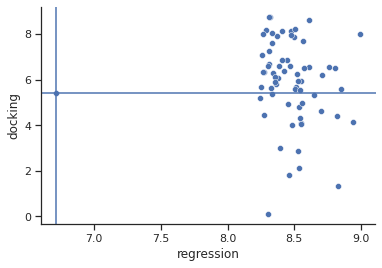

In [45]:
plot_data = complete_data_all.pivot(index=['smiles','ligand ID'], columns='prediction_type', values='prediction')

dockplot = sns.scatterplot(data = plot_data, x = "regression", y = "docking")
docking_ref = float(plot_data.query('`ligand ID` == "Reference"').values[0][0])
dockplot.axhline(docking_ref)
dockplot.axvline(plot_data.query('`ligand ID` == "Reference"').values[0][1])
display(dockplot)
docking_preds = complete_data_all[complete_data_all['prediction_type'] == "docking"]
count_c=docking_preds[docking_preds['prediction'] > docking_ref].count().values[0]
print(f"There are {count_c} compounds with a better docking score than the reference ligand");

Judging from the scatterplot, there are definitely more compounds that could dock better in the screening dataset. However, docking so many compounds would take too much time.
<br>
#### Creating an overview of every compound with a higher docking score than the reference ligand.

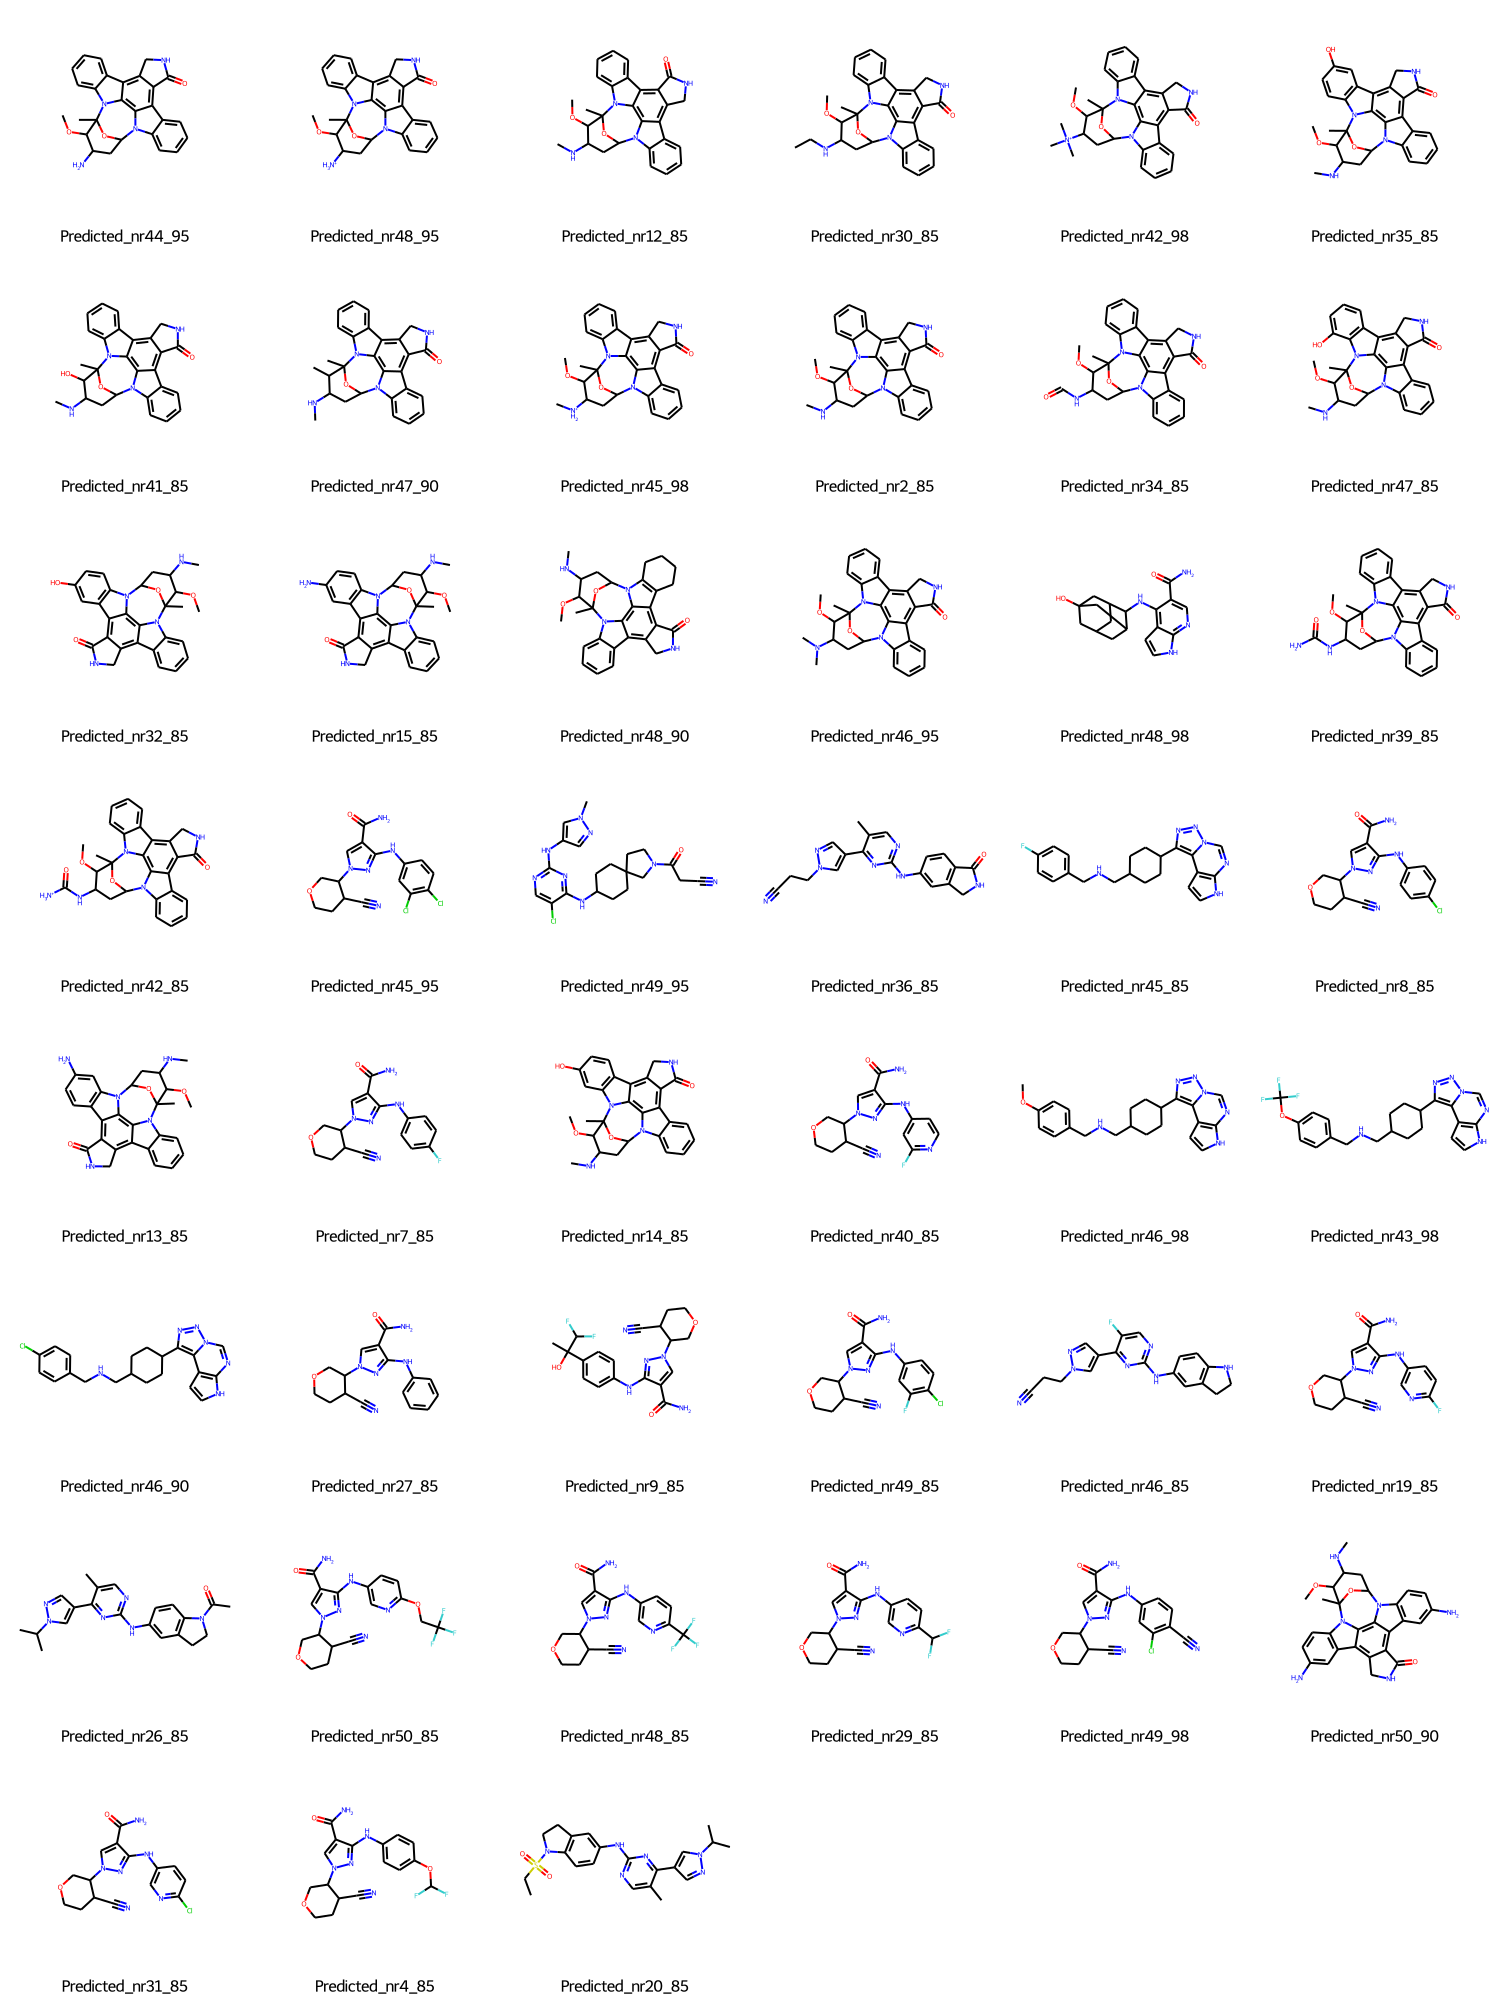

In [46]:
top_docked = docking_preds.sort_values(by="prediction", ascending = False)[:45]

top_docked['rdkit_mol'] = [Chem.MolFromSmiles(s) for s in top_docked['smiles']]

top_docked_img=Draw.MolsToGridImage(top_docked['rdkit_mol'].tolist(),
                            molsPerRow=6,
                            subImgSize=(250,250),
                            legends=top_docked['ligand ID'].tolist())

for i in range(len(top_docked)):
    row = top_docked.iloc[i]
    mol = row['rdkit_mol']
    name = row['ligand ID'] + '.mol'
    Chem.MolToMolFile(mol,name)
    
display(top_docked_img)

Many of the 45 compounds that dock better than the ligand are derived from staurosporine. Lower down the list there are several compounds with different types of structures. The following 3D renders are from 5 unique structure types that have the highest pIC50.

In [47]:
LIGAND_TO_SHOW = 'Predicted_nr44_95'
print(f"Showing {LIGAND_TO_SHOW}")
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(TARGET_PDB_ID),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = '{}_docked.pdb'.format(LIGAND_TO_SHOW)
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(TARGET_PDB_ID),
'{}_docked.pdb'.format(LIGAND_TO_SHOW)
]
with open('{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

                    
with open('{}-complex.pdb'.format(TARGET_PDB_ID)) as f:
    view_screened = nglview.show_file(f, ext="pdb")
    
view.center("UNL")
viewer.show_residues_around(view_screened, selection="UNL")
view_screened

Showing Predicted_nr44_95
Reference: Magenta | Vina Pose: Cyan


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

NGLWidget()

The compound shown above is similar to staurosporine and seems to fit nicely in the docking site with its rings. However, just like peficitinib, the joint ring structure is not right. There are too many bonds to the central oxygen atom. Therefore the docking results are not reliable and it is better to move on to the next compound type.

In [48]:
LIGAND_TO_SHOW = 'Predicted_nr45_95'
print(f"Showing {LIGAND_TO_SHOW}")
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(TARGET_PDB_ID),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = '{}_docked.pdb'.format(LIGAND_TO_SHOW)
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(TARGET_PDB_ID),
'{}_docked.pdb'.format(LIGAND_TO_SHOW)
]
with open('{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

                    
with open('{}-complex.pdb'.format(TARGET_PDB_ID)) as f:
    view_screened = nglview.show_file(f, ext="pdb")
    
view.center("UNL")
viewer.show_residues_around(view_screened, selection="UNL")
view_screened


Showing Predicted_nr45_95
Reference: Magenta | Vina Pose: Cyan


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

NGLWidget()

This compound occupies the docking site in a different position compared to the reference ligand, but it still fits well. It also has a few possible interactions with the protein's residues.

In [49]:
LIGAND_TO_SHOW = 'Predicted_nr49_95'
print(f"Showing {LIGAND_TO_SHOW}")
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(TARGET_PDB_ID),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = '{}_docked.pdb'.format(LIGAND_TO_SHOW)
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(TARGET_PDB_ID),
'{}_docked.pdb'.format(LIGAND_TO_SHOW)
]
with open('{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

                    
with open('{}-complex.pdb'.format(TARGET_PDB_ID)) as f:
    view_screened = nglview.show_file(f, ext="pdb")
    
view.center("UNL")
viewer.show_residues_around(view_screened, selection="UNL")
view_screened


Showing Predicted_nr49_95
Reference: Magenta | Vina Pose: Cyan


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

NGLWidget()

This compound's shape occupies the binding pocket nicely, wrapping around the pocket's contours at both ends of the molecule. However, once again the double ring structure has bonds that are incorrect. The molecule's polar and hydrophobic regions are in the correct place in regards to the protein's residue. So it might still be a good ligand, if the incorrect bonds have not impacted the docking score too much.

In [50]:
LIGAND_TO_SHOW = 'Predicted_nr36_85'
print(f"Showing {LIGAND_TO_SHOW}")
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(TARGET_PDB_ID),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = '{}_docked.pdb'.format(LIGAND_TO_SHOW)
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(TARGET_PDB_ID),
'{}_docked.pdb'.format(LIGAND_TO_SHOW)
]
with open('{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

                    
with open('{}-complex.pdb'.format(TARGET_PDB_ID)) as f:
    view_screened = nglview.show_file(f, ext="pdb")
    
view.center("UNL")
viewer.show_residues_around(view_screened, selection="UNL")
view_screened


Showing Predicted_nr36_85
Reference: Magenta | Vina Pose: Cyan


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

NGLWidget()

This ligand has an interesting structure, it has a long carbon chain with a nitrile group that dips into a different area of the binding pocket. In this area are arginines and an aspartic acid that could form a hydrogen bond with the nitrile group, which might 'anchor' the ligand near the binding pocket.

In [51]:
LIGAND_TO_SHOW = 'Predicted_nr45_85'
print(f"Showing {LIGAND_TO_SHOW}")
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(TARGET_PDB_ID),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = '{}_docked.pdb'.format(LIGAND_TO_SHOW)
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(TARGET_PDB_ID),
'{}_docked.pdb'.format(LIGAND_TO_SHOW)
]
with open('{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

                    
with open('{}-complex.pdb'.format(TARGET_PDB_ID)) as f:
    view_screened = nglview.show_file(f, ext="pdb")
    
view.center("UNL")
viewer.show_residues_around(view_screened, selection="UNL")
view_screened

Showing Predicted_nr45_85
Reference: Magenta | Vina Pose: Cyan


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

NGLWidget()

The last compound is also positioned well in the binding pocket. It has a nitrogen-containing ring near the same position as the reference ligand. There are also quite a few valines and leucines near the carbon rings for hydrophobic interactions.<br><br>
There are still many more of the 45 compounds that docked better than the reference ligand to look at, but for now from this selection there are already a few candidates: nr45_95, nr36_85, nr45_85. It is unfortunate that many of the promising candidates' results are unreliable due to the incorrect ring structures, but at least the aforementioned candidates provide a good alternative.

In [52]:
#Code to save everything
try:
    if save_code == True:
        !tar chvfz notebook.tar.gz *
except:
    pass

4gih/
4gih/4gih.cif
4gih-7q7l-merged.pdb
4gih-complex.pdb
4gih_prepped.pdb
7q7l/
7q7l/7q7l.cif
7q7l-complex.pdb
7q7l-complex_transformed.pdb
7q7l_prepped.pdb
Abrocitinib_docked.pdb
Abrocitinib.mol
Abrocitinib.pdbqt
alignment.fasta
AT-9283_docked.pdb
AT-9283.mol
AT-9283.pdbqt
Baricitinib_docked.pdb
Baricitinib.mol
Baricitinib.pdbqt
catboost_info/
catboost_info/tmp/
catboost_info/catboost_training.json
catboost_info/learn_error.tsv
catboost_info/learn/
catboost_info/learn/events.out.tfevents
catboost_info/time_left.tsv
CHEMBL3553.csv
CHEMBL4078799_docked.pdb
CHEMBL4078799.mol
CHEMBL4078799.pdbqt
CHEMBL4789639_docked.pdb
CHEMBL4789639.mol
CHEMBL4789639.pdbqt
CHEMBL4793760_docked.pdb
CHEMBL4793760.mol
CHEMBL4793760.pdbqt
ChEMBL_TYK2_docked.pdb
ChEMBL_TYK2.mol
ChEMBL_TYK2.pdbqt
complete_data_10_compounds_20_40.csv
complete_data_10_compounds_40_20.csv
complete_data2.csv
completedata80.csv
complete_data_all
complete_data_all.csv
complete_dataFri Nov  4 10:22:33 2022.csv
complete_dataMon Nov  

protein-4gih.pdb
protein-7q7l.pdb
protein.pdbqt
Reference_0X5_docked.pdb
Reference_0X5.mol
Reference_0X5.pdbqt
Reference.mol
results/
results/roc_auc.png
Ruxolitinib_docked.pdb
Ruxolitinib.mol
Ruxolitinib.pdbqt
sample.jpg
screened_all.csv
SCREENEDDATA.csv
screening_all.csv
SCREENINGDATA.csv
Staurosporine_docked.pdb
Staurosporine.mol
Staurosporine.pdbqt
Tofacitinib_docked.pdb
Tofacitinib.mol
Tofacitinib.pdbqt
Upadacitinib_docked.pdb
Upadacitinib.mol
Upadacitinib.pdbqt
